# TOC:
* [FDR corrected maps](#fdr-bullet)
* [Voxel-wise thresholded maps](#voxel-bullet)
* [Concatenate subject scans](#concat-bullet)
* [Cluster extent corrected maps](#cluster-bullet)
* [TFCE corrected positive SV maps](#tfce_pos-bullet)
* [TFCE corrected negative SV maps](#tfce_neg-bullet)


In [1]:
# load modules
from scipy.stats import stats
import scipy.io as spio
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
# from sklearn import preprocessing
# from sklearn.preprocessing import StandardScaler
from nilearn.input_data import NiftiMasker
import nilearn.plotting as plotting
from nilearn.image import mean_img
from nilearn import image
# import pickle
import pandas as pd
import seaborn as sns 

import nipype.pipeline.engine as pe
from nipype.interfaces import spm
from nipype.interfaces import fsl


%matplotlib inline 
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

/gpfs/ysm/project/rj299/conda_envs/py37_dev/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


200908-14:19:40,603 nipype.utils INFO:
	 Running nipype version 1.2.3 (latest: 1.5.0)


Autosaving every 5 seconds


In [3]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/home/rj299/project/MATLAB/toolbox/spm12/') # set default SPM12 path in my computer.

fsl.FSLCommand.set_default_output_type('NIFTI_GZ')

base_root = '/home/rj299/scratch60/mdm_analysis/'
data_root = '/home/rj299/project/mdm_analysis/'
out_root = '/home/rj299/scratch60/mdm_analysis/output'

# Subjects included in analysis
sub_num = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 2593, 2594, 
           2596, 2597, 2598, 2599, 2600, 2624, 2650, 2651, 2652, 2653, 
           2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 
           2664, 2665, 2666]

sub_num.sort()
print('All subjects included in analysis:', sub_num)
print(len(sub_num), 'subjects')

All subjects included in analysis: [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 2593, 2594, 2596, 2597, 2598, 2599, 2600, 2624, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666]
33 subjects


In [4]:
# load anatomical
anat_mean = nib.load(os.path.join(data_root, 'output','imaging', 'all_sub_average.nii.gz'))

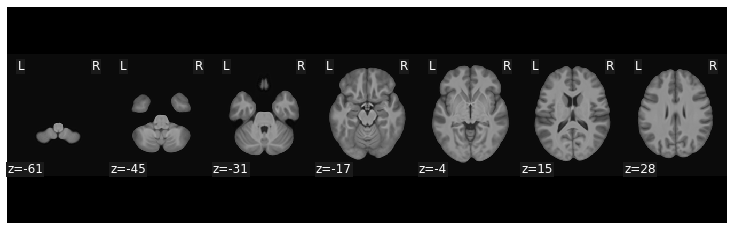

In [5]:
fig = plt.figure(figsize = (10,3))
plotting.plot_anat(anat_mean, black_bg = True, figure = fig,
                  display_mode = 'z')

**Contrast IDs:**  
cont1 = ('Med_amb_24', 'T', cond_names, [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  
cont2 = ('Med_amb_50', 'T', cond_names, [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  
cont3 = ('Med_amb_74', 'T', cond_names, [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  
cont4 = ('Med_risk_25', 'T', cond_names, [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])  
cont5 = ('Med_risk_50', 'T', cond_names, [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])  
cont6 = ('Med_risk_75', 'T', cond_names, [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])  

cont7 = ('Med_amb_50>24', 'T', cond_names, [-1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  
cont8 = ('Med_amb_74>50', 'T', cond_names, [0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  
cont9 = ('Med_amb_74>24', 'T', cond_names, [-1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  

cont10 = ('Med_risk_50>25', 'T', cond_names, [0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0])  
cont11 = ('Med_risk_75>50', 'T', cond_names, [0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0])  
cont12 = ('Med_risk_75>25', 'T', cond_names, [0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0])  

cont13 = ('Mon_amb_24', 'T', cond_names, [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])  
cont14 = ('Mon_amb_50', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])  
cont15 = ('Mon_amb_74', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])  
cont16 = ('Mon_risk_25', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])  
cont17 = ('Mon_risk_50', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])  
cont18 = ('Mon_risk_75', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])  

cont19 = ('Mon_amb_50>24', 'T', cond_names, [0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0])  
cont20 = ('Mon_amb_74>50', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0])  
cont21 = ('Mon_amb_74>24', 'T', cond_names, [0, 0, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0, 0])  

cont22 = ('Mon_risk_50>25', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0])  
cont23 = ('Mon_risk_75>50', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0])  
cont24 = ('Mon_risk_75>25', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0])  

cont25 = ('Response', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])  

### First level result

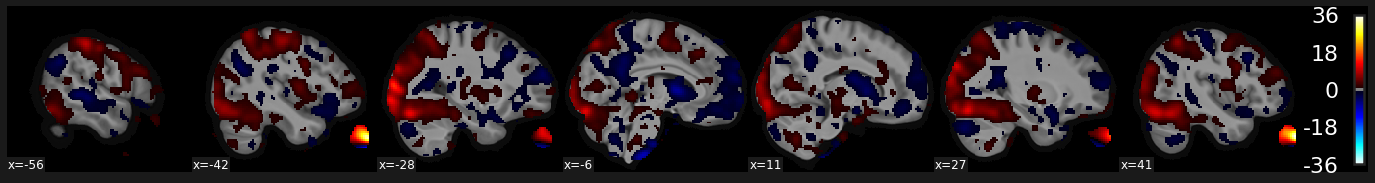

In [5]:
# contrast
con_id = '0001'
plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2073/con_%s.nii' %con_id,
                       anat_mean,
                      threshold = 1,
                      display_mode = 'x')

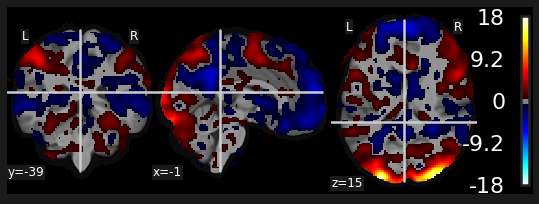

In [7]:
# t map
con_id = '0001'
plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2073/spmT_%s.nii' %con_id,
                       anat_mean,
                      threshold = 0.7,
#                       display_mode = 'x',
                      )

### FDR thresholded <a class = "anchor" id = "fdr-bullet"></a>

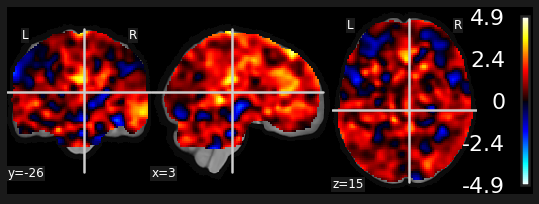

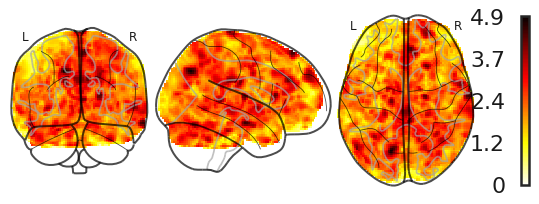

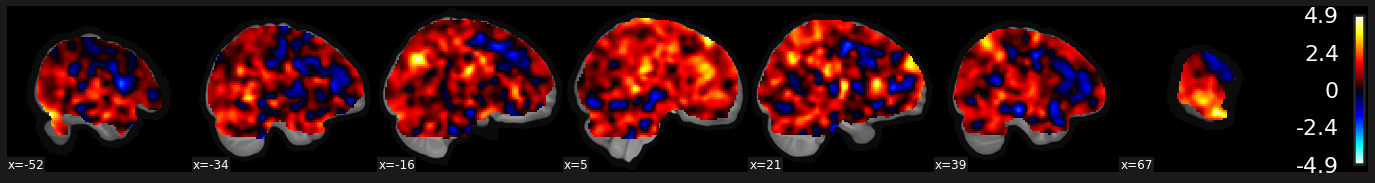

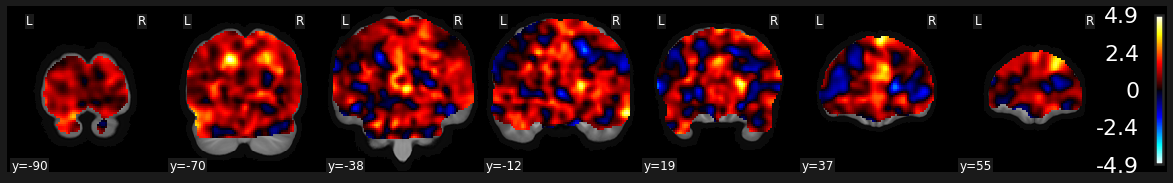

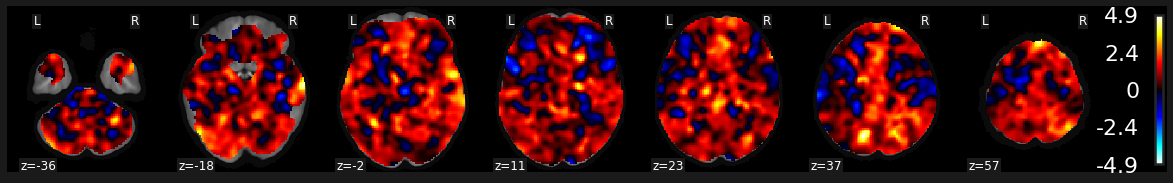

In [22]:
# second-level output: FDR corrected (smpT_thr.nii); unthresholded (smpTxxx.nii)


con_id = '0007'
plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001.nii' %con_id,
                       anat_mean)

plotting.plot_glass_brain('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001.nii' %con_id,
                       colorbar = True)

plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001.nii' %con_id,
                       anat_mean,
                      display_mode = 'x')

plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001.nii' %con_id,
                       anat_mean,
                      display_mode = 'y')

plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001.nii' %con_id,
                       anat_mean,
                      display_mode = 'z')

## Voxel-wise thresholding <a class = "anchor" id = "voxel-bullet"></a>

Without correction just voxel-wise threshold

Medical ambiguity contrast

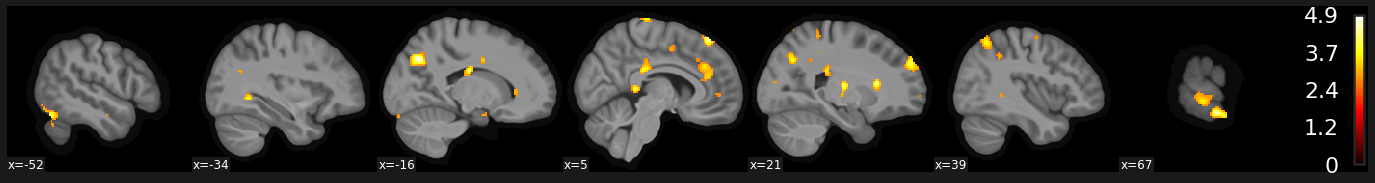

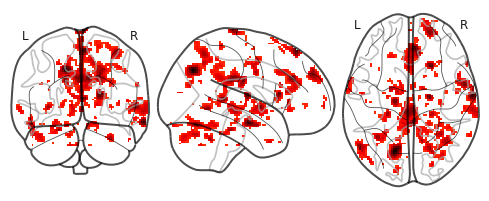

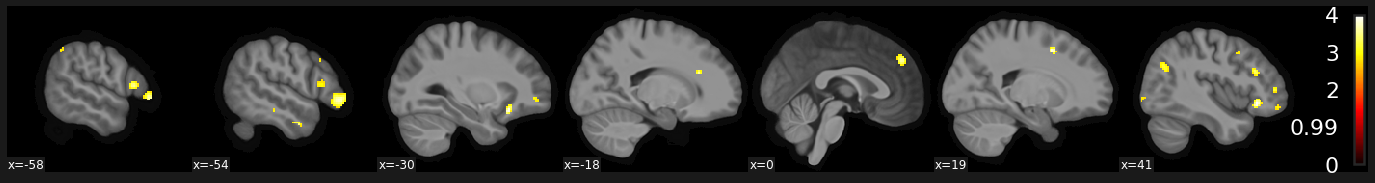

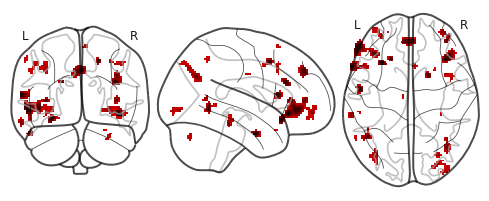

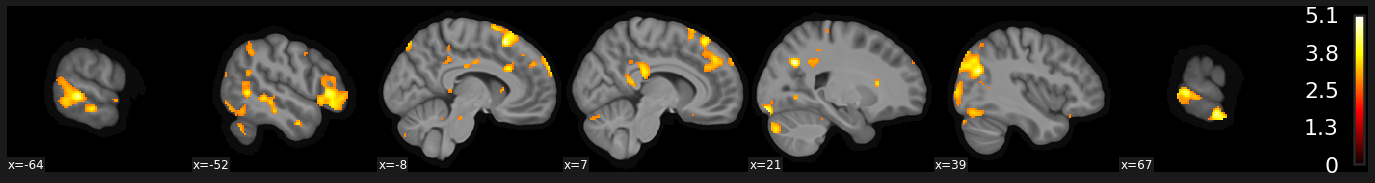

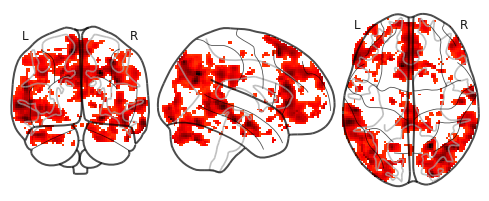

In [6]:
# voxel-wise p threshold
voxel_threshold = 0.005
con_ids = ['0007', '0008', '0009']

# con_ids = ['0007']

for con_id in con_ids:

    spm_thr = spm.Threshold(contrast_index=1,
                            spm_mat_file = os.path.join(out_root, 'imaging', 'Sink_resp_uncert/2ndLevel_heightp05/_contrast_id_con_%s/SPM.mat' %con_id),
                            stat_image = os.path.join(out_root, 'imaging', 'Sink_resp_uncert/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001.nii' %con_id),
                            use_topo_fdr=False,
                            use_fwe_correction=False, # here we can use fwe or fdr, default is true
    #                         extent_threshold=10,
                            height_threshold= voxel_threshold, # default is 0.05
    #                         extent_fdr_p_threshold = 0.05,
                            height_threshold_type='p-value', # default is p-value
                            )
    spm_thr.run()

    # plot 
    plotting.plot_stat_map('/home/rj299/project/mdm_analysis/mdm_imaging_analysis/spmT_0001_thr.nii',
                          bg_img = anat_mean,
                           display_mode = 'x')
    
    plotting.plot_glass_brain('/home/rj299/project/mdm_analysis/mdm_imaging_analysis/spmT_0001_thr.nii')
    # plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/mdm_imaging_analysis/spmT_0001_pre_topo_thr.nii')

Monetary ambiguity contrast

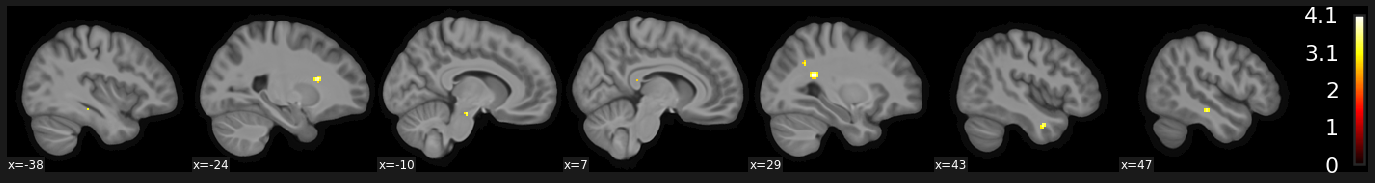

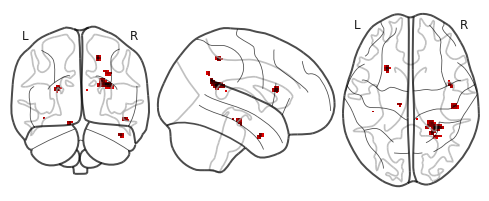

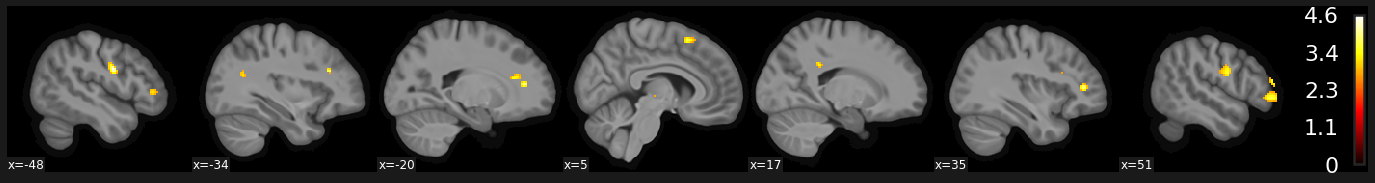

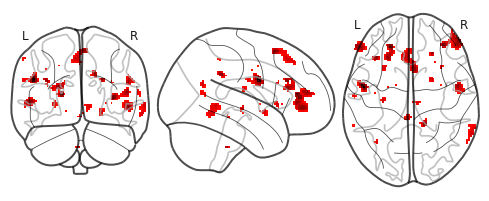

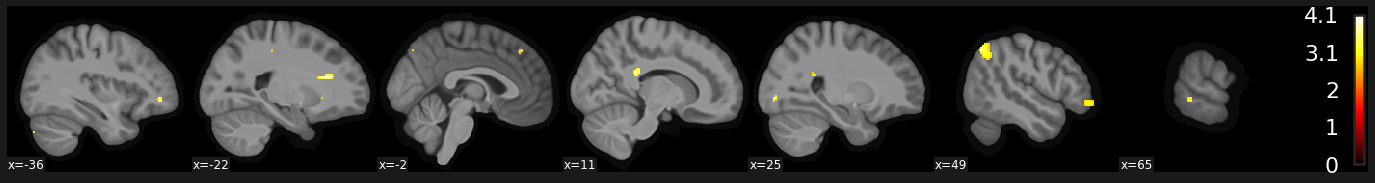

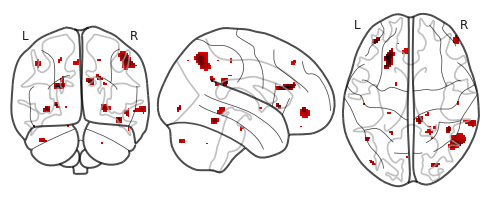

In [25]:
# voxel-wise p threshold
voxel_threshold = 0.005
con_ids = ['0019', '0020', '0021']

# con_ids = ['0007']

for con_id in con_ids:

    spm_thr = spm.Threshold(contrast_index=1,
                            spm_mat_file = os.path.join(out_root, 'imaging', 'Sink_resp_uncert/2ndLevel_heightp05/_contrast_id_con_%s/SPM.mat' %con_id),
                            stat_image = os.path.join(out_root, 'imaging', 'Sink_resp_uncert/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001.nii' %con_id),
                            use_topo_fdr=False,
                            use_fwe_correction=False, # here we can use fwe or fdr, default is true
    #                         extent_threshold=10,
                            height_threshold= voxel_threshold, # default is 0.05
    #                         extent_fdr_p_threshold = 0.05,
                            height_threshold_type='p-value', # default is p-value
                            )
    spm_thr.run()

    # plot 
    plotting.plot_stat_map('/home/rj299/project/mdm_analysis/mdm_imaging_analysis/spmT_0001_thr.nii',
                          bg_img = anat_mean,
                           display_mode = 'x')
    
    plotting.plot_glass_brain('/home/rj299/project/mdm_analysis/mdm_imaging_analysis/spmT_0001_thr.nii')

Medical risk contrast

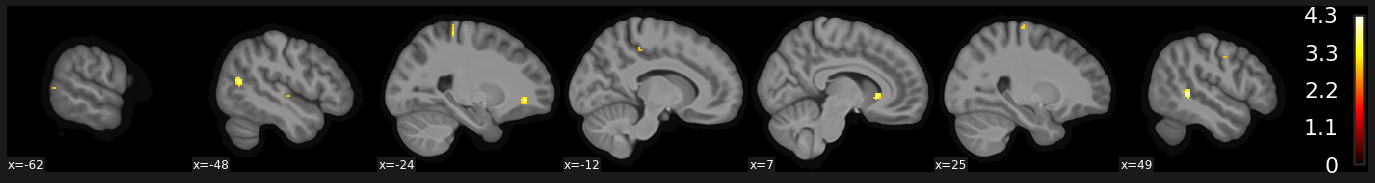

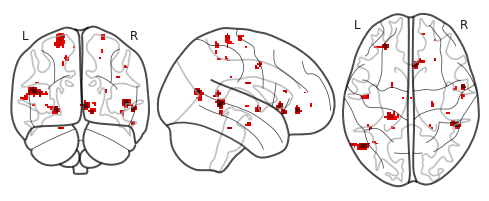

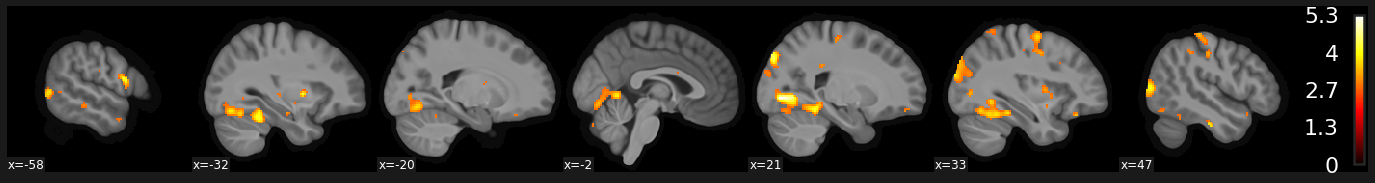

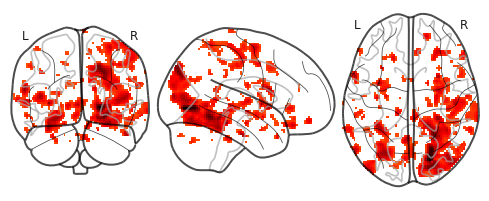

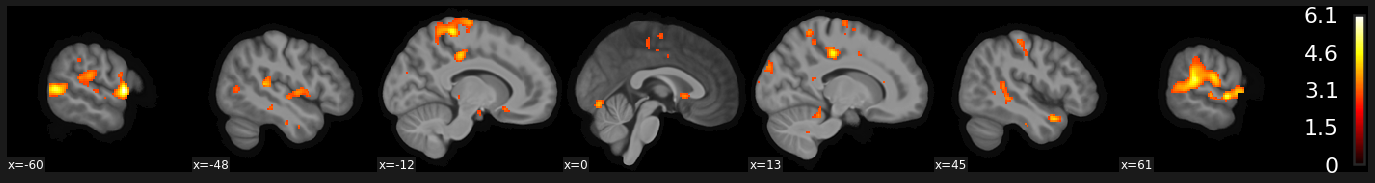

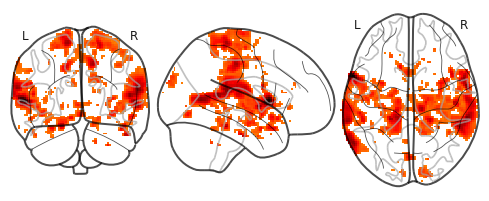

In [26]:
# voxel-wise p threshold
voxel_threshold = 0.005
con_ids = ['0010', '0011', '0012']

# con_ids = ['0007']

for con_id in con_ids:

    spm_thr = spm.Threshold(contrast_index=1,
                            spm_mat_file = os.path.join(out_root, 'imaging', 'Sink_resp_uncert/2ndLevel_heightp05/_contrast_id_con_%s/SPM.mat' %con_id),
                            stat_image = os.path.join(out_root, 'imaging', 'Sink_resp_uncert/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001.nii' %con_id),
                            use_topo_fdr=False,
                            use_fwe_correction=False, # here we can use fwe or fdr, default is true
    #                         extent_threshold=10,
                            height_threshold= voxel_threshold, # default is 0.05
    #                         extent_fdr_p_threshold = 0.05,
                            height_threshold_type='p-value', # default is p-value
                            )
    spm_thr.run()

    # plot 
    plotting.plot_stat_map('/home/rj299/project/mdm_analysis/mdm_imaging_analysis/spmT_0001_thr.nii',
                          bg_img = anat_mean,
                           display_mode = 'x')
    
    plotting.plot_glass_brain('/home/rj299/project/mdm_analysis/mdm_imaging_analysis/spmT_0001_thr.nii')

Monetary risk contrast

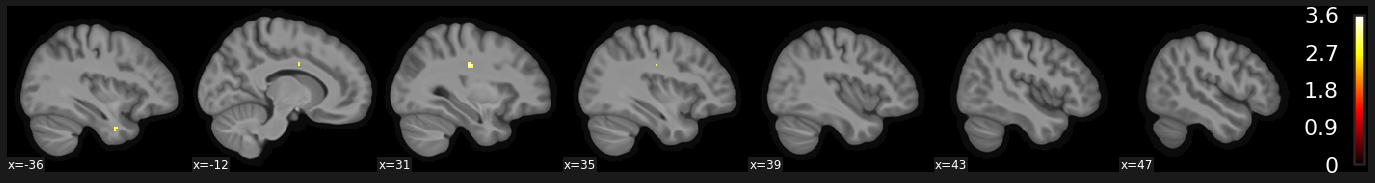

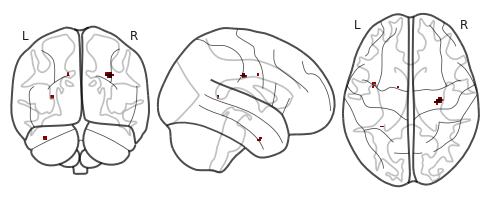

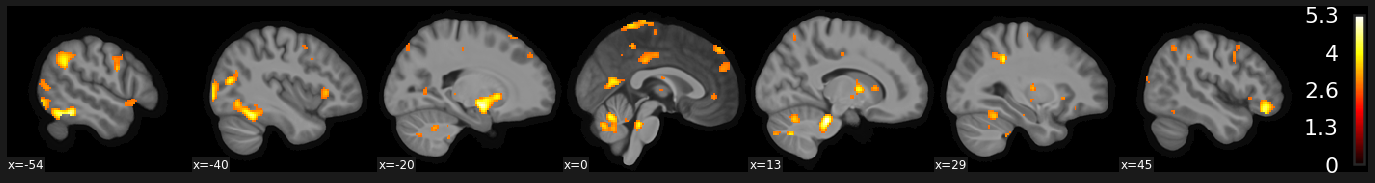

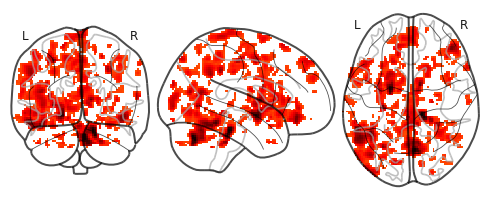

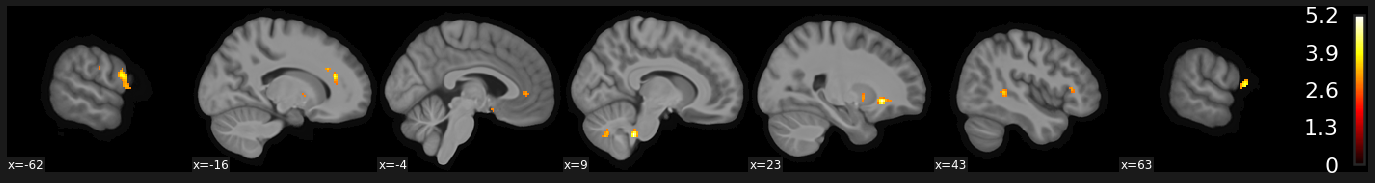

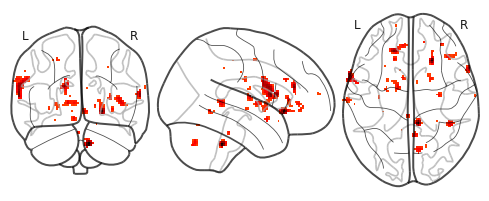

In [27]:
# voxel-wise p threshold
voxel_threshold = 0.005
con_ids = ['0022', '0023', '0024']

# con_ids = ['0007']

for con_id in con_ids:

    spm_thr = spm.Threshold(contrast_index=1,
                            spm_mat_file = os.path.join(out_root, 'imaging', 'Sink_resp_uncert/2ndLevel_heightp05/_contrast_id_con_%s/SPM.mat' %con_id),
                            stat_image = os.path.join(out_root, 'imaging', 'Sink_resp_uncert/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001.nii' %con_id),
                            use_topo_fdr=False,
                            use_fwe_correction=False, # here we can use fwe or fdr, default is true
    #                         extent_threshold=10,
                            height_threshold= voxel_threshold, # default is 0.05
    #                         extent_fdr_p_threshold = 0.05,
                            height_threshold_type='p-value', # default is p-value
                            )
    spm_thr.run()

    # plot 
    plotting.plot_stat_map('/home/rj299/project/mdm_analysis/mdm_imaging_analysis/spmT_0001_thr.nii',
                          bg_img = anat_mean,
                           display_mode = 'x')
    
    plotting.plot_glass_brain('/home/rj299/project/mdm_analysis/mdm_imaging_analysis/spmT_0001_thr.nii')

Response

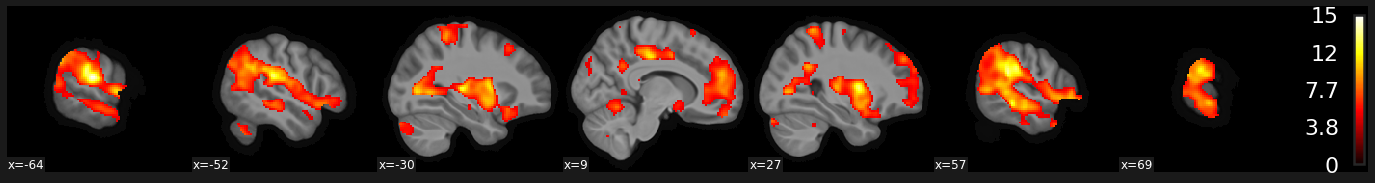

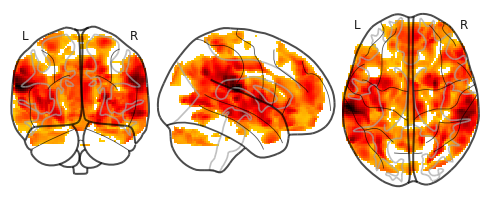

In [30]:
# voxel-wise p threshold
voxel_threshold = 0.00001
con_ids = ['0025']

# con_ids = ['0007']

for con_id in con_ids:

    spm_thr = spm.Threshold(contrast_index=1,
                            spm_mat_file = os.path.join(out_root, 'imaging', 'Sink_resp_uncert/2ndLevel_heightp05/_contrast_id_con_%s/SPM.mat' %con_id),
                            stat_image = os.path.join(out_root, 'imaging', 'Sink_resp_uncert/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001.nii' %con_id),
                            use_topo_fdr=False,
                            use_fwe_correction=False, # here we can use fwe or fdr, default is true
    #                         extent_threshold=10,
                            height_threshold= voxel_threshold, # default is 0.05
    #                         extent_fdr_p_threshold = 0.05,
                            height_threshold_type='p-value', # default is p-value
                            )
    spm_thr.run()

    # plot 
    plotting.plot_stat_map('/home/rj299/project/mdm_analysis/mdm_imaging_analysis/spmT_0001_thr.nii',
                          bg_img = anat_mean,
                           display_mode = 'x')
    
    plotting.plot_glass_brain('/home/rj299/project/mdm_analysis/mdm_imaging_analysis/spmT_0001_thr.nii')

## Concatenate all subjects' contrast <a class = "anchor" id = "concat-bullet"></a>

In [31]:
con_id = '0007'
con_filenames = ['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_*/con_%s.nii' %con_id]

con_all = {}

for i in sub_num:
    con_image = glob.glob('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_' + str(i) + '/con_%s.nii' %con_id)
    con_all[str(i)] = list(con_image)
print(len(con_all))
con_all

33


{'2073': ['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2073/con_0007.nii'],
 '2550': ['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2550/con_0007.nii'],
 '2582': ['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2582/con_0007.nii'],
 '2583': ['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2583/con_0007.nii'],
 '2584': ['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2584/con_0007.nii'],
 '2585': ['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2585/con_0007.nii'],
 '2588': ['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2588/con_0007.nii'],
 '2592': ['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2592/con_0007.nii'],
 '2593': ['/home/rj299/scratch60/mdm_ana

In [32]:
smooth_con_all = []

for k, v in con_all.items():
    smooth_con = image.smooth_img(v[0],None) #  If fwhm is None, no filtering is performed (useful when just removal of non-finite values is needed).
    print(v)
    smooth_con_all.append(smooth_con)
    
#     plotting.plot_glass_brain(smooth_con, colorbar = True)

['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2073/con_0007.nii']
['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2550/con_0007.nii']
['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2582/con_0007.nii']
['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2583/con_0007.nii']
['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2584/con_0007.nii']
['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2585/con_0007.nii']
['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2588/con_0007.nii']
['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2592/con_0007.nii']
['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_2593/con_0007.nii']
['/home/rj

In [33]:
# from nilearn import image
con_concat = image.concat_imgs(smooth_con_all, auto_resample = True)
con_concat.to_filename(os.path.join(out_root, 'imaging', 'Sink_resp_uncert', 'uncert_glm_con%s_all_sub.nii.gz' %con_id))

In [46]:
# con_single = image.index_img(con_concat, 0)
# plotting.plot_glass_brain(con_single, colorbar = "w")

In [47]:
# for con_single in image.iter_img(con_concat):
#     plotting.plot_glass_brain(con_single, display_mode = 'lyrz', colorbar = "w")

In [34]:
# flip sign for the Mon > Med contrast
smooth_con_flip_all = []

for smooth_img in smooth_con_all:
    smooth_img_flip = image.math_img("-img", img=smooth_img)
    smooth_con_flip_all.append(smooth_img_flip)
    
con_concat_flip = image.concat_imgs(smooth_con_flip_all, auto_resample = True)
con_concat_flip.to_filename(os.path.join(out_root, 'imaging', 'Sink_resp_uncert', 'uncert_glm_con%s_flip_all_sub.nii.gz' %con_id))

## Cluster extent thresholding <a class = "anchor" id = "cluster-bullet"></a>

In [7]:
# conduct cluster-extent thresholding
# voxel-wise p threshold
voxel_threshold = 0.001
con_ids = ['0007']

for con_id in con_ids:

    spm_thr = spm.Threshold(contrast_index=1,
                            spm_mat_file = os.path.join(out_root, 'imaging', 'Sink_resp_uncert/2ndLevel_heightp05/_contrast_id_con_%s/SPM.mat' %con_id),
                            stat_image = os.path.join(out_root, 'imaging', 'Sink_resp_uncert/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001.nii' %con_id),
                            use_topo_fdr=False,
                            use_fwe_correction=False, # here we can use fwe or fdr, default is true
    #                         extent_threshold=10,
                            height_threshold= voxel_threshold, # default is 0.05
    #                         extent_fdr_p_threshold = 0.05,
                            height_threshold_type='p-value', # default is p-value
                            )
    spm_thr.run()

    # find the critical p value for a certain threshold
    t = nib.load('/home/rj299/project/mdm_analysis/mdm_imaging_analysis/spmT_0001_thr.nii')
    t_data = t.get_data()
    t_data_mask = ~np.isnan(t_data)
    t_critical = np.min(t_data[t_data_mask])
    t_critical

    # cluster extent threshold, using the preivous t_critical for initial thresholing
    cluster_thr = fsl.Randomise(in_file = os.path.join(out_root, 'imaging', 'Sink_resp_uncert', 'uncert_glm_con%s_all_sub.nii.gz' %con_id),
                                mask = '/home/rj299/project/mdm_analysis/output/imaging/wb_mask_group.nii.gz',
                                base_name = os.path.join(out_root, 'imaging', 'Sink_resp_uncert', 'con%s_p001' %con_id),
                                c_thresh = t_critical,
                                one_sample_group_mean = True,
                                tfce = False,
                                vox_p_values = True, 
    #                             raw_stats_imgs = True,
                                num_perm = 5000)
    cluster_thr.run()
    

200908-14:25:55,482 nipype.interface INFO:
	 stdout 2020-09-08T14:25:55.482828:randomise options: -i /home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/uncert_glm_con0007_all_sub.nii.gz -o /home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/con0007_p001 -c 3.4 -m /home/rj299/project/mdm_analysis/output/imaging/wb_mask_group.nii.gz -n 5000 -1 -x 
200908-14:25:56,410 nipype.interface INFO:
	 stdout 2020-09-08T14:25:56.410675:Loading Data: 
200908-14:25:56,412 nipype.interface INFO:
	 stdout 2020-09-08T14:25:56.412888:Data loaded
200908-14:25:56,646 nipype.interface INFO:
	 stdout 2020-09-08T14:25:56.646285:One-sample design detected; sign-flipping instead of permuting.
200908-14:25:56,648 nipype.interface INFO:
	 stdout 2020-09-08T14:25:56.648513:8.58993e+09 sign-flips required for exhaustive test of t-test 1
200908-14:25:56,655 nipype.interface INFO:
	 stdout 2020-09-08T14:25:56.655463:Doing 5000 random permutations
200908-14:25:56,660 nipype.interface INF

200908-14:26:05,261 nipype.interface INFO:
	 stdout 2020-09-08T14:26:05.261880:Starting permutation 72
200908-14:26:05,380 nipype.interface INFO:
	 stdout 2020-09-08T14:26:05.380136:Starting permutation 73
200908-14:26:05,501 nipype.interface INFO:
	 stdout 2020-09-08T14:26:05.501170:Starting permutation 74
200908-14:26:05,620 nipype.interface INFO:
	 stdout 2020-09-08T14:26:05.620945:Starting permutation 75
200908-14:26:05,740 nipype.interface INFO:
	 stdout 2020-09-08T14:26:05.740544:Starting permutation 76
200908-14:26:05,858 nipype.interface INFO:
	 stdout 2020-09-08T14:26:05.858681:Starting permutation 77
200908-14:26:05,977 nipype.interface INFO:
	 stdout 2020-09-08T14:26:05.976960:Starting permutation 78
200908-14:26:06,96 nipype.interface INFO:
	 stdout 2020-09-08T14:26:06.096412:Starting permutation 79
200908-14:26:06,215 nipype.interface INFO:
	 stdout 2020-09-08T14:26:06.215235:Starting permutation 80
200908-14:26:06,334 nipype.interface INFO:
	 stdout 2020-09-08T14:26:06.33

200908-14:26:14,774 nipype.interface INFO:
	 stdout 2020-09-08T14:26:14.774429:Starting permutation 152
200908-14:26:14,897 nipype.interface INFO:
	 stdout 2020-09-08T14:26:14.897217:Starting permutation 153
200908-14:26:15,16 nipype.interface INFO:
	 stdout 2020-09-08T14:26:15.016129:Starting permutation 154
200908-14:26:15,135 nipype.interface INFO:
	 stdout 2020-09-08T14:26:15.135765:Starting permutation 155
200908-14:26:15,259 nipype.interface INFO:
	 stdout 2020-09-08T14:26:15.259373:Starting permutation 156
200908-14:26:15,377 nipype.interface INFO:
	 stdout 2020-09-08T14:26:15.377474:Starting permutation 157
200908-14:26:15,498 nipype.interface INFO:
	 stdout 2020-09-08T14:26:15.498129:Starting permutation 158
200908-14:26:15,621 nipype.interface INFO:
	 stdout 2020-09-08T14:26:15.621857:Starting permutation 159
200908-14:26:15,740 nipype.interface INFO:
	 stdout 2020-09-08T14:26:15.740028:Starting permutation 160
200908-14:26:15,861 nipype.interface INFO:
	 stdout 2020-09-08T14

200908-14:26:24,264 nipype.interface INFO:
	 stdout 2020-09-08T14:26:24.264594:Starting permutation 231
200908-14:26:24,382 nipype.interface INFO:
	 stdout 2020-09-08T14:26:24.382898:Starting permutation 232
200908-14:26:24,503 nipype.interface INFO:
	 stdout 2020-09-08T14:26:24.503761:Starting permutation 233
200908-14:26:24,623 nipype.interface INFO:
	 stdout 2020-09-08T14:26:24.623600:Starting permutation 234
200908-14:26:24,741 nipype.interface INFO:
	 stdout 2020-09-08T14:26:24.741628:Starting permutation 235
200908-14:26:24,863 nipype.interface INFO:
	 stdout 2020-09-08T14:26:24.863232:Starting permutation 236
200908-14:26:24,983 nipype.interface INFO:
	 stdout 2020-09-08T14:26:24.983110:Starting permutation 237
200908-14:26:25,101 nipype.interface INFO:
	 stdout 2020-09-08T14:26:25.101144:Starting permutation 238
200908-14:26:25,222 nipype.interface INFO:
	 stdout 2020-09-08T14:26:25.222482:Starting permutation 239
200908-14:26:25,342 nipype.interface INFO:
	 stdout 2020-09-08T1

200908-14:26:33,727 nipype.interface INFO:
	 stdout 2020-09-08T14:26:33.727647:Starting permutation 310
200908-14:26:33,845 nipype.interface INFO:
	 stdout 2020-09-08T14:26:33.845716:Starting permutation 311
200908-14:26:33,965 nipype.interface INFO:
	 stdout 2020-09-08T14:26:33.965180:Starting permutation 312
200908-14:26:34,83 nipype.interface INFO:
	 stdout 2020-09-08T14:26:34.083519:Starting permutation 313
200908-14:26:34,203 nipype.interface INFO:
	 stdout 2020-09-08T14:26:34.203134:Starting permutation 314
200908-14:26:34,321 nipype.interface INFO:
	 stdout 2020-09-08T14:26:34.321291:Starting permutation 315
200908-14:26:34,441 nipype.interface INFO:
	 stdout 2020-09-08T14:26:34.441877:Starting permutation 316
200908-14:26:34,562 nipype.interface INFO:
	 stdout 2020-09-08T14:26:34.561949:Starting permutation 317
200908-14:26:34,680 nipype.interface INFO:
	 stdout 2020-09-08T14:26:34.680184:Starting permutation 318
200908-14:26:34,800 nipype.interface INFO:
	 stdout 2020-09-08T14

200908-14:26:43,192 nipype.interface INFO:
	 stdout 2020-09-08T14:26:43.192530:Starting permutation 389
200908-14:26:43,310 nipype.interface INFO:
	 stdout 2020-09-08T14:26:43.310821:Starting permutation 390
200908-14:26:43,430 nipype.interface INFO:
	 stdout 2020-09-08T14:26:43.430193:Starting permutation 391
200908-14:26:43,551 nipype.interface INFO:
	 stdout 2020-09-08T14:26:43.551303:Starting permutation 392
200908-14:26:43,669 nipype.interface INFO:
	 stdout 2020-09-08T14:26:43.669847:Starting permutation 393
200908-14:26:43,789 nipype.interface INFO:
	 stdout 2020-09-08T14:26:43.789519:Starting permutation 394
200908-14:26:43,910 nipype.interface INFO:
	 stdout 2020-09-08T14:26:43.910782:Starting permutation 395
200908-14:26:44,29 nipype.interface INFO:
	 stdout 2020-09-08T14:26:44.028967:Starting permutation 396
200908-14:26:44,154 nipype.interface INFO:
	 stdout 2020-09-08T14:26:44.154577:Starting permutation 397
200908-14:26:44,275 nipype.interface INFO:
	 stdout 2020-09-08T14

200908-14:26:52,655 nipype.interface INFO:
	 stdout 2020-09-08T14:26:52.655269:Starting permutation 468
200908-14:26:52,774 nipype.interface INFO:
	 stdout 2020-09-08T14:26:52.774768:Starting permutation 469
200908-14:26:52,893 nipype.interface INFO:
	 stdout 2020-09-08T14:26:52.893592:Starting permutation 470
200908-14:26:53,14 nipype.interface INFO:
	 stdout 2020-09-08T14:26:53.014847:Starting permutation 471
200908-14:26:53,134 nipype.interface INFO:
	 stdout 2020-09-08T14:26:53.134705:Starting permutation 472
200908-14:26:53,253 nipype.interface INFO:
	 stdout 2020-09-08T14:26:53.253150:Starting permutation 473
200908-14:26:53,374 nipype.interface INFO:
	 stdout 2020-09-08T14:26:53.374156:Starting permutation 474
200908-14:26:53,493 nipype.interface INFO:
	 stdout 2020-09-08T14:26:53.493586:Starting permutation 475
200908-14:26:53,612 nipype.interface INFO:
	 stdout 2020-09-08T14:26:53.612044:Starting permutation 476
200908-14:26:53,733 nipype.interface INFO:
	 stdout 2020-09-08T14

200908-14:27:02,102 nipype.interface INFO:
	 stdout 2020-09-08T14:27:02.102106:Starting permutation 547
200908-14:27:02,220 nipype.interface INFO:
	 stdout 2020-09-08T14:27:02.220224:Starting permutation 548
200908-14:27:02,340 nipype.interface INFO:
	 stdout 2020-09-08T14:27:02.340072:Starting permutation 549
200908-14:27:02,459 nipype.interface INFO:
	 stdout 2020-09-08T14:27:02.459568:Starting permutation 550
200908-14:27:02,577 nipype.interface INFO:
	 stdout 2020-09-08T14:27:02.577703:Starting permutation 551
200908-14:27:02,698 nipype.interface INFO:
	 stdout 2020-09-08T14:27:02.698325:Starting permutation 552
200908-14:27:02,818 nipype.interface INFO:
	 stdout 2020-09-08T14:27:02.818235:Starting permutation 553
200908-14:27:02,936 nipype.interface INFO:
	 stdout 2020-09-08T14:27:02.936480:Starting permutation 554
200908-14:27:03,57 nipype.interface INFO:
	 stdout 2020-09-08T14:27:03.057399:Starting permutation 555
200908-14:27:03,175 nipype.interface INFO:
	 stdout 2020-09-08T14

200908-14:27:11,571 nipype.interface INFO:
	 stdout 2020-09-08T14:27:11.571461:Starting permutation 626
200908-14:27:11,690 nipype.interface INFO:
	 stdout 2020-09-08T14:27:11.690373:Starting permutation 627
200908-14:27:11,811 nipype.interface INFO:
	 stdout 2020-09-08T14:27:11.811537:Starting permutation 628
200908-14:27:11,933 nipype.interface INFO:
	 stdout 2020-09-08T14:27:11.933888:Starting permutation 629
200908-14:27:12,63 nipype.interface INFO:
	 stdout 2020-09-08T14:27:12.063559:Starting permutation 630
200908-14:27:12,185 nipype.interface INFO:
	 stdout 2020-09-08T14:27:12.185349:Starting permutation 631
200908-14:27:12,308 nipype.interface INFO:
	 stdout 2020-09-08T14:27:12.308182:Starting permutation 632
200908-14:27:12,432 nipype.interface INFO:
	 stdout 2020-09-08T14:27:12.432235:Starting permutation 633
200908-14:27:12,551 nipype.interface INFO:
	 stdout 2020-09-08T14:27:12.551029:Starting permutation 634
200908-14:27:12,673 nipype.interface INFO:
	 stdout 2020-09-08T14

200908-14:27:21,154 nipype.interface INFO:
	 stdout 2020-09-08T14:27:21.154906:Starting permutation 705
200908-14:27:21,275 nipype.interface INFO:
	 stdout 2020-09-08T14:27:21.275258:Starting permutation 706
200908-14:27:21,394 nipype.interface INFO:
	 stdout 2020-09-08T14:27:21.393955:Starting permutation 707
200908-14:27:21,515 nipype.interface INFO:
	 stdout 2020-09-08T14:27:21.515291:Starting permutation 708
200908-14:27:21,634 nipype.interface INFO:
	 stdout 2020-09-08T14:27:21.634083:Starting permutation 709
200908-14:27:21,754 nipype.interface INFO:
	 stdout 2020-09-08T14:27:21.753965:Starting permutation 710
200908-14:27:21,875 nipype.interface INFO:
	 stdout 2020-09-08T14:27:21.875196:Starting permutation 711
200908-14:27:21,993 nipype.interface INFO:
	 stdout 2020-09-08T14:27:21.993533:Starting permutation 712
200908-14:27:22,113 nipype.interface INFO:
	 stdout 2020-09-08T14:27:22.113599:Starting permutation 713
200908-14:27:22,233 nipype.interface INFO:
	 stdout 2020-09-08T1

200908-14:27:30,657 nipype.interface INFO:
	 stdout 2020-09-08T14:27:30.657651:Starting permutation 784
200908-14:27:30,776 nipype.interface INFO:
	 stdout 2020-09-08T14:27:30.776199:Starting permutation 785
200908-14:27:30,896 nipype.interface INFO:
	 stdout 2020-09-08T14:27:30.896256:Starting permutation 786
200908-14:27:31,17 nipype.interface INFO:
	 stdout 2020-09-08T14:27:31.017696:Starting permutation 787
200908-14:27:31,137 nipype.interface INFO:
	 stdout 2020-09-08T14:27:31.137341:Starting permutation 788
200908-14:27:31,257 nipype.interface INFO:
	 stdout 2020-09-08T14:27:31.257925:Starting permutation 789
200908-14:27:31,379 nipype.interface INFO:
	 stdout 2020-09-08T14:27:31.379423:Starting permutation 790
200908-14:27:31,497 nipype.interface INFO:
	 stdout 2020-09-08T14:27:31.497267:Starting permutation 791
200908-14:27:31,616 nipype.interface INFO:
	 stdout 2020-09-08T14:27:31.616904:Starting permutation 792
200908-14:27:31,734 nipype.interface INFO:
	 stdout 2020-09-08T14

200908-14:27:40,92 nipype.interface INFO:
	 stdout 2020-09-08T14:27:40.092224:Starting permutation 863
200908-14:27:40,213 nipype.interface INFO:
	 stdout 2020-09-08T14:27:40.213166:Starting permutation 864
200908-14:27:40,331 nipype.interface INFO:
	 stdout 2020-09-08T14:27:40.331719:Starting permutation 865
200908-14:27:40,451 nipype.interface INFO:
	 stdout 2020-09-08T14:27:40.451261:Starting permutation 866
200908-14:27:40,569 nipype.interface INFO:
	 stdout 2020-09-08T14:27:40.569606:Starting permutation 867
200908-14:27:40,691 nipype.interface INFO:
	 stdout 2020-09-08T14:27:40.691114:Starting permutation 868
200908-14:27:40,811 nipype.interface INFO:
	 stdout 2020-09-08T14:27:40.811703:Starting permutation 869
200908-14:27:40,930 nipype.interface INFO:
	 stdout 2020-09-08T14:27:40.930336:Starting permutation 870
200908-14:27:41,51 nipype.interface INFO:
	 stdout 2020-09-08T14:27:41.051828:Starting permutation 871
200908-14:27:41,170 nipype.interface INFO:
	 stdout 2020-09-08T14:

200908-14:27:49,551 nipype.interface INFO:
	 stdout 2020-09-08T14:27:49.551070:Starting permutation 942
200908-14:27:49,669 nipype.interface INFO:
	 stdout 2020-09-08T14:27:49.669477:Starting permutation 943
200908-14:27:49,787 nipype.interface INFO:
	 stdout 2020-09-08T14:27:49.787580:Starting permutation 944
200908-14:27:49,905 nipype.interface INFO:
	 stdout 2020-09-08T14:27:49.905666:Starting permutation 945
200908-14:27:50,24 nipype.interface INFO:
	 stdout 2020-09-08T14:27:50.024704:Starting permutation 946
200908-14:27:50,144 nipype.interface INFO:
	 stdout 2020-09-08T14:27:50.144197:Starting permutation 947
200908-14:27:50,263 nipype.interface INFO:
	 stdout 2020-09-08T14:27:50.263713:Starting permutation 948
200908-14:27:50,381 nipype.interface INFO:
	 stdout 2020-09-08T14:27:50.381907:Starting permutation 949
200908-14:27:50,503 nipype.interface INFO:
	 stdout 2020-09-08T14:27:50.503221:Starting permutation 950
200908-14:27:50,621 nipype.interface INFO:
	 stdout 2020-09-08T14

200908-14:27:58,984 nipype.interface INFO:
	 stdout 2020-09-08T14:27:58.984385:Starting permutation 1021
200908-14:27:59,102 nipype.interface INFO:
	 stdout 2020-09-08T14:27:59.102316:Starting permutation 1022
200908-14:27:59,223 nipype.interface INFO:
	 stdout 2020-09-08T14:27:59.223447:Starting permutation 1023
200908-14:27:59,343 nipype.interface INFO:
	 stdout 2020-09-08T14:27:59.343152:Starting permutation 1024
200908-14:27:59,461 nipype.interface INFO:
	 stdout 2020-09-08T14:27:59.461747:Starting permutation 1025
200908-14:27:59,582 nipype.interface INFO:
	 stdout 2020-09-08T14:27:59.582728:Starting permutation 1026
200908-14:27:59,700 nipype.interface INFO:
	 stdout 2020-09-08T14:27:59.700816:Starting permutation 1027
200908-14:27:59,820 nipype.interface INFO:
	 stdout 2020-09-08T14:27:59.820700:Starting permutation 1028
200908-14:27:59,942 nipype.interface INFO:
	 stdout 2020-09-08T14:27:59.942131:Starting permutation 1029
200908-14:28:00,60 nipype.interface INFO:
	 stdout 2020

200908-14:28:08,440 nipype.interface INFO:
	 stdout 2020-09-08T14:28:08.440875:Starting permutation 1100
200908-14:28:08,559 nipype.interface INFO:
	 stdout 2020-09-08T14:28:08.559409:Starting permutation 1101
200908-14:28:08,680 nipype.interface INFO:
	 stdout 2020-09-08T14:28:08.680665:Starting permutation 1102
200908-14:28:08,804 nipype.interface INFO:
	 stdout 2020-09-08T14:28:08.804863:Starting permutation 1103
200908-14:28:08,923 nipype.interface INFO:
	 stdout 2020-09-08T14:28:08.923330:Starting permutation 1104
200908-14:28:09,44 nipype.interface INFO:
	 stdout 2020-09-08T14:28:09.044346:Starting permutation 1105
200908-14:28:09,162 nipype.interface INFO:
	 stdout 2020-09-08T14:28:09.162841:Starting permutation 1106
200908-14:28:09,281 nipype.interface INFO:
	 stdout 2020-09-08T14:28:09.281758:Starting permutation 1107
200908-14:28:09,400 nipype.interface INFO:
	 stdout 2020-09-08T14:28:09.400092:Starting permutation 1108
200908-14:28:09,518 nipype.interface INFO:
	 stdout 2020

200908-14:28:17,874 nipype.interface INFO:
	 stdout 2020-09-08T14:28:17.874779:Starting permutation 1179
200908-14:28:17,994 nipype.interface INFO:
	 stdout 2020-09-08T14:28:17.994250:Starting permutation 1180
200908-14:28:18,112 nipype.interface INFO:
	 stdout 2020-09-08T14:28:18.112579:Starting permutation 1181
200908-14:28:18,233 nipype.interface INFO:
	 stdout 2020-09-08T14:28:18.233797:Starting permutation 1182
200908-14:28:18,351 nipype.interface INFO:
	 stdout 2020-09-08T14:28:18.351716:Starting permutation 1183
200908-14:28:18,470 nipype.interface INFO:
	 stdout 2020-09-08T14:28:18.470202:Starting permutation 1184
200908-14:28:18,589 nipype.interface INFO:
	 stdout 2020-09-08T14:28:18.589833:Starting permutation 1185
200908-14:28:18,709 nipype.interface INFO:
	 stdout 2020-09-08T14:28:18.709630:Starting permutation 1186
200908-14:28:18,828 nipype.interface INFO:
	 stdout 2020-09-08T14:28:18.828208:Starting permutation 1187
200908-14:28:18,946 nipype.interface INFO:
	 stdout 202

200908-14:28:27,325 nipype.interface INFO:
	 stdout 2020-09-08T14:28:27.325645:Starting permutation 1258
200908-14:28:27,444 nipype.interface INFO:
	 stdout 2020-09-08T14:28:27.443987:Starting permutation 1259
200908-14:28:27,565 nipype.interface INFO:
	 stdout 2020-09-08T14:28:27.565521:Starting permutation 1260
200908-14:28:27,683 nipype.interface INFO:
	 stdout 2020-09-08T14:28:27.683491:Starting permutation 1261
200908-14:28:27,803 nipype.interface INFO:
	 stdout 2020-09-08T14:28:27.803509:Starting permutation 1262
200908-14:28:27,924 nipype.interface INFO:
	 stdout 2020-09-08T14:28:27.924562:Starting permutation 1263
200908-14:28:28,43 nipype.interface INFO:
	 stdout 2020-09-08T14:28:28.043379:Starting permutation 1264
200908-14:28:28,163 nipype.interface INFO:
	 stdout 2020-09-08T14:28:28.163597:Starting permutation 1265
200908-14:28:28,285 nipype.interface INFO:
	 stdout 2020-09-08T14:28:28.284969:Starting permutation 1266
200908-14:28:28,403 nipype.interface INFO:
	 stdout 2020

200908-14:28:36,788 nipype.interface INFO:
	 stdout 2020-09-08T14:28:36.788157:Starting permutation 1337
200908-14:28:36,908 nipype.interface INFO:
	 stdout 2020-09-08T14:28:36.907982:Starting permutation 1338
200908-14:28:37,26 nipype.interface INFO:
	 stdout 2020-09-08T14:28:37.026111:Starting permutation 1339
200908-14:28:37,147 nipype.interface INFO:
	 stdout 2020-09-08T14:28:37.147332:Starting permutation 1340
200908-14:28:37,265 nipype.interface INFO:
	 stdout 2020-09-08T14:28:37.265561:Starting permutation 1341
200908-14:28:37,385 nipype.interface INFO:
	 stdout 2020-09-08T14:28:37.385139:Starting permutation 1342
200908-14:28:37,506 nipype.interface INFO:
	 stdout 2020-09-08T14:28:37.506061:Starting permutation 1343
200908-14:28:37,624 nipype.interface INFO:
	 stdout 2020-09-08T14:28:37.624439:Starting permutation 1344
200908-14:28:37,743 nipype.interface INFO:
	 stdout 2020-09-08T14:28:37.743779:Starting permutation 1345
200908-14:28:37,864 nipype.interface INFO:
	 stdout 2020

200908-14:28:46,226 nipype.interface INFO:
	 stdout 2020-09-08T14:28:46.226272:Starting permutation 1416
200908-14:28:46,344 nipype.interface INFO:
	 stdout 2020-09-08T14:28:46.344295:Starting permutation 1417
200908-14:28:46,463 nipype.interface INFO:
	 stdout 2020-09-08T14:28:46.463892:Starting permutation 1418
200908-14:28:46,584 nipype.interface INFO:
	 stdout 2020-09-08T14:28:46.584599:Starting permutation 1419
200908-14:28:46,703 nipype.interface INFO:
	 stdout 2020-09-08T14:28:46.703157:Starting permutation 1420
200908-14:28:46,822 nipype.interface INFO:
	 stdout 2020-09-08T14:28:46.822672:Starting permutation 1421
200908-14:28:46,941 nipype.interface INFO:
	 stdout 2020-09-08T14:28:46.940973:Starting permutation 1422
200908-14:28:47,62 nipype.interface INFO:
	 stdout 2020-09-08T14:28:47.062358:Starting permutation 1423
200908-14:28:47,181 nipype.interface INFO:
	 stdout 2020-09-08T14:28:47.181788:Starting permutation 1424
200908-14:28:47,301 nipype.interface INFO:
	 stdout 2020

200908-14:28:55,691 nipype.interface INFO:
	 stdout 2020-09-08T14:28:55.691293:Starting permutation 1495
200908-14:28:55,810 nipype.interface INFO:
	 stdout 2020-09-08T14:28:55.810767:Starting permutation 1496
200908-14:28:55,930 nipype.interface INFO:
	 stdout 2020-09-08T14:28:55.930914:Starting permutation 1497
200908-14:28:56,50 nipype.interface INFO:
	 stdout 2020-09-08T14:28:56.050385:Starting permutation 1498
200908-14:28:56,169 nipype.interface INFO:
	 stdout 2020-09-08T14:28:56.169047:Starting permutation 1499
200908-14:28:56,290 nipype.interface INFO:
	 stdout 2020-09-08T14:28:56.290470:Starting permutation 1500
200908-14:28:56,410 nipype.interface INFO:
	 stdout 2020-09-08T14:28:56.410753:Starting permutation 1501
200908-14:28:56,529 nipype.interface INFO:
	 stdout 2020-09-08T14:28:56.529066:Starting permutation 1502
200908-14:28:56,653 nipype.interface INFO:
	 stdout 2020-09-08T14:28:56.653157:Starting permutation 1503
200908-14:28:56,771 nipype.interface INFO:
	 stdout 2020

200908-14:29:05,149 nipype.interface INFO:
	 stdout 2020-09-08T14:29:05.149233:Starting permutation 1574
200908-14:29:05,268 nipype.interface INFO:
	 stdout 2020-09-08T14:29:05.268591:Starting permutation 1575
200908-14:29:05,388 nipype.interface INFO:
	 stdout 2020-09-08T14:29:05.388018:Starting permutation 1576
200908-14:29:05,507 nipype.interface INFO:
	 stdout 2020-09-08T14:29:05.507743:Starting permutation 1577
200908-14:29:05,625 nipype.interface INFO:
	 stdout 2020-09-08T14:29:05.625915:Starting permutation 1578
200908-14:29:05,745 nipype.interface INFO:
	 stdout 2020-09-08T14:29:05.745584:Starting permutation 1579
200908-14:29:05,866 nipype.interface INFO:
	 stdout 2020-09-08T14:29:05.866926:Starting permutation 1580
200908-14:29:05,985 nipype.interface INFO:
	 stdout 2020-09-08T14:29:05.985110:Starting permutation 1581
200908-14:29:06,104 nipype.interface INFO:
	 stdout 2020-09-08T14:29:06.104750:Starting permutation 1582
200908-14:29:06,222 nipype.interface INFO:
	 stdout 202

200908-14:29:14,592 nipype.interface INFO:
	 stdout 2020-09-08T14:29:14.592909:Starting permutation 1653
200908-14:29:14,712 nipype.interface INFO:
	 stdout 2020-09-08T14:29:14.712746:Starting permutation 1654
200908-14:29:14,832 nipype.interface INFO:
	 stdout 2020-09-08T14:29:14.832738:Starting permutation 1655
200908-14:29:14,951 nipype.interface INFO:
	 stdout 2020-09-08T14:29:14.951178:Starting permutation 1656
200908-14:29:15,72 nipype.interface INFO:
	 stdout 2020-09-08T14:29:15.072657:Starting permutation 1657
200908-14:29:15,191 nipype.interface INFO:
	 stdout 2020-09-08T14:29:15.191076:Starting permutation 1658
200908-14:29:15,311 nipype.interface INFO:
	 stdout 2020-09-08T14:29:15.310958:Starting permutation 1659
200908-14:29:15,429 nipype.interface INFO:
	 stdout 2020-09-08T14:29:15.429217:Starting permutation 1660
200908-14:29:15,550 nipype.interface INFO:
	 stdout 2020-09-08T14:29:15.550575:Starting permutation 1661
200908-14:29:15,670 nipype.interface INFO:
	 stdout 2020

200908-14:29:24,47 nipype.interface INFO:
	 stdout 2020-09-08T14:29:24.047576:Starting permutation 1732
200908-14:29:24,167 nipype.interface INFO:
	 stdout 2020-09-08T14:29:24.167782:Starting permutation 1733
200908-14:29:24,288 nipype.interface INFO:
	 stdout 2020-09-08T14:29:24.288914:Starting permutation 1734
200908-14:29:24,407 nipype.interface INFO:
	 stdout 2020-09-08T14:29:24.407483:Starting permutation 1735
200908-14:29:24,528 nipype.interface INFO:
	 stdout 2020-09-08T14:29:24.528584:Starting permutation 1736
200908-14:29:24,647 nipype.interface INFO:
	 stdout 2020-09-08T14:29:24.647119:Starting permutation 1737
200908-14:29:24,767 nipype.interface INFO:
	 stdout 2020-09-08T14:29:24.767008:Starting permutation 1738
200908-14:29:24,886 nipype.interface INFO:
	 stdout 2020-09-08T14:29:24.886752:Starting permutation 1739
200908-14:29:25,6 nipype.interface INFO:
	 stdout 2020-09-08T14:29:25.006337:Starting permutation 1740
200908-14:29:25,126 nipype.interface INFO:
	 stdout 2020-0

200908-14:29:33,485 nipype.interface INFO:
	 stdout 2020-09-08T14:29:33.485487:Starting permutation 1811
200908-14:29:33,605 nipype.interface INFO:
	 stdout 2020-09-08T14:29:33.605229:Starting permutation 1812
200908-14:29:33,723 nipype.interface INFO:
	 stdout 2020-09-08T14:29:33.723645:Starting permutation 1813
200908-14:29:33,844 nipype.interface INFO:
	 stdout 2020-09-08T14:29:33.844766:Starting permutation 1814
200908-14:29:33,963 nipype.interface INFO:
	 stdout 2020-09-08T14:29:33.962999:Starting permutation 1815
200908-14:29:34,82 nipype.interface INFO:
	 stdout 2020-09-08T14:29:34.082414:Starting permutation 1816
200908-14:29:34,200 nipype.interface INFO:
	 stdout 2020-09-08T14:29:34.200837:Starting permutation 1817
200908-14:29:34,321 nipype.interface INFO:
	 stdout 2020-09-08T14:29:34.321189:Starting permutation 1818
200908-14:29:34,441 nipype.interface INFO:
	 stdout 2020-09-08T14:29:34.441008:Starting permutation 1819
200908-14:29:34,559 nipype.interface INFO:
	 stdout 2020

200908-14:29:42,933 nipype.interface INFO:
	 stdout 2020-09-08T14:29:42.933593:Starting permutation 1890
200908-14:29:43,52 nipype.interface INFO:
	 stdout 2020-09-08T14:29:43.052428:Starting permutation 1891
200908-14:29:43,171 nipype.interface INFO:
	 stdout 2020-09-08T14:29:43.171569:Starting permutation 1892
200908-14:29:43,291 nipype.interface INFO:
	 stdout 2020-09-08T14:29:43.291455:Starting permutation 1893
200908-14:29:43,411 nipype.interface INFO:
	 stdout 2020-09-08T14:29:43.411732:Starting permutation 1894
200908-14:29:43,531 nipype.interface INFO:
	 stdout 2020-09-08T14:29:43.531276:Starting permutation 1895
200908-14:29:43,651 nipype.interface INFO:
	 stdout 2020-09-08T14:29:43.651458:Starting permutation 1896
200908-14:29:43,769 nipype.interface INFO:
	 stdout 2020-09-08T14:29:43.769818:Starting permutation 1897
200908-14:29:43,890 nipype.interface INFO:
	 stdout 2020-09-08T14:29:43.890803:Starting permutation 1898
200908-14:29:44,9 nipype.interface INFO:
	 stdout 2020-0

200908-14:29:52,388 nipype.interface INFO:
	 stdout 2020-09-08T14:29:52.388491:Starting permutation 1969
200908-14:29:52,506 nipype.interface INFO:
	 stdout 2020-09-08T14:29:52.506767:Starting permutation 1970
200908-14:29:52,628 nipype.interface INFO:
	 stdout 2020-09-08T14:29:52.628061:Starting permutation 1971
200908-14:29:52,746 nipype.interface INFO:
	 stdout 2020-09-08T14:29:52.746132:Starting permutation 1972
200908-14:29:52,865 nipype.interface INFO:
	 stdout 2020-09-08T14:29:52.865370:Starting permutation 1973
200908-14:29:52,983 nipype.interface INFO:
	 stdout 2020-09-08T14:29:52.983492:Starting permutation 1974
200908-14:29:53,104 nipype.interface INFO:
	 stdout 2020-09-08T14:29:53.103992:Starting permutation 1975
200908-14:29:53,223 nipype.interface INFO:
	 stdout 2020-09-08T14:29:53.223838:Starting permutation 1976
200908-14:29:53,342 nipype.interface INFO:
	 stdout 2020-09-08T14:29:53.342144:Starting permutation 1977
200908-14:29:53,463 nipype.interface INFO:
	 stdout 202

200908-14:30:01,804 nipype.interface INFO:
	 stdout 2020-09-08T14:30:01.804600:Starting permutation 2048
200908-14:30:01,923 nipype.interface INFO:
	 stdout 2020-09-08T14:30:01.923147:Starting permutation 2049
200908-14:30:02,41 nipype.interface INFO:
	 stdout 2020-09-08T14:30:02.041002:Starting permutation 2050
200908-14:30:02,159 nipype.interface INFO:
	 stdout 2020-09-08T14:30:02.159152:Starting permutation 2051
200908-14:30:02,277 nipype.interface INFO:
	 stdout 2020-09-08T14:30:02.277286:Starting permutation 2052
200908-14:30:02,401 nipype.interface INFO:
	 stdout 2020-09-08T14:30:02.401760:Starting permutation 2053
200908-14:30:02,540 nipype.interface INFO:
	 stdout 2020-09-08T14:30:02.540915:Starting permutation 2054
200908-14:30:02,690 nipype.interface INFO:
	 stdout 2020-09-08T14:30:02.690224:Starting permutation 2055
200908-14:30:02,836 nipype.interface INFO:
	 stdout 2020-09-08T14:30:02.836435:Starting permutation 2056
200908-14:30:02,954 nipype.interface INFO:
	 stdout 2020

200908-14:30:11,443 nipype.interface INFO:
	 stdout 2020-09-08T14:30:11.443277:Starting permutation 2127
200908-14:30:11,566 nipype.interface INFO:
	 stdout 2020-09-08T14:30:11.566361:Starting permutation 2128
200908-14:30:11,686 nipype.interface INFO:
	 stdout 2020-09-08T14:30:11.686086:Starting permutation 2129
200908-14:30:11,805 nipype.interface INFO:
	 stdout 2020-09-08T14:30:11.805815:Starting permutation 2130
200908-14:30:11,924 nipype.interface INFO:
	 stdout 2020-09-08T14:30:11.924349:Starting permutation 2131
200908-14:30:12,47 nipype.interface INFO:
	 stdout 2020-09-08T14:30:12.047488:Starting permutation 2132
200908-14:30:12,165 nipype.interface INFO:
	 stdout 2020-09-08T14:30:12.165905:Starting permutation 2133
200908-14:30:12,285 nipype.interface INFO:
	 stdout 2020-09-08T14:30:12.285938:Starting permutation 2134
200908-14:30:12,404 nipype.interface INFO:
	 stdout 2020-09-08T14:30:12.404715:Starting permutation 2135
200908-14:30:12,523 nipype.interface INFO:
	 stdout 2020

200908-14:30:20,853 nipype.interface INFO:
	 stdout 2020-09-08T14:30:20.853825:Starting permutation 2206
200908-14:30:20,972 nipype.interface INFO:
	 stdout 2020-09-08T14:30:20.972135:Starting permutation 2207
200908-14:30:21,94 nipype.interface INFO:
	 stdout 2020-09-08T14:30:21.094105:Starting permutation 2208
200908-14:30:21,219 nipype.interface INFO:
	 stdout 2020-09-08T14:30:21.219117:Starting permutation 2209
200908-14:30:21,337 nipype.interface INFO:
	 stdout 2020-09-08T14:30:21.337790:Starting permutation 2210
200908-14:30:21,459 nipype.interface INFO:
	 stdout 2020-09-08T14:30:21.458954:Starting permutation 2211
200908-14:30:21,582 nipype.interface INFO:
	 stdout 2020-09-08T14:30:21.582906:Starting permutation 2212
200908-14:30:21,701 nipype.interface INFO:
	 stdout 2020-09-08T14:30:21.701260:Starting permutation 2213
200908-14:30:21,822 nipype.interface INFO:
	 stdout 2020-09-08T14:30:21.821972:Starting permutation 2214
200908-14:30:21,946 nipype.interface INFO:
	 stdout 2020

200908-14:30:30,322 nipype.interface INFO:
	 stdout 2020-09-08T14:30:30.322260:Starting permutation 2285
200908-14:30:30,440 nipype.interface INFO:
	 stdout 2020-09-08T14:30:30.440348:Starting permutation 2286
200908-14:30:30,559 nipype.interface INFO:
	 stdout 2020-09-08T14:30:30.559935:Starting permutation 2287
200908-14:30:30,679 nipype.interface INFO:
	 stdout 2020-09-08T14:30:30.679603:Starting permutation 2288
200908-14:30:30,799 nipype.interface INFO:
	 stdout 2020-09-08T14:30:30.799278:Starting permutation 2289
200908-14:30:30,918 nipype.interface INFO:
	 stdout 2020-09-08T14:30:30.918941:Starting permutation 2290
200908-14:30:31,40 nipype.interface INFO:
	 stdout 2020-09-08T14:30:31.040066:Starting permutation 2291
200908-14:30:31,158 nipype.interface INFO:
	 stdout 2020-09-08T14:30:31.158120:Starting permutation 2292
200908-14:30:31,277 nipype.interface INFO:
	 stdout 2020-09-08T14:30:31.277687:Starting permutation 2293
200908-14:30:31,398 nipype.interface INFO:
	 stdout 2020

200908-14:30:39,765 nipype.interface INFO:
	 stdout 2020-09-08T14:30:39.765112:Starting permutation 2364
200908-14:30:39,886 nipype.interface INFO:
	 stdout 2020-09-08T14:30:39.886008:Starting permutation 2365
200908-14:30:40,4 nipype.interface INFO:
	 stdout 2020-09-08T14:30:40.004211:Starting permutation 2366
200908-14:30:40,123 nipype.interface INFO:
	 stdout 2020-09-08T14:30:40.123707:Starting permutation 2367
200908-14:30:40,243 nipype.interface INFO:
	 stdout 2020-09-08T14:30:40.243456:Starting permutation 2368
200908-14:30:40,363 nipype.interface INFO:
	 stdout 2020-09-08T14:30:40.363254:Starting permutation 2369
200908-14:30:40,483 nipype.interface INFO:
	 stdout 2020-09-08T14:30:40.483011:Starting permutation 2370
200908-14:30:40,603 nipype.interface INFO:
	 stdout 2020-09-08T14:30:40.603866:Starting permutation 2371
200908-14:30:40,721 nipype.interface INFO:
	 stdout 2020-09-08T14:30:40.721883:Starting permutation 2372
200908-14:30:40,841 nipype.interface INFO:
	 stdout 2020-

200908-14:30:49,193 nipype.interface INFO:
	 stdout 2020-09-08T14:30:49.193803:Starting permutation 2443
200908-14:30:49,312 nipype.interface INFO:
	 stdout 2020-09-08T14:30:49.312390:Starting permutation 2444
200908-14:30:49,432 nipype.interface INFO:
	 stdout 2020-09-08T14:30:49.431988:Starting permutation 2445
200908-14:30:49,551 nipype.interface INFO:
	 stdout 2020-09-08T14:30:49.551652:Starting permutation 2446
200908-14:30:49,669 nipype.interface INFO:
	 stdout 2020-09-08T14:30:49.669611:Starting permutation 2447
200908-14:30:49,790 nipype.interface INFO:
	 stdout 2020-09-08T14:30:49.790031:Starting permutation 2448
200908-14:30:49,908 nipype.interface INFO:
	 stdout 2020-09-08T14:30:49.908332:Starting permutation 2449
200908-14:30:50,27 nipype.interface INFO:
	 stdout 2020-09-08T14:30:50.027642:Starting permutation 2450
200908-14:30:50,148 nipype.interface INFO:
	 stdout 2020-09-08T14:30:50.148760:Starting permutation 2451
200908-14:30:50,268 nipype.interface INFO:
	 stdout 2020

200908-14:30:58,645 nipype.interface INFO:
	 stdout 2020-09-08T14:30:58.645235:Starting permutation 2522
200908-14:30:58,765 nipype.interface INFO:
	 stdout 2020-09-08T14:30:58.764950:Starting permutation 2523
200908-14:30:58,885 nipype.interface INFO:
	 stdout 2020-09-08T14:30:58.885791:Starting permutation 2524
200908-14:30:59,4 nipype.interface INFO:
	 stdout 2020-09-08T14:30:59.003973:Starting permutation 2525
200908-14:30:59,123 nipype.interface INFO:
	 stdout 2020-09-08T14:30:59.123613:Starting permutation 2526
200908-14:30:59,245 nipype.interface INFO:
	 stdout 2020-09-08T14:30:59.245069:Starting permutation 2527
200908-14:30:59,363 nipype.interface INFO:
	 stdout 2020-09-08T14:30:59.363145:Starting permutation 2528
200908-14:30:59,482 nipype.interface INFO:
	 stdout 2020-09-08T14:30:59.482785:Starting permutation 2529
200908-14:30:59,603 nipype.interface INFO:
	 stdout 2020-09-08T14:30:59.603894:Starting permutation 2530
200908-14:30:59,721 nipype.interface INFO:
	 stdout 2020-

200908-14:31:08,99 nipype.interface INFO:
	 stdout 2020-09-08T14:31:08.099280:Starting permutation 2601
200908-14:31:08,217 nipype.interface INFO:
	 stdout 2020-09-08T14:31:08.217449:Starting permutation 2602
200908-14:31:08,338 nipype.interface INFO:
	 stdout 2020-09-08T14:31:08.338133:Starting permutation 2603
200908-14:31:08,456 nipype.interface INFO:
	 stdout 2020-09-08T14:31:08.456355:Starting permutation 2604
200908-14:31:08,576 nipype.interface INFO:
	 stdout 2020-09-08T14:31:08.576026:Starting permutation 2605
200908-14:31:08,697 nipype.interface INFO:
	 stdout 2020-09-08T14:31:08.696972:Starting permutation 2606
200908-14:31:08,815 nipype.interface INFO:
	 stdout 2020-09-08T14:31:08.815071:Starting permutation 2607
200908-14:31:08,934 nipype.interface INFO:
	 stdout 2020-09-08T14:31:08.934588:Starting permutation 2608
200908-14:31:09,55 nipype.interface INFO:
	 stdout 2020-09-08T14:31:09.055454:Starting permutation 2609
200908-14:31:09,173 nipype.interface INFO:
	 stdout 2020-

200908-14:31:17,535 nipype.interface INFO:
	 stdout 2020-09-08T14:31:17.535583:Starting permutation 2680
200908-14:31:17,653 nipype.interface INFO:
	 stdout 2020-09-08T14:31:17.653749:Starting permutation 2681
200908-14:31:17,773 nipype.interface INFO:
	 stdout 2020-09-08T14:31:17.773334:Starting permutation 2682
200908-14:31:17,893 nipype.interface INFO:
	 stdout 2020-09-08T14:31:17.893096:Starting permutation 2683
200908-14:31:18,12 nipype.interface INFO:
	 stdout 2020-09-08T14:31:18.012421:Starting permutation 2684
200908-14:31:18,132 nipype.interface INFO:
	 stdout 2020-09-08T14:31:18.132416:Starting permutation 2685
200908-14:31:18,250 nipype.interface INFO:
	 stdout 2020-09-08T14:31:18.250545:Starting permutation 2686
200908-14:31:18,371 nipype.interface INFO:
	 stdout 2020-09-08T14:31:18.371080:Starting permutation 2687
200908-14:31:18,490 nipype.interface INFO:
	 stdout 2020-09-08T14:31:18.490769:Starting permutation 2688
200908-14:31:18,609 nipype.interface INFO:
	 stdout 2020

200908-14:31:26,974 nipype.interface INFO:
	 stdout 2020-09-08T14:31:26.974844:Starting permutation 2759
200908-14:31:27,95 nipype.interface INFO:
	 stdout 2020-09-08T14:31:27.095412:Starting permutation 2760
200908-14:31:27,214 nipype.interface INFO:
	 stdout 2020-09-08T14:31:27.214865:Starting permutation 2761
200908-14:31:27,333 nipype.interface INFO:
	 stdout 2020-09-08T14:31:27.333165:Starting permutation 2762
200908-14:31:27,454 nipype.interface INFO:
	 stdout 2020-09-08T14:31:27.454322:Starting permutation 2763
200908-14:31:27,573 nipype.interface INFO:
	 stdout 2020-09-08T14:31:27.572959:Starting permutation 2764
200908-14:31:27,691 nipype.interface INFO:
	 stdout 2020-09-08T14:31:27.691337:Starting permutation 2765
200908-14:31:27,811 nipype.interface INFO:
	 stdout 2020-09-08T14:31:27.811082:Starting permutation 2766
200908-14:31:27,931 nipype.interface INFO:
	 stdout 2020-09-08T14:31:27.931122:Starting permutation 2767
200908-14:31:28,50 nipype.interface INFO:
	 stdout 2020-

200908-14:31:36,399 nipype.interface INFO:
	 stdout 2020-09-08T14:31:36.399878:Starting permutation 2838
200908-14:31:36,518 nipype.interface INFO:
	 stdout 2020-09-08T14:31:36.518481:Starting permutation 2839
200908-14:31:36,645 nipype.interface INFO:
	 stdout 2020-09-08T14:31:36.645576:Starting permutation 2840
200908-14:31:36,765 nipype.interface INFO:
	 stdout 2020-09-08T14:31:36.765377:Starting permutation 2841
200908-14:31:36,884 nipype.interface INFO:
	 stdout 2020-09-08T14:31:36.884014:Starting permutation 2842
200908-14:31:37,3 nipype.interface INFO:
	 stdout 2020-09-08T14:31:37.003650:Starting permutation 2843
200908-14:31:37,124 nipype.interface INFO:
	 stdout 2020-09-08T14:31:37.124679:Starting permutation 2844
200908-14:31:37,243 nipype.interface INFO:
	 stdout 2020-09-08T14:31:37.243115:Starting permutation 2845
200908-14:31:37,362 nipype.interface INFO:
	 stdout 2020-09-08T14:31:37.362707:Starting permutation 2846
200908-14:31:37,481 nipype.interface INFO:
	 stdout 2020-

200908-14:31:45,852 nipype.interface INFO:
	 stdout 2020-09-08T14:31:45.851963:Starting permutation 2917
200908-14:31:45,970 nipype.interface INFO:
	 stdout 2020-09-08T14:31:45.970165:Starting permutation 2918
200908-14:31:46,90 nipype.interface INFO:
	 stdout 2020-09-08T14:31:46.090067:Starting permutation 2919
200908-14:31:46,208 nipype.interface INFO:
	 stdout 2020-09-08T14:31:46.208206:Starting permutation 2920
200908-14:31:46,329 nipype.interface INFO:
	 stdout 2020-09-08T14:31:46.329826:Starting permutation 2921
200908-14:31:46,448 nipype.interface INFO:
	 stdout 2020-09-08T14:31:46.448599:Starting permutation 2922
200908-14:31:46,569 nipype.interface INFO:
	 stdout 2020-09-08T14:31:46.569174:Starting permutation 2923
200908-14:31:46,688 nipype.interface INFO:
	 stdout 2020-09-08T14:31:46.688186:Starting permutation 2924
200908-14:31:46,808 nipype.interface INFO:
	 stdout 2020-09-08T14:31:46.808156:Starting permutation 2925
200908-14:31:46,929 nipype.interface INFO:
	 stdout 2020

200908-14:31:55,319 nipype.interface INFO:
	 stdout 2020-09-08T14:31:55.319898:Starting permutation 2996
200908-14:31:55,439 nipype.interface INFO:
	 stdout 2020-09-08T14:31:55.439746:Starting permutation 2997
200908-14:31:55,558 nipype.interface INFO:
	 stdout 2020-09-08T14:31:55.558251:Starting permutation 2998
200908-14:31:55,679 nipype.interface INFO:
	 stdout 2020-09-08T14:31:55.679527:Starting permutation 2999
200908-14:31:55,798 nipype.interface INFO:
	 stdout 2020-09-08T14:31:55.798040:Starting permutation 3000
200908-14:31:55,917 nipype.interface INFO:
	 stdout 2020-09-08T14:31:55.917665:Starting permutation 3001
200908-14:31:56,38 nipype.interface INFO:
	 stdout 2020-09-08T14:31:56.038768:Starting permutation 3002
200908-14:31:56,157 nipype.interface INFO:
	 stdout 2020-09-08T14:31:56.157337:Starting permutation 3003
200908-14:31:56,277 nipype.interface INFO:
	 stdout 2020-09-08T14:31:56.277273:Starting permutation 3004
200908-14:31:56,395 nipype.interface INFO:
	 stdout 2020

200908-14:32:04,754 nipype.interface INFO:
	 stdout 2020-09-08T14:32:04.754037:Starting permutation 3075
200908-14:32:04,871 nipype.interface INFO:
	 stdout 2020-09-08T14:32:04.871944:Starting permutation 3076
200908-14:32:04,991 nipype.interface INFO:
	 stdout 2020-09-08T14:32:04.991062:Starting permutation 3077
200908-14:32:05,110 nipype.interface INFO:
	 stdout 2020-09-08T14:32:05.110368:Starting permutation 3078
200908-14:32:05,228 nipype.interface INFO:
	 stdout 2020-09-08T14:32:05.228652:Starting permutation 3079
200908-14:32:05,349 nipype.interface INFO:
	 stdout 2020-09-08T14:32:05.349589:Starting permutation 3080
200908-14:32:05,467 nipype.interface INFO:
	 stdout 2020-09-08T14:32:05.467912:Starting permutation 3081
200908-14:32:05,587 nipype.interface INFO:
	 stdout 2020-09-08T14:32:05.587792:Starting permutation 3082
200908-14:32:05,706 nipype.interface INFO:
	 stdout 2020-09-08T14:32:05.706212:Starting permutation 3083
200908-14:32:05,827 nipype.interface INFO:
	 stdout 202

200908-14:32:14,212 nipype.interface INFO:
	 stdout 2020-09-08T14:32:14.211970:Starting permutation 3154
200908-14:32:14,330 nipype.interface INFO:
	 stdout 2020-09-08T14:32:14.330378:Starting permutation 3155
200908-14:32:14,451 nipype.interface INFO:
	 stdout 2020-09-08T14:32:14.451480:Starting permutation 3156
200908-14:32:14,570 nipype.interface INFO:
	 stdout 2020-09-08T14:32:14.570094:Starting permutation 3157
200908-14:32:14,689 nipype.interface INFO:
	 stdout 2020-09-08T14:32:14.689681:Starting permutation 3158
200908-14:32:14,811 nipype.interface INFO:
	 stdout 2020-09-08T14:32:14.811049:Starting permutation 3159
200908-14:32:14,929 nipype.interface INFO:
	 stdout 2020-09-08T14:32:14.929491:Starting permutation 3160
200908-14:32:15,49 nipype.interface INFO:
	 stdout 2020-09-08T14:32:15.049586:Starting permutation 3161
200908-14:32:15,170 nipype.interface INFO:
	 stdout 2020-09-08T14:32:15.170913:Starting permutation 3162
200908-14:32:15,289 nipype.interface INFO:
	 stdout 2020

200908-14:32:23,684 nipype.interface INFO:
	 stdout 2020-09-08T14:32:23.684231:Starting permutation 3233
200908-14:32:23,805 nipype.interface INFO:
	 stdout 2020-09-08T14:32:23.805553:Starting permutation 3234
200908-14:32:23,924 nipype.interface INFO:
	 stdout 2020-09-08T14:32:23.923988:Starting permutation 3235
200908-14:32:24,43 nipype.interface INFO:
	 stdout 2020-09-08T14:32:24.043541:Starting permutation 3236
200908-14:32:24,162 nipype.interface INFO:
	 stdout 2020-09-08T14:32:24.161978:Starting permutation 3237
200908-14:32:24,283 nipype.interface INFO:
	 stdout 2020-09-08T14:32:24.283252:Starting permutation 3238
200908-14:32:24,405 nipype.interface INFO:
	 stdout 2020-09-08T14:32:24.405833:Starting permutation 3239
200908-14:32:24,526 nipype.interface INFO:
	 stdout 2020-09-08T14:32:24.526644:Starting permutation 3240
200908-14:32:24,647 nipype.interface INFO:
	 stdout 2020-09-08T14:32:24.647663:Starting permutation 3241
200908-14:32:24,766 nipype.interface INFO:
	 stdout 2020

200908-14:32:33,137 nipype.interface INFO:
	 stdout 2020-09-08T14:32:33.137231:Starting permutation 3312
200908-14:32:33,257 nipype.interface INFO:
	 stdout 2020-09-08T14:32:33.257467:Starting permutation 3313
200908-14:32:33,376 nipype.interface INFO:
	 stdout 2020-09-08T14:32:33.376049:Starting permutation 3314
200908-14:32:33,497 nipype.interface INFO:
	 stdout 2020-09-08T14:32:33.497695:Starting permutation 3315
200908-14:32:33,618 nipype.interface INFO:
	 stdout 2020-09-08T14:32:33.617951:Starting permutation 3316
200908-14:32:33,736 nipype.interface INFO:
	 stdout 2020-09-08T14:32:33.736425:Starting permutation 3317
200908-14:32:33,857 nipype.interface INFO:
	 stdout 2020-09-08T14:32:33.857557:Starting permutation 3318
200908-14:32:33,977 nipype.interface INFO:
	 stdout 2020-09-08T14:32:33.977472:Starting permutation 3319
200908-14:32:34,95 nipype.interface INFO:
	 stdout 2020-09-08T14:32:34.095706:Starting permutation 3320
200908-14:32:34,220 nipype.interface INFO:
	 stdout 2020

200908-14:32:42,613 nipype.interface INFO:
	 stdout 2020-09-08T14:32:42.613349:Starting permutation 3391
200908-14:32:42,733 nipype.interface INFO:
	 stdout 2020-09-08T14:32:42.733018:Starting permutation 3392
200908-14:32:42,854 nipype.interface INFO:
	 stdout 2020-09-08T14:32:42.854460:Starting permutation 3393
200908-14:32:42,973 nipype.interface INFO:
	 stdout 2020-09-08T14:32:42.973148:Starting permutation 3394
200908-14:32:43,93 nipype.interface INFO:
	 stdout 2020-09-08T14:32:43.093132:Starting permutation 3395
200908-14:32:43,214 nipype.interface INFO:
	 stdout 2020-09-08T14:32:43.214306:Starting permutation 3396
200908-14:32:43,332 nipype.interface INFO:
	 stdout 2020-09-08T14:32:43.332907:Starting permutation 3397
200908-14:32:43,453 nipype.interface INFO:
	 stdout 2020-09-08T14:32:43.453273:Starting permutation 3398
200908-14:32:43,573 nipype.interface INFO:
	 stdout 2020-09-08T14:32:43.573692:Starting permutation 3399
200908-14:32:43,693 nipype.interface INFO:
	 stdout 2020

200908-14:32:52,78 nipype.interface INFO:
	 stdout 2020-09-08T14:32:52.078560:Starting permutation 3470
200908-14:32:52,198 nipype.interface INFO:
	 stdout 2020-09-08T14:32:52.198309:Starting permutation 3471
200908-14:32:52,316 nipype.interface INFO:
	 stdout 2020-09-08T14:32:52.316713:Starting permutation 3472
200908-14:32:52,438 nipype.interface INFO:
	 stdout 2020-09-08T14:32:52.438396:Starting permutation 3473
200908-14:32:52,557 nipype.interface INFO:
	 stdout 2020-09-08T14:32:52.557935:Starting permutation 3474
200908-14:32:52,676 nipype.interface INFO:
	 stdout 2020-09-08T14:32:52.676683:Starting permutation 3475
200908-14:32:52,796 nipype.interface INFO:
	 stdout 2020-09-08T14:32:52.796863:Starting permutation 3476
200908-14:32:52,916 nipype.interface INFO:
	 stdout 2020-09-08T14:32:52.916404:Starting permutation 3477
200908-14:32:53,36 nipype.interface INFO:
	 stdout 2020-09-08T14:32:53.036935:Starting permutation 3478
200908-14:32:53,155 nipype.interface INFO:
	 stdout 2020-

200908-14:33:01,526 nipype.interface INFO:
	 stdout 2020-09-08T14:33:01.526288:Starting permutation 3549
200908-14:33:01,645 nipype.interface INFO:
	 stdout 2020-09-08T14:33:01.644960:Starting permutation 3550
200908-14:33:01,764 nipype.interface INFO:
	 stdout 2020-09-08T14:33:01.764691:Starting permutation 3551
200908-14:33:01,886 nipype.interface INFO:
	 stdout 2020-09-08T14:33:01.886036:Starting permutation 3552
200908-14:33:02,4 nipype.interface INFO:
	 stdout 2020-09-08T14:33:02.004617:Starting permutation 3553
200908-14:33:02,124 nipype.interface INFO:
	 stdout 2020-09-08T14:33:02.124779:Starting permutation 3554
200908-14:33:02,243 nipype.interface INFO:
	 stdout 2020-09-08T14:33:02.243453:Starting permutation 3555
200908-14:33:02,365 nipype.interface INFO:
	 stdout 2020-09-08T14:33:02.365025:Starting permutation 3556
200908-14:33:02,483 nipype.interface INFO:
	 stdout 2020-09-08T14:33:02.483610:Starting permutation 3557
200908-14:33:02,602 nipype.interface INFO:
	 stdout 2020-

200908-14:33:10,985 nipype.interface INFO:
	 stdout 2020-09-08T14:33:10.985280:Starting permutation 3628
200908-14:33:11,106 nipype.interface INFO:
	 stdout 2020-09-08T14:33:11.106502:Starting permutation 3629
200908-14:33:11,224 nipype.interface INFO:
	 stdout 2020-09-08T14:33:11.224725:Starting permutation 3630
200908-14:33:11,344 nipype.interface INFO:
	 stdout 2020-09-08T14:33:11.344695:Starting permutation 3631
200908-14:33:11,465 nipype.interface INFO:
	 stdout 2020-09-08T14:33:11.465757:Starting permutation 3632
200908-14:33:11,584 nipype.interface INFO:
	 stdout 2020-09-08T14:33:11.584260:Starting permutation 3633
200908-14:33:11,703 nipype.interface INFO:
	 stdout 2020-09-08T14:33:11.703883:Starting permutation 3634
200908-14:33:11,822 nipype.interface INFO:
	 stdout 2020-09-08T14:33:11.822470:Starting permutation 3635
200908-14:33:11,944 nipype.interface INFO:
	 stdout 2020-09-08T14:33:11.944061:Starting permutation 3636
200908-14:33:12,62 nipype.interface INFO:
	 stdout 2020

200908-14:33:20,422 nipype.interface INFO:
	 stdout 2020-09-08T14:33:20.422557:Starting permutation 3707
200908-14:33:20,540 nipype.interface INFO:
	 stdout 2020-09-08T14:33:20.540868:Starting permutation 3708
200908-14:33:20,662 nipype.interface INFO:
	 stdout 2020-09-08T14:33:20.662144:Starting permutation 3709
200908-14:33:20,780 nipype.interface INFO:
	 stdout 2020-09-08T14:33:20.780257:Starting permutation 3710
200908-14:33:20,899 nipype.interface INFO:
	 stdout 2020-09-08T14:33:20.899840:Starting permutation 3711
200908-14:33:21,18 nipype.interface INFO:
	 stdout 2020-09-08T14:33:21.018135:Starting permutation 3712
200908-14:33:21,139 nipype.interface INFO:
	 stdout 2020-09-08T14:33:21.139507:Starting permutation 3713
200908-14:33:21,259 nipype.interface INFO:
	 stdout 2020-09-08T14:33:21.259308:Starting permutation 3714
200908-14:33:21,377 nipype.interface INFO:
	 stdout 2020-09-08T14:33:21.377794:Starting permutation 3715
200908-14:33:21,496 nipype.interface INFO:
	 stdout 2020

200908-14:33:29,885 nipype.interface INFO:
	 stdout 2020-09-08T14:33:29.885180:Starting permutation 3786
200908-14:33:30,4 nipype.interface INFO:
	 stdout 2020-09-08T14:33:30.004847:Starting permutation 3787
200908-14:33:30,126 nipype.interface INFO:
	 stdout 2020-09-08T14:33:30.126507:Starting permutation 3788
200908-14:33:30,246 nipype.interface INFO:
	 stdout 2020-09-08T14:33:30.246064:Starting permutation 3789
200908-14:33:30,364 nipype.interface INFO:
	 stdout 2020-09-08T14:33:30.364838:Starting permutation 3790
200908-14:33:30,486 nipype.interface INFO:
	 stdout 2020-09-08T14:33:30.486552:Starting permutation 3791
200908-14:33:30,605 nipype.interface INFO:
	 stdout 2020-09-08T14:33:30.605168:Starting permutation 3792
200908-14:33:30,725 nipype.interface INFO:
	 stdout 2020-09-08T14:33:30.724973:Starting permutation 3793
200908-14:33:30,844 nipype.interface INFO:
	 stdout 2020-09-08T14:33:30.844832:Starting permutation 3794
200908-14:33:30,964 nipype.interface INFO:
	 stdout 2020-

200908-14:33:39,347 nipype.interface INFO:
	 stdout 2020-09-08T14:33:39.347780:Starting permutation 3865
200908-14:33:39,466 nipype.interface INFO:
	 stdout 2020-09-08T14:33:39.466138:Starting permutation 3866
200908-14:33:39,584 nipype.interface INFO:
	 stdout 2020-09-08T14:33:39.584725:Starting permutation 3867
200908-14:33:39,702 nipype.interface INFO:
	 stdout 2020-09-08T14:33:39.702741:Starting permutation 3868
200908-14:33:39,820 nipype.interface INFO:
	 stdout 2020-09-08T14:33:39.820893:Starting permutation 3869
200908-14:33:39,940 nipype.interface INFO:
	 stdout 2020-09-08T14:33:39.940157:Starting permutation 3870
200908-14:33:40,58 nipype.interface INFO:
	 stdout 2020-09-08T14:33:40.058590:Starting permutation 3871
200908-14:33:40,176 nipype.interface INFO:
	 stdout 2020-09-08T14:33:40.176723:Starting permutation 3872
200908-14:33:40,295 nipype.interface INFO:
	 stdout 2020-09-08T14:33:40.295350:Starting permutation 3873
200908-14:33:40,415 nipype.interface INFO:
	 stdout 2020

200908-14:33:48,781 nipype.interface INFO:
	 stdout 2020-09-08T14:33:48.781779:Starting permutation 3944
200908-14:33:48,902 nipype.interface INFO:
	 stdout 2020-09-08T14:33:48.902319:Starting permutation 3945
200908-14:33:49,21 nipype.interface INFO:
	 stdout 2020-09-08T14:33:49.021105:Starting permutation 3946
200908-14:33:49,142 nipype.interface INFO:
	 stdout 2020-09-08T14:33:49.142284:Starting permutation 3947
200908-14:33:49,260 nipype.interface INFO:
	 stdout 2020-09-08T14:33:49.260645:Starting permutation 3948
200908-14:33:49,380 nipype.interface INFO:
	 stdout 2020-09-08T14:33:49.380513:Starting permutation 3949
200908-14:33:49,500 nipype.interface INFO:
	 stdout 2020-09-08T14:33:49.500123:Starting permutation 3950
200908-14:33:49,620 nipype.interface INFO:
	 stdout 2020-09-08T14:33:49.620204:Starting permutation 3951
200908-14:33:49,740 nipype.interface INFO:
	 stdout 2020-09-08T14:33:49.740222:Starting permutation 3952
200908-14:33:49,858 nipype.interface INFO:
	 stdout 2020

200908-14:33:58,255 nipype.interface INFO:
	 stdout 2020-09-08T14:33:58.255098:Starting permutation 4023
200908-14:33:58,373 nipype.interface INFO:
	 stdout 2020-09-08T14:33:58.373461:Starting permutation 4024
200908-14:33:58,494 nipype.interface INFO:
	 stdout 2020-09-08T14:33:58.494808:Starting permutation 4025
200908-14:33:58,614 nipype.interface INFO:
	 stdout 2020-09-08T14:33:58.613973:Starting permutation 4026
200908-14:33:58,733 nipype.interface INFO:
	 stdout 2020-09-08T14:33:58.733823:Starting permutation 4027
200908-14:33:58,852 nipype.interface INFO:
	 stdout 2020-09-08T14:33:58.852435:Starting permutation 4028
200908-14:33:58,978 nipype.interface INFO:
	 stdout 2020-09-08T14:33:58.978542:Starting permutation 4029
200908-14:33:59,99 nipype.interface INFO:
	 stdout 2020-09-08T14:33:59.099707:Starting permutation 4030
200908-14:33:59,222 nipype.interface INFO:
	 stdout 2020-09-08T14:33:59.222179:Starting permutation 4031
200908-14:33:59,347 nipype.interface INFO:
	 stdout 2020

200908-14:34:07,783 nipype.interface INFO:
	 stdout 2020-09-08T14:34:07.783172:Starting permutation 4102
200908-14:34:07,901 nipype.interface INFO:
	 stdout 2020-09-08T14:34:07.901497:Starting permutation 4103
200908-14:34:08,19 nipype.interface INFO:
	 stdout 2020-09-08T14:34:08.019222:Starting permutation 4104
200908-14:34:08,137 nipype.interface INFO:
	 stdout 2020-09-08T14:34:08.137054:Starting permutation 4105
200908-14:34:08,254 nipype.interface INFO:
	 stdout 2020-09-08T14:34:08.254935:Starting permutation 4106
200908-14:34:08,372 nipype.interface INFO:
	 stdout 2020-09-08T14:34:08.372795:Starting permutation 4107
200908-14:34:08,490 nipype.interface INFO:
	 stdout 2020-09-08T14:34:08.490528:Starting permutation 4108
200908-14:34:08,608 nipype.interface INFO:
	 stdout 2020-09-08T14:34:08.608760:Starting permutation 4109
200908-14:34:08,726 nipype.interface INFO:
	 stdout 2020-09-08T14:34:08.726697:Starting permutation 4110
200908-14:34:08,845 nipype.interface INFO:
	 stdout 2020

200908-14:34:17,169 nipype.interface INFO:
	 stdout 2020-09-08T14:34:17.169771:Starting permutation 4181
200908-14:34:17,294 nipype.interface INFO:
	 stdout 2020-09-08T14:34:17.294350:Starting permutation 4182
200908-14:34:17,412 nipype.interface INFO:
	 stdout 2020-09-08T14:34:17.412850:Starting permutation 4183
200908-14:34:17,534 nipype.interface INFO:
	 stdout 2020-09-08T14:34:17.534302:Starting permutation 4184
200908-14:34:17,652 nipype.interface INFO:
	 stdout 2020-09-08T14:34:17.652826:Starting permutation 4185
200908-14:34:17,776 nipype.interface INFO:
	 stdout 2020-09-08T14:34:17.776559:Starting permutation 4186
200908-14:34:17,898 nipype.interface INFO:
	 stdout 2020-09-08T14:34:17.898050:Starting permutation 4187
200908-14:34:18,16 nipype.interface INFO:
	 stdout 2020-09-08T14:34:18.016532:Starting permutation 4188
200908-14:34:18,140 nipype.interface INFO:
	 stdout 2020-09-08T14:34:18.140724:Starting permutation 4189
200908-14:34:18,259 nipype.interface INFO:
	 stdout 2020

200908-14:34:26,683 nipype.interface INFO:
	 stdout 2020-09-08T14:34:26.682966:Starting permutation 4260
200908-14:34:26,801 nipype.interface INFO:
	 stdout 2020-09-08T14:34:26.801680:Starting permutation 4261
200908-14:34:26,921 nipype.interface INFO:
	 stdout 2020-09-08T14:34:26.921317:Starting permutation 4262
200908-14:34:27,42 nipype.interface INFO:
	 stdout 2020-09-08T14:34:27.042596:Starting permutation 4263
200908-14:34:27,161 nipype.interface INFO:
	 stdout 2020-09-08T14:34:27.161217:Starting permutation 4264
200908-14:34:27,280 nipype.interface INFO:
	 stdout 2020-09-08T14:34:27.280814:Starting permutation 4265
200908-14:34:27,402 nipype.interface INFO:
	 stdout 2020-09-08T14:34:27.401980:Starting permutation 4266
200908-14:34:27,520 nipype.interface INFO:
	 stdout 2020-09-08T14:34:27.520652:Starting permutation 4267
200908-14:34:27,640 nipype.interface INFO:
	 stdout 2020-09-08T14:34:27.640782:Starting permutation 4268
200908-14:34:27,762 nipype.interface INFO:
	 stdout 2020

200908-14:34:36,137 nipype.interface INFO:
	 stdout 2020-09-08T14:34:36.137842:Starting permutation 4339
200908-14:34:36,257 nipype.interface INFO:
	 stdout 2020-09-08T14:34:36.257732:Starting permutation 4340
200908-14:34:36,379 nipype.interface INFO:
	 stdout 2020-09-08T14:34:36.379293:Starting permutation 4341
200908-14:34:36,497 nipype.interface INFO:
	 stdout 2020-09-08T14:34:36.497641:Starting permutation 4342
200908-14:34:36,617 nipype.interface INFO:
	 stdout 2020-09-08T14:34:36.617945:Starting permutation 4343
200908-14:34:36,739 nipype.interface INFO:
	 stdout 2020-09-08T14:34:36.739371:Starting permutation 4344
200908-14:34:36,857 nipype.interface INFO:
	 stdout 2020-09-08T14:34:36.857615:Starting permutation 4345
200908-14:34:36,977 nipype.interface INFO:
	 stdout 2020-09-08T14:34:36.977374:Starting permutation 4346
200908-14:34:37,95 nipype.interface INFO:
	 stdout 2020-09-08T14:34:37.095659:Starting permutation 4347
200908-14:34:37,216 nipype.interface INFO:
	 stdout 2020

200908-14:34:45,608 nipype.interface INFO:
	 stdout 2020-09-08T14:34:45.608755:Starting permutation 4418
200908-14:34:45,730 nipype.interface INFO:
	 stdout 2020-09-08T14:34:45.730081:Starting permutation 4419
200908-14:34:45,850 nipype.interface INFO:
	 stdout 2020-09-08T14:34:45.850404:Starting permutation 4420
200908-14:34:45,968 nipype.interface INFO:
	 stdout 2020-09-08T14:34:45.968897:Starting permutation 4421
200908-14:34:46,90 nipype.interface INFO:
	 stdout 2020-09-08T14:34:46.090462:Starting permutation 4422
200908-14:34:46,210 nipype.interface INFO:
	 stdout 2020-09-08T14:34:46.210445:Starting permutation 4423
200908-14:34:46,328 nipype.interface INFO:
	 stdout 2020-09-08T14:34:46.328914:Starting permutation 4424
200908-14:34:46,450 nipype.interface INFO:
	 stdout 2020-09-08T14:34:46.450038:Starting permutation 4425
200908-14:34:46,568 nipype.interface INFO:
	 stdout 2020-09-08T14:34:46.568796:Starting permutation 4426
200908-14:34:46,688 nipype.interface INFO:
	 stdout 2020

200908-14:34:55,74 nipype.interface INFO:
	 stdout 2020-09-08T14:34:55.074323:Starting permutation 4497
200908-14:34:55,195 nipype.interface INFO:
	 stdout 2020-09-08T14:34:55.195919:Starting permutation 4498
200908-14:34:55,314 nipype.interface INFO:
	 stdout 2020-09-08T14:34:55.314231:Starting permutation 4499
200908-14:34:55,432 nipype.interface INFO:
	 stdout 2020-09-08T14:34:55.432637:Starting permutation 4500
200908-14:34:55,552 nipype.interface INFO:
	 stdout 2020-09-08T14:34:55.552425:Starting permutation 4501
200908-14:34:55,671 nipype.interface INFO:
	 stdout 2020-09-08T14:34:55.671002:Starting permutation 4502
200908-14:34:55,790 nipype.interface INFO:
	 stdout 2020-09-08T14:34:55.790511:Starting permutation 4503
200908-14:34:55,911 nipype.interface INFO:
	 stdout 2020-09-08T14:34:55.911651:Starting permutation 4504
200908-14:34:56,31 nipype.interface INFO:
	 stdout 2020-09-08T14:34:56.031175:Starting permutation 4505
200908-14:34:56,149 nipype.interface INFO:
	 stdout 2020-

200908-14:35:04,519 nipype.interface INFO:
	 stdout 2020-09-08T14:35:04.519772:Starting permutation 4576
200908-14:35:04,644 nipype.interface INFO:
	 stdout 2020-09-08T14:35:04.644155:Starting permutation 4577
200908-14:35:04,762 nipype.interface INFO:
	 stdout 2020-09-08T14:35:04.762765:Starting permutation 4578
200908-14:35:04,882 nipype.interface INFO:
	 stdout 2020-09-08T14:35:04.882568:Starting permutation 4579
200908-14:35:05,4 nipype.interface INFO:
	 stdout 2020-09-08T14:35:05.004317:Starting permutation 4580
200908-14:35:05,122 nipype.interface INFO:
	 stdout 2020-09-08T14:35:05.122566:Starting permutation 4581
200908-14:35:05,241 nipype.interface INFO:
	 stdout 2020-09-08T14:35:05.241144:Starting permutation 4582
200908-14:35:05,359 nipype.interface INFO:
	 stdout 2020-09-08T14:35:05.359795:Starting permutation 4583
200908-14:35:05,480 nipype.interface INFO:
	 stdout 2020-09-08T14:35:05.479971:Starting permutation 4584
200908-14:35:05,599 nipype.interface INFO:
	 stdout 2020-

200908-14:35:13,997 nipype.interface INFO:
	 stdout 2020-09-08T14:35:13.997417:Starting permutation 4655
200908-14:35:14,118 nipype.interface INFO:
	 stdout 2020-09-08T14:35:14.118666:Starting permutation 4656
200908-14:35:14,237 nipype.interface INFO:
	 stdout 2020-09-08T14:35:14.237259:Starting permutation 4657
200908-14:35:14,380 nipype.interface INFO:
	 stdout 2020-09-08T14:35:14.380461:Starting permutation 4658
200908-14:35:14,505 nipype.interface INFO:
	 stdout 2020-09-08T14:35:14.505697:Starting permutation 4659
200908-14:35:14,624 nipype.interface INFO:
	 stdout 2020-09-08T14:35:14.624308:Starting permutation 4660
200908-14:35:14,745 nipype.interface INFO:
	 stdout 2020-09-08T14:35:14.745707:Starting permutation 4661
200908-14:35:14,865 nipype.interface INFO:
	 stdout 2020-09-08T14:35:14.865939:Starting permutation 4662
200908-14:35:14,984 nipype.interface INFO:
	 stdout 2020-09-08T14:35:14.984280:Starting permutation 4663
200908-14:35:15,102 nipype.interface INFO:
	 stdout 202

200908-14:35:23,482 nipype.interface INFO:
	 stdout 2020-09-08T14:35:23.482405:Starting permutation 4734
200908-14:35:23,603 nipype.interface INFO:
	 stdout 2020-09-08T14:35:23.603300:Starting permutation 4735
200908-14:35:23,722 nipype.interface INFO:
	 stdout 2020-09-08T14:35:23.722338:Starting permutation 4736
200908-14:35:23,842 nipype.interface INFO:
	 stdout 2020-09-08T14:35:23.842114:Starting permutation 4737
200908-14:35:23,963 nipype.interface INFO:
	 stdout 2020-09-08T14:35:23.963296:Starting permutation 4738
200908-14:35:24,82 nipype.interface INFO:
	 stdout 2020-09-08T14:35:24.082917:Starting permutation 4739
200908-14:35:24,212 nipype.interface INFO:
	 stdout 2020-09-08T14:35:24.212645:Starting permutation 4740
200908-14:35:24,334 nipype.interface INFO:
	 stdout 2020-09-08T14:35:24.334095:Starting permutation 4741
200908-14:35:24,452 nipype.interface INFO:
	 stdout 2020-09-08T14:35:24.452414:Starting permutation 4742
200908-14:35:24,572 nipype.interface INFO:
	 stdout 2020

200908-14:35:32,957 nipype.interface INFO:
	 stdout 2020-09-08T14:35:32.957715:Starting permutation 4813
200908-14:35:33,75 nipype.interface INFO:
	 stdout 2020-09-08T14:35:33.075900:Starting permutation 4814
200908-14:35:33,195 nipype.interface INFO:
	 stdout 2020-09-08T14:35:33.195093:Starting permutation 4815
200908-14:35:33,314 nipype.interface INFO:
	 stdout 2020-09-08T14:35:33.314587:Starting permutation 4816
200908-14:35:33,434 nipype.interface INFO:
	 stdout 2020-09-08T14:35:33.434698:Starting permutation 4817
200908-14:35:33,556 nipype.interface INFO:
	 stdout 2020-09-08T14:35:33.556053:Starting permutation 4818
200908-14:35:33,674 nipype.interface INFO:
	 stdout 2020-09-08T14:35:33.674692:Starting permutation 4819
200908-14:35:33,794 nipype.interface INFO:
	 stdout 2020-09-08T14:35:33.794715:Starting permutation 4820
200908-14:35:33,913 nipype.interface INFO:
	 stdout 2020-09-08T14:35:33.913616:Starting permutation 4821
200908-14:35:34,33 nipype.interface INFO:
	 stdout 2020-

200908-14:35:42,384 nipype.interface INFO:
	 stdout 2020-09-08T14:35:42.384736:Starting permutation 4892
200908-14:35:42,503 nipype.interface INFO:
	 stdout 2020-09-08T14:35:42.503567:Starting permutation 4893
200908-14:35:42,621 nipype.interface INFO:
	 stdout 2020-09-08T14:35:42.621455:Starting permutation 4894
200908-14:35:42,740 nipype.interface INFO:
	 stdout 2020-09-08T14:35:42.740195:Starting permutation 4895
200908-14:35:42,859 nipype.interface INFO:
	 stdout 2020-09-08T14:35:42.859353:Starting permutation 4896
200908-14:35:42,978 nipype.interface INFO:
	 stdout 2020-09-08T14:35:42.978718:Starting permutation 4897
200908-14:35:43,96 nipype.interface INFO:
	 stdout 2020-09-08T14:35:43.096456:Starting permutation 4898
200908-14:35:43,217 nipype.interface INFO:
	 stdout 2020-09-08T14:35:43.217437:Starting permutation 4899
200908-14:35:43,336 nipype.interface INFO:
	 stdout 2020-09-08T14:35:43.336494:Starting permutation 4900
200908-14:35:43,454 nipype.interface INFO:
	 stdout 2020

200908-14:35:51,777 nipype.interface INFO:
	 stdout 2020-09-08T14:35:51.777122:Starting permutation 4971
200908-14:35:51,894 nipype.interface INFO:
	 stdout 2020-09-08T14:35:51.894441:Starting permutation 4972
200908-14:35:52,12 nipype.interface INFO:
	 stdout 2020-09-08T14:35:52.012305:Starting permutation 4973
200908-14:35:52,129 nipype.interface INFO:
	 stdout 2020-09-08T14:35:52.129881:Starting permutation 4974
200908-14:35:52,248 nipype.interface INFO:
	 stdout 2020-09-08T14:35:52.248830:Starting permutation 4975
200908-14:35:52,366 nipype.interface INFO:
	 stdout 2020-09-08T14:35:52.366519:Starting permutation 4976
200908-14:35:52,485 nipype.interface INFO:
	 stdout 2020-09-08T14:35:52.485868:Starting permutation 4977
200908-14:35:52,605 nipype.interface INFO:
	 stdout 2020-09-08T14:35:52.605138:Starting permutation 4978
200908-14:35:52,724 nipype.interface INFO:
	 stdout 2020-09-08T14:35:52.724235:Starting permutation 4979
200908-14:35:52,843 nipype.interface INFO:
	 stdout 2020

0.8982

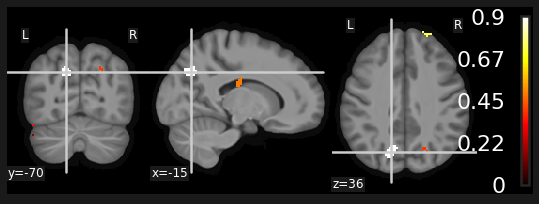

In [9]:
# visualize p values
plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/con0007_p001_clustere_corrp_tstat1.nii.gz',
                      bg_img = anat_mean,
#                       threshold = 0    
                      )

p = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/con0007_p001_clustere_corrp_tstat1.nii.gz')

p_data = p.get_data()
np.max(p_data)

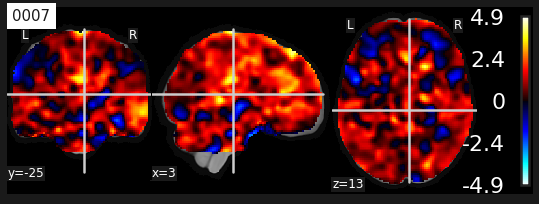

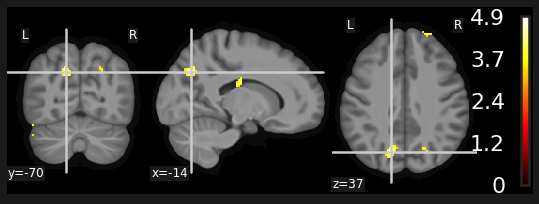

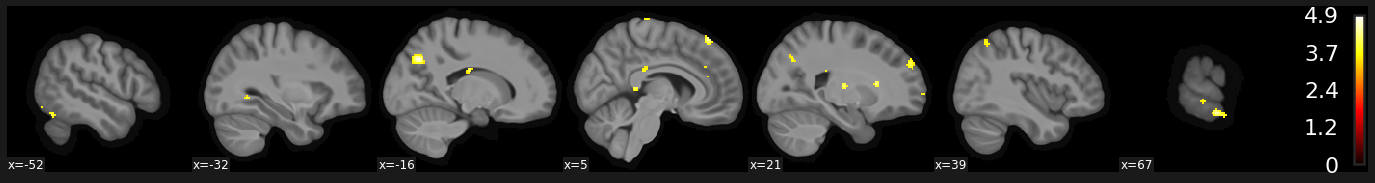

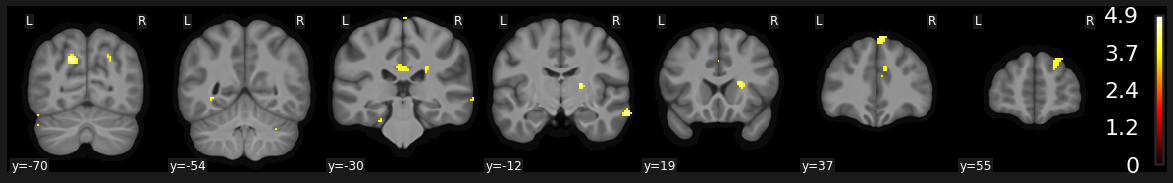

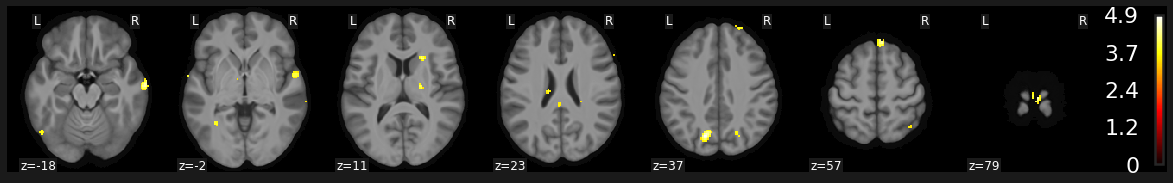

In [10]:
# visualize thresholded t values
con_ids = ['0007']
# con_ids = ['0005', '0006', '0007']

for con_id in con_ids:
    
    t_plot = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/con%s_p001_tstat1.nii.gz' %con_id)
    p = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/con%s_p001_clustere_corrp_tstat1.nii.gz' %con_id)

    # thr = 0.95
    t_plot_data = t_plot.get_data()
    p_data = p.get_data()

    # threshold raw t map by p values
    p_mask = p_data == 0
    t_plot_data[p_mask] = 0    
    
    plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/con%s_p001_tstat1.nii.gz' %con_id,
                          bg_img = anat_mean,
                          title = con_id)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="x", 
                           colorbar=True)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="y",
                           colorbar=True)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="z",
                           colorbar=True)

In [9]:
con_id = '0005'
t_plot = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/con%s_p001_tstat1.nii.gz' %con_id)

In [11]:
tmp = t_plot.get_data()

In [19]:
size = tmp.shape

In [20]:
size[0]*size[1]*size[2]

1082035

## TFCE

Positive SV maps <a class = "anchor" id = "tfce_pos-bullet"></a>

In [ ]:
# concatenate scans
# con_id = '0012'

# con_all = {}

# for i in sub_num:
#     con_image = glob.glob('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/1stLevel/_subject_id_' + str(i) + '/con_' + con_id + '.nii')
#     con_all[str(i)] = list(con_image)
# # con_all
# # len(con_all)

# # smooth, fwhm = none
# smooth_con_all = []

# for k, v in con_all.items():
#     smooth_con = image.smooth_img(v[0],None) #  If fwhm is None, no filtering is performed (useful when just removal of non-finite values is needed).
#     print(v)
#     smooth_con_all.append(smooth_con)
    
# #     plotting.plot_glass_brain(smooth_con, colorbar = True)

# # concatenate
# con_concat = image.concat_imgs(smooth_con_all, auto_resample = True)
# con_concat.to_filename(os.path.join(out_root, 'imaging', 'Sink_resp_reward', 'reward_glm_con%s_all_sub.nii.gz' %con_id))



In [52]:
con_id = '0012'
cluster_thr = fsl.Randomise(in_file = os.path.join(out_root, 'imaging', 'Sink_resp_reward', 'reward_glm_con%s_all_sub.nii.gz' %con_id),
                            mask = '/home/rj299/project/mdm_analysis/output/imaging/wb_mask_group.nii.gz',
                            base_name = os.path.join(out_root, 'imaging', 'Sink_resp_reward', 'con%s' %con_id),
                            one_sample_group_mean = True,
                            tfce = True,
                            vox_p_values = True,
                            num_perm = 5000)
cluster_thr.run()

200518-23:39:53,770 nipype.interface INFO:
	 stdout 2020-05-18T23:39:53.770295:randomise options: -i /home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/reward_glm_con0012_all_sub.nii.gz -o /home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/con0012 -m /home/rj299/project/mdm_analysis/output/imaging/wb_mask_group.nii.gz -n 5000 -1 -T -x 
200518-23:39:54,686 nipype.interface INFO:
	 stdout 2020-05-18T23:39:54.686091:Loading Data: 
200518-23:39:54,708 nipype.interface INFO:
	 stdout 2020-05-18T23:39:54.707955:Data loaded
200518-23:39:54,751 nipype.interface INFO:
	 stdout 2020-05-18T23:39:54.751617:One-sample design detected; sign-flipping instead of permuting.
200518-23:39:54,757 nipype.interface INFO:
	 stdout 2020-05-18T23:39:54.757303:8.58993e+09 sign-flips required for exhaustive test of t-test 1
200518-23:39:54,779 nipype.interface INFO:
	 stdout 2020-05-18T23:39:54.779394:Doing 5000 random permutations
200518-23:39:54,784 nipype.interface INFO:
	 stdo

200518-23:40:23,668 nipype.interface INFO:
	 stdout 2020-05-18T23:40:23.667950:Starting permutation 72
200518-23:40:24,108 nipype.interface INFO:
	 stdout 2020-05-18T23:40:24.108650:Starting permutation 73
200518-23:40:24,386 nipype.interface INFO:
	 stdout 2020-05-18T23:40:24.386108:Starting permutation 74
200518-23:40:24,650 nipype.interface INFO:
	 stdout 2020-05-18T23:40:24.650667:Starting permutation 75
200518-23:40:24,910 nipype.interface INFO:
	 stdout 2020-05-18T23:40:24.910405:Starting permutation 76
200518-23:40:25,434 nipype.interface INFO:
	 stdout 2020-05-18T23:40:25.434883:Starting permutation 77
200518-23:40:26,105 nipype.interface INFO:
	 stdout 2020-05-18T23:40:26.105380:Starting permutation 78
200518-23:40:26,604 nipype.interface INFO:
	 stdout 2020-05-18T23:40:26.604375:Starting permutation 79
200518-23:40:26,998 nipype.interface INFO:
	 stdout 2020-05-18T23:40:26.998372:Starting permutation 80
200518-23:40:27,529 nipype.interface INFO:
	 stdout 2020-05-18T23:40:27.5

200518-23:40:57,387 nipype.interface INFO:
	 stdout 2020-05-18T23:40:57.387203:Starting permutation 152
200518-23:40:57,629 nipype.interface INFO:
	 stdout 2020-05-18T23:40:57.629141:Starting permutation 153
200518-23:40:57,918 nipype.interface INFO:
	 stdout 2020-05-18T23:40:57.918684:Starting permutation 154
200518-23:40:58,346 nipype.interface INFO:
	 stdout 2020-05-18T23:40:58.345958:Starting permutation 155
200518-23:40:58,585 nipype.interface INFO:
	 stdout 2020-05-18T23:40:58.585751:Starting permutation 156
200518-23:40:59,30 nipype.interface INFO:
	 stdout 2020-05-18T23:40:59.030640:Starting permutation 157
200518-23:40:59,303 nipype.interface INFO:
	 stdout 2020-05-18T23:40:59.303915:Starting permutation 158
200518-23:40:59,594 nipype.interface INFO:
	 stdout 2020-05-18T23:40:59.594769:Starting permutation 159
200518-23:41:00,109 nipype.interface INFO:
	 stdout 2020-05-18T23:41:00.108978:Starting permutation 160
200518-23:41:00,499 nipype.interface INFO:
	 stdout 2020-05-18T23

200518-23:41:29,202 nipype.interface INFO:
	 stdout 2020-05-18T23:41:29.202910:Starting permutation 231
200518-23:41:29,822 nipype.interface INFO:
	 stdout 2020-05-18T23:41:29.822250:Starting permutation 232
200518-23:41:30,306 nipype.interface INFO:
	 stdout 2020-05-18T23:41:30.306538:Starting permutation 233
200518-23:41:30,662 nipype.interface INFO:
	 stdout 2020-05-18T23:41:30.662156:Starting permutation 234
200518-23:41:31,50 nipype.interface INFO:
	 stdout 2020-05-18T23:41:31.050167:Starting permutation 235
200518-23:41:31,495 nipype.interface INFO:
	 stdout 2020-05-18T23:41:31.495262:Starting permutation 236
200518-23:41:31,834 nipype.interface INFO:
	 stdout 2020-05-18T23:41:31.834379:Starting permutation 237
200518-23:41:32,281 nipype.interface INFO:
	 stdout 2020-05-18T23:41:32.280965:Starting permutation 238
200518-23:41:32,542 nipype.interface INFO:
	 stdout 2020-05-18T23:41:32.542182:Starting permutation 239
200518-23:41:32,929 nipype.interface INFO:
	 stdout 2020-05-18T23

200518-23:41:59,733 nipype.interface INFO:
	 stdout 2020-05-18T23:41:59.733110:Starting permutation 310
200518-23:42:00,54 nipype.interface INFO:
	 stdout 2020-05-18T23:42:00.054939:Starting permutation 311
200518-23:42:00,522 nipype.interface INFO:
	 stdout 2020-05-18T23:42:00.522559:Starting permutation 312
200518-23:42:00,809 nipype.interface INFO:
	 stdout 2020-05-18T23:42:00.809432:Starting permutation 313
200518-23:42:01,170 nipype.interface INFO:
	 stdout 2020-05-18T23:42:01.170519:Starting permutation 314
200518-23:42:01,647 nipype.interface INFO:
	 stdout 2020-05-18T23:42:01.647611:Starting permutation 315
200518-23:42:01,942 nipype.interface INFO:
	 stdout 2020-05-18T23:42:01.942172:Starting permutation 316
200518-23:42:02,338 nipype.interface INFO:
	 stdout 2020-05-18T23:42:02.338884:Starting permutation 317
200518-23:42:02,639 nipype.interface INFO:
	 stdout 2020-05-18T23:42:02.639139:Starting permutation 318
200518-23:42:02,949 nipype.interface INFO:
	 stdout 2020-05-18T23

200518-23:42:30,855 nipype.interface INFO:
	 stdout 2020-05-18T23:42:30.855796:Starting permutation 389
200518-23:42:31,187 nipype.interface INFO:
	 stdout 2020-05-18T23:42:31.187464:Starting permutation 390
200518-23:42:31,668 nipype.interface INFO:
	 stdout 2020-05-18T23:42:31.668047:Starting permutation 391
200518-23:42:32,307 nipype.interface INFO:
	 stdout 2020-05-18T23:42:32.307304:Starting permutation 392
200518-23:42:32,783 nipype.interface INFO:
	 stdout 2020-05-18T23:42:32.783908:Starting permutation 393
200518-23:42:33,228 nipype.interface INFO:
	 stdout 2020-05-18T23:42:33.228227:Starting permutation 394
200518-23:42:33,694 nipype.interface INFO:
	 stdout 2020-05-18T23:42:33.694109:Starting permutation 395
200518-23:42:34,164 nipype.interface INFO:
	 stdout 2020-05-18T23:42:34.164539:Starting permutation 396
200518-23:42:34,651 nipype.interface INFO:
	 stdout 2020-05-18T23:42:34.650969:Starting permutation 397
200518-23:42:35,225 nipype.interface INFO:
	 stdout 2020-05-18T2

200518-23:43:02,516 nipype.interface INFO:
	 stdout 2020-05-18T23:43:02.516240:Starting permutation 468
200518-23:43:02,829 nipype.interface INFO:
	 stdout 2020-05-18T23:43:02.829012:Starting permutation 469
200518-23:43:03,228 nipype.interface INFO:
	 stdout 2020-05-18T23:43:03.228498:Starting permutation 470
200518-23:43:03,541 nipype.interface INFO:
	 stdout 2020-05-18T23:43:03.540986:Starting permutation 471
200518-23:43:03,941 nipype.interface INFO:
	 stdout 2020-05-18T23:43:03.941015:Starting permutation 472
200518-23:43:04,373 nipype.interface INFO:
	 stdout 2020-05-18T23:43:04.373315:Starting permutation 473
200518-23:43:04,785 nipype.interface INFO:
	 stdout 2020-05-18T23:43:04.785888:Starting permutation 474
200518-23:43:05,209 nipype.interface INFO:
	 stdout 2020-05-18T23:43:05.209900:Starting permutation 475
200518-23:43:05,575 nipype.interface INFO:
	 stdout 2020-05-18T23:43:05.575090:Starting permutation 476
200518-23:43:05,933 nipype.interface INFO:
	 stdout 2020-05-18T2

200518-23:43:34,257 nipype.interface INFO:
	 stdout 2020-05-18T23:43:34.257053:Starting permutation 547
200518-23:43:34,616 nipype.interface INFO:
	 stdout 2020-05-18T23:43:34.616267:Starting permutation 548
200518-23:43:35,13 nipype.interface INFO:
	 stdout 2020-05-18T23:43:35.013381:Starting permutation 549
200518-23:43:35,508 nipype.interface INFO:
	 stdout 2020-05-18T23:43:35.508269:Starting permutation 550
200518-23:43:35,897 nipype.interface INFO:
	 stdout 2020-05-18T23:43:35.897503:Starting permutation 551
200518-23:43:36,176 nipype.interface INFO:
	 stdout 2020-05-18T23:43:36.176445:Starting permutation 552
200518-23:43:36,554 nipype.interface INFO:
	 stdout 2020-05-18T23:43:36.554089:Starting permutation 553
200518-23:43:36,866 nipype.interface INFO:
	 stdout 2020-05-18T23:43:36.866292:Starting permutation 554
200518-23:43:37,207 nipype.interface INFO:
	 stdout 2020-05-18T23:43:37.207537:Starting permutation 555
200518-23:43:37,714 nipype.interface INFO:
	 stdout 2020-05-18T23

200518-23:44:06,997 nipype.interface INFO:
	 stdout 2020-05-18T23:44:06.997655:Starting permutation 626
200518-23:44:07,533 nipype.interface INFO:
	 stdout 2020-05-18T23:44:07.533074:Starting permutation 627
200518-23:44:07,811 nipype.interface INFO:
	 stdout 2020-05-18T23:44:07.810995:Starting permutation 628
200518-23:44:08,156 nipype.interface INFO:
	 stdout 2020-05-18T23:44:08.156225:Starting permutation 629
200518-23:44:08,437 nipype.interface INFO:
	 stdout 2020-05-18T23:44:08.437159:Starting permutation 630
200518-23:44:08,990 nipype.interface INFO:
	 stdout 2020-05-18T23:44:08.990240:Starting permutation 631
200518-23:44:09,851 nipype.interface INFO:
	 stdout 2020-05-18T23:44:09.851247:Starting permutation 632
200518-23:44:10,287 nipype.interface INFO:
	 stdout 2020-05-18T23:44:10.287442:Starting permutation 633
200518-23:44:10,734 nipype.interface INFO:
	 stdout 2020-05-18T23:44:10.733962:Starting permutation 634
200518-23:44:11,156 nipype.interface INFO:
	 stdout 2020-05-18T2

200518-23:44:39,352 nipype.interface INFO:
	 stdout 2020-05-18T23:44:39.352694:Starting permutation 705
200518-23:44:39,734 nipype.interface INFO:
	 stdout 2020-05-18T23:44:39.734292:Starting permutation 706
200518-23:44:40,212 nipype.interface INFO:
	 stdout 2020-05-18T23:44:40.212827:Starting permutation 707
200518-23:44:40,599 nipype.interface INFO:
	 stdout 2020-05-18T23:44:40.599299:Starting permutation 708
200518-23:44:40,880 nipype.interface INFO:
	 stdout 2020-05-18T23:44:40.880657:Starting permutation 709
200518-23:44:41,188 nipype.interface INFO:
	 stdout 2020-05-18T23:44:41.188903:Starting permutation 710
200518-23:44:41,786 nipype.interface INFO:
	 stdout 2020-05-18T23:44:41.786242:Starting permutation 711
200518-23:44:42,50 nipype.interface INFO:
	 stdout 2020-05-18T23:44:42.050771:Starting permutation 712
200518-23:44:42,444 nipype.interface INFO:
	 stdout 2020-05-18T23:44:42.444186:Starting permutation 713
200518-23:44:42,840 nipype.interface INFO:
	 stdout 2020-05-18T23

200518-23:45:11,606 nipype.interface INFO:
	 stdout 2020-05-18T23:45:11.605964:Starting permutation 784
200518-23:45:12,21 nipype.interface INFO:
	 stdout 2020-05-18T23:45:12.021884:Starting permutation 785
200518-23:45:12,299 nipype.interface INFO:
	 stdout 2020-05-18T23:45:12.299228:Starting permutation 786
200518-23:45:12,757 nipype.interface INFO:
	 stdout 2020-05-18T23:45:12.756947:Starting permutation 787
200518-23:45:13,393 nipype.interface INFO:
	 stdout 2020-05-18T23:45:13.393421:Starting permutation 788
200518-23:45:13,920 nipype.interface INFO:
	 stdout 2020-05-18T23:45:13.920453:Starting permutation 789
200518-23:45:14,281 nipype.interface INFO:
	 stdout 2020-05-18T23:45:14.281904:Starting permutation 790
200518-23:45:14,552 nipype.interface INFO:
	 stdout 2020-05-18T23:45:14.552828:Starting permutation 791
200518-23:45:14,994 nipype.interface INFO:
	 stdout 2020-05-18T23:45:14.994632:Starting permutation 792
200518-23:45:15,477 nipype.interface INFO:
	 stdout 2020-05-18T23

200518-23:45:41,921 nipype.interface INFO:
	 stdout 2020-05-18T23:45:41.921176:Starting permutation 863
200518-23:45:42,228 nipype.interface INFO:
	 stdout 2020-05-18T23:45:42.228614:Starting permutation 864
200518-23:45:42,674 nipype.interface INFO:
	 stdout 2020-05-18T23:45:42.674253:Starting permutation 865
200518-23:45:43,178 nipype.interface INFO:
	 stdout 2020-05-18T23:45:43.178490:Starting permutation 866
200518-23:45:43,578 nipype.interface INFO:
	 stdout 2020-05-18T23:45:43.578117:Starting permutation 867
200518-23:45:43,952 nipype.interface INFO:
	 stdout 2020-05-18T23:45:43.952126:Starting permutation 868
200518-23:45:44,320 nipype.interface INFO:
	 stdout 2020-05-18T23:45:44.320854:Starting permutation 869
200518-23:45:44,660 nipype.interface INFO:
	 stdout 2020-05-18T23:45:44.660520:Starting permutation 870
200518-23:45:45,15 nipype.interface INFO:
	 stdout 2020-05-18T23:45:45.015872:Starting permutation 871
200518-23:45:45,402 nipype.interface INFO:
	 stdout 2020-05-18T23

200518-23:46:12,977 nipype.interface INFO:
	 stdout 2020-05-18T23:46:12.977176:Starting permutation 942
200518-23:46:13,256 nipype.interface INFO:
	 stdout 2020-05-18T23:46:13.256615:Starting permutation 943
200518-23:46:13,519 nipype.interface INFO:
	 stdout 2020-05-18T23:46:13.519456:Starting permutation 944
200518-23:46:13,781 nipype.interface INFO:
	 stdout 2020-05-18T23:46:13.781289:Starting permutation 945
200518-23:46:14,292 nipype.interface INFO:
	 stdout 2020-05-18T23:46:14.292293:Starting permutation 946
200518-23:46:14,582 nipype.interface INFO:
	 stdout 2020-05-18T23:46:14.582606:Starting permutation 947
200518-23:46:14,973 nipype.interface INFO:
	 stdout 2020-05-18T23:46:14.973461:Starting permutation 948
200518-23:46:15,183 nipype.interface INFO:
	 stdout 2020-05-18T23:46:15.183239:Starting permutation 949
200518-23:46:15,547 nipype.interface INFO:
	 stdout 2020-05-18T23:46:15.547101:Starting permutation 950
200518-23:46:15,905 nipype.interface INFO:
	 stdout 2020-05-18T2

200518-23:46:43,983 nipype.interface INFO:
	 stdout 2020-05-18T23:46:43.983003:Starting permutation 1021
200518-23:46:44,228 nipype.interface INFO:
	 stdout 2020-05-18T23:46:44.228796:Starting permutation 1022
200518-23:46:44,521 nipype.interface INFO:
	 stdout 2020-05-18T23:46:44.521933:Starting permutation 1023
200518-23:46:45,177 nipype.interface INFO:
	 stdout 2020-05-18T23:46:45.177673:Starting permutation 1024
200518-23:46:45,542 nipype.interface INFO:
	 stdout 2020-05-18T23:46:45.542550:Starting permutation 1025
200518-23:46:45,848 nipype.interface INFO:
	 stdout 2020-05-18T23:46:45.848723:Starting permutation 1026
200518-23:46:46,65 nipype.interface INFO:
	 stdout 2020-05-18T23:46:46.065335:Starting permutation 1027
200518-23:46:46,421 nipype.interface INFO:
	 stdout 2020-05-18T23:46:46.421936:Starting permutation 1028
200518-23:46:46,690 nipype.interface INFO:
	 stdout 2020-05-18T23:46:46.690451:Starting permutation 1029
200518-23:46:47,100 nipype.interface INFO:
	 stdout 2020

200518-23:47:16,627 nipype.interface INFO:
	 stdout 2020-05-18T23:47:16.627441:Starting permutation 1100
200518-23:47:16,945 nipype.interface INFO:
	 stdout 2020-05-18T23:47:16.945619:Starting permutation 1101
200518-23:47:17,441 nipype.interface INFO:
	 stdout 2020-05-18T23:47:17.441336:Starting permutation 1102
200518-23:47:17,795 nipype.interface INFO:
	 stdout 2020-05-18T23:47:17.795385:Starting permutation 1103
200518-23:47:18,185 nipype.interface INFO:
	 stdout 2020-05-18T23:47:18.185239:Starting permutation 1104
200518-23:47:18,588 nipype.interface INFO:
	 stdout 2020-05-18T23:47:18.588224:Starting permutation 1105
200518-23:47:19,183 nipype.interface INFO:
	 stdout 2020-05-18T23:47:19.183877:Starting permutation 1106
200518-23:47:19,595 nipype.interface INFO:
	 stdout 2020-05-18T23:47:19.595888:Starting permutation 1107
200518-23:47:19,937 nipype.interface INFO:
	 stdout 2020-05-18T23:47:19.937666:Starting permutation 1108
200518-23:47:20,213 nipype.interface INFO:
	 stdout 202

200518-23:47:47,746 nipype.interface INFO:
	 stdout 2020-05-18T23:47:47.746723:Starting permutation 1179
200518-23:47:48,232 nipype.interface INFO:
	 stdout 2020-05-18T23:47:48.232498:Starting permutation 1180
200518-23:47:48,696 nipype.interface INFO:
	 stdout 2020-05-18T23:47:48.696334:Starting permutation 1181
200518-23:47:49,279 nipype.interface INFO:
	 stdout 2020-05-18T23:47:49.278966:Starting permutation 1182
200518-23:47:50,26 nipype.interface INFO:
	 stdout 2020-05-18T23:47:50.025958:Starting permutation 1183
200518-23:47:50,512 nipype.interface INFO:
	 stdout 2020-05-18T23:47:50.512726:Starting permutation 1184
200518-23:47:50,813 nipype.interface INFO:
	 stdout 2020-05-18T23:47:50.813245:Starting permutation 1185
200518-23:47:51,179 nipype.interface INFO:
	 stdout 2020-05-18T23:47:51.179913:Starting permutation 1186
200518-23:47:51,706 nipype.interface INFO:
	 stdout 2020-05-18T23:47:51.706238:Starting permutation 1187
200518-23:47:52,243 nipype.interface INFO:
	 stdout 2020

200518-23:48:19,336 nipype.interface INFO:
	 stdout 2020-05-18T23:48:19.336699:Starting permutation 1258
200518-23:48:20,0 nipype.interface INFO:
	 stdout 2020-05-18T23:48:20.000174:Starting permutation 1259
200518-23:48:20,467 nipype.interface INFO:
	 stdout 2020-05-18T23:48:20.467611:Starting permutation 1260
200518-23:48:21,16 nipype.interface INFO:
	 stdout 2020-05-18T23:48:21.016065:Starting permutation 1261
200518-23:48:21,272 nipype.interface INFO:
	 stdout 2020-05-18T23:48:21.272738:Starting permutation 1262
200518-23:48:21,699 nipype.interface INFO:
	 stdout 2020-05-18T23:48:21.699303:Starting permutation 1263
200518-23:48:22,125 nipype.interface INFO:
	 stdout 2020-05-18T23:48:22.125367:Starting permutation 1264
200518-23:48:22,478 nipype.interface INFO:
	 stdout 2020-05-18T23:48:22.478235:Starting permutation 1265
200518-23:48:22,864 nipype.interface INFO:
	 stdout 2020-05-18T23:48:22.863968:Starting permutation 1266
200518-23:48:23,300 nipype.interface INFO:
	 stdout 2020-0

200518-23:48:50,968 nipype.interface INFO:
	 stdout 2020-05-18T23:48:50.968022:Starting permutation 1337
200518-23:48:51,393 nipype.interface INFO:
	 stdout 2020-05-18T23:48:51.393262:Starting permutation 1338
200518-23:48:51,660 nipype.interface INFO:
	 stdout 2020-05-18T23:48:51.660454:Starting permutation 1339
200518-23:48:51,925 nipype.interface INFO:
	 stdout 2020-05-18T23:48:51.925232:Starting permutation 1340
200518-23:48:52,317 nipype.interface INFO:
	 stdout 2020-05-18T23:48:52.317789:Starting permutation 1341
200518-23:48:52,769 nipype.interface INFO:
	 stdout 2020-05-18T23:48:52.769771:Starting permutation 1342
200518-23:48:53,4 nipype.interface INFO:
	 stdout 2020-05-18T23:48:53.004717:Starting permutation 1343
200518-23:48:53,513 nipype.interface INFO:
	 stdout 2020-05-18T23:48:53.513551:Starting permutation 1344
200518-23:48:53,761 nipype.interface INFO:
	 stdout 2020-05-18T23:48:53.761229:Starting permutation 1345
200518-23:48:54,42 nipype.interface INFO:
	 stdout 2020-0

200518-23:49:21,790 nipype.interface INFO:
	 stdout 2020-05-18T23:49:21.790429:Starting permutation 1416
200518-23:49:22,416 nipype.interface INFO:
	 stdout 2020-05-18T23:49:22.416135:Starting permutation 1417
200518-23:49:22,784 nipype.interface INFO:
	 stdout 2020-05-18T23:49:22.784574:Starting permutation 1418
200518-23:49:23,391 nipype.interface INFO:
	 stdout 2020-05-18T23:49:23.391459:Starting permutation 1419
200518-23:49:24,127 nipype.interface INFO:
	 stdout 2020-05-18T23:49:24.127406:Starting permutation 1420
200518-23:49:24,840 nipype.interface INFO:
	 stdout 2020-05-18T23:49:24.840381:Starting permutation 1421
200518-23:49:25,194 nipype.interface INFO:
	 stdout 2020-05-18T23:49:25.194290:Starting permutation 1422
200518-23:49:25,627 nipype.interface INFO:
	 stdout 2020-05-18T23:49:25.627395:Starting permutation 1423
200518-23:49:26,153 nipype.interface INFO:
	 stdout 2020-05-18T23:49:26.153613:Starting permutation 1424
200518-23:49:26,744 nipype.interface INFO:
	 stdout 202

200518-23:50:01,496 nipype.interface INFO:
	 stdout 2020-05-18T23:50:01.496203:Starting permutation 1495
200518-23:50:02,115 nipype.interface INFO:
	 stdout 2020-05-18T23:50:02.115690:Starting permutation 1496
200518-23:50:02,566 nipype.interface INFO:
	 stdout 2020-05-18T23:50:02.565949:Starting permutation 1497
200518-23:50:02,843 nipype.interface INFO:
	 stdout 2020-05-18T23:50:02.843391:Starting permutation 1498
200518-23:50:03,396 nipype.interface INFO:
	 stdout 2020-05-18T23:50:03.396342:Starting permutation 1499
200518-23:50:03,847 nipype.interface INFO:
	 stdout 2020-05-18T23:50:03.847587:Starting permutation 1500
200518-23:50:04,366 nipype.interface INFO:
	 stdout 2020-05-18T23:50:04.366245:Starting permutation 1501
200518-23:50:04,690 nipype.interface INFO:
	 stdout 2020-05-18T23:50:04.690840:Starting permutation 1502
200518-23:50:05,158 nipype.interface INFO:
	 stdout 2020-05-18T23:50:05.158398:Starting permutation 1503
200518-23:50:05,537 nipype.interface INFO:
	 stdout 202

200518-23:50:32,624 nipype.interface INFO:
	 stdout 2020-05-18T23:50:32.624388:Starting permutation 1574
200518-23:50:32,861 nipype.interface INFO:
	 stdout 2020-05-18T23:50:32.861367:Starting permutation 1575
200518-23:50:33,128 nipype.interface INFO:
	 stdout 2020-05-18T23:50:33.128885:Starting permutation 1576
200518-23:50:33,584 nipype.interface INFO:
	 stdout 2020-05-18T23:50:33.584712:Starting permutation 1577
200518-23:50:34,117 nipype.interface INFO:
	 stdout 2020-05-18T23:50:34.116946:Starting permutation 1578
200518-23:50:34,529 nipype.interface INFO:
	 stdout 2020-05-18T23:50:34.529287:Starting permutation 1579
200518-23:50:34,919 nipype.interface INFO:
	 stdout 2020-05-18T23:50:34.919644:Starting permutation 1580
200518-23:50:35,168 nipype.interface INFO:
	 stdout 2020-05-18T23:50:35.168464:Starting permutation 1581
200518-23:50:35,404 nipype.interface INFO:
	 stdout 2020-05-18T23:50:35.404881:Starting permutation 1582
200518-23:50:35,783 nipype.interface INFO:
	 stdout 202

200518-23:51:05,206 nipype.interface INFO:
	 stdout 2020-05-18T23:51:05.206927:Starting permutation 1653
200518-23:51:05,914 nipype.interface INFO:
	 stdout 2020-05-18T23:51:05.914084:Starting permutation 1654
200518-23:51:06,197 nipype.interface INFO:
	 stdout 2020-05-18T23:51:06.197285:Starting permutation 1655
200518-23:51:06,547 nipype.interface INFO:
	 stdout 2020-05-18T23:51:06.546959:Starting permutation 1656
200518-23:51:07,38 nipype.interface INFO:
	 stdout 2020-05-18T23:51:07.038606:Starting permutation 1657
200518-23:51:07,383 nipype.interface INFO:
	 stdout 2020-05-18T23:51:07.383160:Starting permutation 1658
200518-23:51:07,769 nipype.interface INFO:
	 stdout 2020-05-18T23:51:07.769024:Starting permutation 1659
200518-23:51:08,118 nipype.interface INFO:
	 stdout 2020-05-18T23:51:08.118831:Starting permutation 1660
200518-23:51:08,592 nipype.interface INFO:
	 stdout 2020-05-18T23:51:08.592526:Starting permutation 1661
200518-23:51:08,926 nipype.interface INFO:
	 stdout 2020

200518-23:51:38,493 nipype.interface INFO:
	 stdout 2020-05-18T23:51:38.493917:Starting permutation 1732
200518-23:51:38,881 nipype.interface INFO:
	 stdout 2020-05-18T23:51:38.881589:Starting permutation 1733
200518-23:51:39,304 nipype.interface INFO:
	 stdout 2020-05-18T23:51:39.304049:Starting permutation 1734
200518-23:51:39,719 nipype.interface INFO:
	 stdout 2020-05-18T23:51:39.719566:Starting permutation 1735
200518-23:51:40,109 nipype.interface INFO:
	 stdout 2020-05-18T23:51:40.109118:Starting permutation 1736
200518-23:51:40,477 nipype.interface INFO:
	 stdout 2020-05-18T23:51:40.477320:Starting permutation 1737
200518-23:51:40,838 nipype.interface INFO:
	 stdout 2020-05-18T23:51:40.838705:Starting permutation 1738
200518-23:51:41,245 nipype.interface INFO:
	 stdout 2020-05-18T23:51:41.245814:Starting permutation 1739
200518-23:51:41,628 nipype.interface INFO:
	 stdout 2020-05-18T23:51:41.628606:Starting permutation 1740
200518-23:51:41,902 nipype.interface INFO:
	 stdout 202

200518-23:52:10,991 nipype.interface INFO:
	 stdout 2020-05-18T23:52:10.991391:Starting permutation 1811
200518-23:52:11,266 nipype.interface INFO:
	 stdout 2020-05-18T23:52:11.266397:Starting permutation 1812
200518-23:52:11,758 nipype.interface INFO:
	 stdout 2020-05-18T23:52:11.758485:Starting permutation 1813
200518-23:52:12,144 nipype.interface INFO:
	 stdout 2020-05-18T23:52:12.144106:Starting permutation 1814
200518-23:52:12,523 nipype.interface INFO:
	 stdout 2020-05-18T23:52:12.523682:Starting permutation 1815
200518-23:52:12,933 nipype.interface INFO:
	 stdout 2020-05-18T23:52:12.933202:Starting permutation 1816
200518-23:52:13,436 nipype.interface INFO:
	 stdout 2020-05-18T23:52:13.436242:Starting permutation 1817
200518-23:52:13,801 nipype.interface INFO:
	 stdout 2020-05-18T23:52:13.801780:Starting permutation 1818
200518-23:52:14,172 nipype.interface INFO:
	 stdout 2020-05-18T23:52:14.172238:Starting permutation 1819
200518-23:52:14,537 nipype.interface INFO:
	 stdout 202

200518-23:52:42,185 nipype.interface INFO:
	 stdout 2020-05-18T23:52:42.185490:Starting permutation 1890
200518-23:52:42,498 nipype.interface INFO:
	 stdout 2020-05-18T23:52:42.498314:Starting permutation 1891
200518-23:52:42,938 nipype.interface INFO:
	 stdout 2020-05-18T23:52:42.938279:Starting permutation 1892
200518-23:52:43,494 nipype.interface INFO:
	 stdout 2020-05-18T23:52:43.494204:Starting permutation 1893
200518-23:52:43,738 nipype.interface INFO:
	 stdout 2020-05-18T23:52:43.738602:Starting permutation 1894
200518-23:52:44,208 nipype.interface INFO:
	 stdout 2020-05-18T23:52:44.208064:Starting permutation 1895
200518-23:52:44,578 nipype.interface INFO:
	 stdout 2020-05-18T23:52:44.578867:Starting permutation 1896
200518-23:52:44,803 nipype.interface INFO:
	 stdout 2020-05-18T23:52:44.802953:Starting permutation 1897
200518-23:52:45,195 nipype.interface INFO:
	 stdout 2020-05-18T23:52:45.195185:Starting permutation 1898
200518-23:52:45,609 nipype.interface INFO:
	 stdout 202

200518-23:53:13,946 nipype.interface INFO:
	 stdout 2020-05-18T23:53:13.946257:Starting permutation 1969
200518-23:53:14,414 nipype.interface INFO:
	 stdout 2020-05-18T23:53:14.414913:Starting permutation 1970
200518-23:53:14,876 nipype.interface INFO:
	 stdout 2020-05-18T23:53:14.875953:Starting permutation 1971
200518-23:53:15,255 nipype.interface INFO:
	 stdout 2020-05-18T23:53:15.255379:Starting permutation 1972
200518-23:53:15,507 nipype.interface INFO:
	 stdout 2020-05-18T23:53:15.507921:Starting permutation 1973
200518-23:53:16,120 nipype.interface INFO:
	 stdout 2020-05-18T23:53:16.120223:Starting permutation 1974
200518-23:53:16,485 nipype.interface INFO:
	 stdout 2020-05-18T23:53:16.485612:Starting permutation 1975
200518-23:53:16,889 nipype.interface INFO:
	 stdout 2020-05-18T23:53:16.889457:Starting permutation 1976
200518-23:53:17,316 nipype.interface INFO:
	 stdout 2020-05-18T23:53:17.316605:Starting permutation 1977
200518-23:53:17,794 nipype.interface INFO:
	 stdout 202

200518-23:53:45,998 nipype.interface INFO:
	 stdout 2020-05-18T23:53:45.998129:Starting permutation 2048
200518-23:53:46,308 nipype.interface INFO:
	 stdout 2020-05-18T23:53:46.308464:Starting permutation 2049
200518-23:53:46,575 nipype.interface INFO:
	 stdout 2020-05-18T23:53:46.575764:Starting permutation 2050
200518-23:53:47,59 nipype.interface INFO:
	 stdout 2020-05-18T23:53:47.059659:Starting permutation 2051
200518-23:53:47,397 nipype.interface INFO:
	 stdout 2020-05-18T23:53:47.397682:Starting permutation 2052
200518-23:53:47,869 nipype.interface INFO:
	 stdout 2020-05-18T23:53:47.869675:Starting permutation 2053
200518-23:53:48,208 nipype.interface INFO:
	 stdout 2020-05-18T23:53:48.208767:Starting permutation 2054
200518-23:53:48,535 nipype.interface INFO:
	 stdout 2020-05-18T23:53:48.535456:Starting permutation 2055
200518-23:53:48,913 nipype.interface INFO:
	 stdout 2020-05-18T23:53:48.913397:Starting permutation 2056
200518-23:53:49,445 nipype.interface INFO:
	 stdout 2020

200518-23:54:17,617 nipype.interface INFO:
	 stdout 2020-05-18T23:54:17.617816:Starting permutation 2127
200518-23:54:18,60 nipype.interface INFO:
	 stdout 2020-05-18T23:54:18.060427:Starting permutation 2128
200518-23:54:18,384 nipype.interface INFO:
	 stdout 2020-05-18T23:54:18.383953:Starting permutation 2129
200518-23:54:18,789 nipype.interface INFO:
	 stdout 2020-05-18T23:54:18.789885:Starting permutation 2130
200518-23:54:19,249 nipype.interface INFO:
	 stdout 2020-05-18T23:54:19.249328:Starting permutation 2131
200518-23:54:19,599 nipype.interface INFO:
	 stdout 2020-05-18T23:54:19.599317:Starting permutation 2132
200518-23:54:19,993 nipype.interface INFO:
	 stdout 2020-05-18T23:54:19.993592:Starting permutation 2133
200518-23:54:20,253 nipype.interface INFO:
	 stdout 2020-05-18T23:54:20.253521:Starting permutation 2134
200518-23:54:20,542 nipype.interface INFO:
	 stdout 2020-05-18T23:54:20.542879:Starting permutation 2135
200518-23:54:20,900 nipype.interface INFO:
	 stdout 2020

200518-23:54:49,840 nipype.interface INFO:
	 stdout 2020-05-18T23:54:49.840507:Starting permutation 2206
200518-23:54:50,405 nipype.interface INFO:
	 stdout 2020-05-18T23:54:50.405250:Starting permutation 2207
200518-23:54:50,823 nipype.interface INFO:
	 stdout 2020-05-18T23:54:50.823761:Starting permutation 2208
200518-23:54:51,385 nipype.interface INFO:
	 stdout 2020-05-18T23:54:51.385278:Starting permutation 2209
200518-23:54:51,693 nipype.interface INFO:
	 stdout 2020-05-18T23:54:51.693768:Starting permutation 2210
200518-23:54:52,336 nipype.interface INFO:
	 stdout 2020-05-18T23:54:52.336232:Starting permutation 2211
200518-23:54:52,731 nipype.interface INFO:
	 stdout 2020-05-18T23:54:52.731459:Starting permutation 2212
200518-23:54:53,71 nipype.interface INFO:
	 stdout 2020-05-18T23:54:53.071751:Starting permutation 2213
200518-23:54:53,427 nipype.interface INFO:
	 stdout 2020-05-18T23:54:53.427814:Starting permutation 2214
200518-23:54:53,954 nipype.interface INFO:
	 stdout 2020

200518-23:55:22,202 nipype.interface INFO:
	 stdout 2020-05-18T23:55:22.202470:Starting permutation 2285
200518-23:55:22,626 nipype.interface INFO:
	 stdout 2020-05-18T23:55:22.626354:Starting permutation 2286
200518-23:55:23,36 nipype.interface INFO:
	 stdout 2020-05-18T23:55:23.036679:Starting permutation 2287
200518-23:55:23,377 nipype.interface INFO:
	 stdout 2020-05-18T23:55:23.377833:Starting permutation 2288
200518-23:55:23,823 nipype.interface INFO:
	 stdout 2020-05-18T23:55:23.823611:Starting permutation 2289
200518-23:55:24,237 nipype.interface INFO:
	 stdout 2020-05-18T23:55:24.237371:Starting permutation 2290
200518-23:55:24,596 nipype.interface INFO:
	 stdout 2020-05-18T23:55:24.596582:Starting permutation 2291
200518-23:55:24,871 nipype.interface INFO:
	 stdout 2020-05-18T23:55:24.871407:Starting permutation 2292
200518-23:55:25,432 nipype.interface INFO:
	 stdout 2020-05-18T23:55:25.432674:Starting permutation 2293
200518-23:55:25,901 nipype.interface INFO:
	 stdout 2020

200518-23:55:54,923 nipype.interface INFO:
	 stdout 2020-05-18T23:55:54.923798:Starting permutation 2364
200518-23:55:55,362 nipype.interface INFO:
	 stdout 2020-05-18T23:55:55.362031:Starting permutation 2365
200518-23:55:55,924 nipype.interface INFO:
	 stdout 2020-05-18T23:55:55.924013:Starting permutation 2366
200518-23:55:56,261 nipype.interface INFO:
	 stdout 2020-05-18T23:55:56.261439:Starting permutation 2367
200518-23:55:56,647 nipype.interface INFO:
	 stdout 2020-05-18T23:55:56.647000:Starting permutation 2368
200518-23:55:56,975 nipype.interface INFO:
	 stdout 2020-05-18T23:55:56.975403:Starting permutation 2369
200518-23:55:57,381 nipype.interface INFO:
	 stdout 2020-05-18T23:55:57.381544:Starting permutation 2370
200518-23:55:57,699 nipype.interface INFO:
	 stdout 2020-05-18T23:55:57.699321:Starting permutation 2371
200518-23:55:57,979 nipype.interface INFO:
	 stdout 2020-05-18T23:55:57.979834:Starting permutation 2372
200518-23:55:58,420 nipype.interface INFO:
	 stdout 202

200518-23:56:26,270 nipype.interface INFO:
	 stdout 2020-05-18T23:56:26.270073:Starting permutation 2443
200518-23:56:26,560 nipype.interface INFO:
	 stdout 2020-05-18T23:56:26.560041:Starting permutation 2444
200518-23:56:26,920 nipype.interface INFO:
	 stdout 2020-05-18T23:56:26.920385:Starting permutation 2445
200518-23:56:27,460 nipype.interface INFO:
	 stdout 2020-05-18T23:56:27.460370:Starting permutation 2446
200518-23:56:27,995 nipype.interface INFO:
	 stdout 2020-05-18T23:56:27.995545:Starting permutation 2447
200518-23:56:28,543 nipype.interface INFO:
	 stdout 2020-05-18T23:56:28.543923:Starting permutation 2448
200518-23:56:28,815 nipype.interface INFO:
	 stdout 2020-05-18T23:56:28.815542:Starting permutation 2449
200518-23:56:29,429 nipype.interface INFO:
	 stdout 2020-05-18T23:56:29.429633:Starting permutation 2450
200518-23:56:29,888 nipype.interface INFO:
	 stdout 2020-05-18T23:56:29.888561:Starting permutation 2451
200518-23:56:30,426 nipype.interface INFO:
	 stdout 202

200518-23:56:59,636 nipype.interface INFO:
	 stdout 2020-05-18T23:56:59.636811:Starting permutation 2522
200518-23:56:59,961 nipype.interface INFO:
	 stdout 2020-05-18T23:56:59.961416:Starting permutation 2523
200518-23:57:00,401 nipype.interface INFO:
	 stdout 2020-05-18T23:57:00.400992:Starting permutation 2524
200518-23:57:00,731 nipype.interface INFO:
	 stdout 2020-05-18T23:57:00.731286:Starting permutation 2525
200518-23:57:01,72 nipype.interface INFO:
	 stdout 2020-05-18T23:57:01.072105:Starting permutation 2526
200518-23:57:01,329 nipype.interface INFO:
	 stdout 2020-05-18T23:57:01.329726:Starting permutation 2527
200518-23:57:01,883 nipype.interface INFO:
	 stdout 2020-05-18T23:57:01.883917:Starting permutation 2528
200518-23:57:02,309 nipype.interface INFO:
	 stdout 2020-05-18T23:57:02.309087:Starting permutation 2529
200518-23:57:02,618 nipype.interface INFO:
	 stdout 2020-05-18T23:57:02.618835:Starting permutation 2530
200518-23:57:02,916 nipype.interface INFO:
	 stdout 2020

200518-23:57:32,816 nipype.interface INFO:
	 stdout 2020-05-18T23:57:32.816542:Starting permutation 2601
200518-23:57:33,149 nipype.interface INFO:
	 stdout 2020-05-18T23:57:33.148963:Starting permutation 2602
200518-23:57:33,634 nipype.interface INFO:
	 stdout 2020-05-18T23:57:33.634021:Starting permutation 2603
200518-23:57:33,960 nipype.interface INFO:
	 stdout 2020-05-18T23:57:33.959976:Starting permutation 2604
200518-23:57:34,521 nipype.interface INFO:
	 stdout 2020-05-18T23:57:34.521819:Starting permutation 2605
200518-23:57:35,86 nipype.interface INFO:
	 stdout 2020-05-18T23:57:35.086756:Starting permutation 2606
200518-23:57:35,355 nipype.interface INFO:
	 stdout 2020-05-18T23:57:35.355366:Starting permutation 2607
200518-23:57:35,707 nipype.interface INFO:
	 stdout 2020-05-18T23:57:35.707644:Starting permutation 2608
200518-23:57:36,345 nipype.interface INFO:
	 stdout 2020-05-18T23:57:36.345921:Starting permutation 2609
200518-23:57:36,723 nipype.interface INFO:
	 stdout 2020

200518-23:58:04,296 nipype.interface INFO:
	 stdout 2020-05-18T23:58:04.296186:Starting permutation 2680
200518-23:58:04,772 nipype.interface INFO:
	 stdout 2020-05-18T23:58:04.771990:Starting permutation 2681
200518-23:58:05,145 nipype.interface INFO:
	 stdout 2020-05-18T23:58:05.145825:Starting permutation 2682
200518-23:58:05,657 nipype.interface INFO:
	 stdout 2020-05-18T23:58:05.657059:Starting permutation 2683
200518-23:58:05,928 nipype.interface INFO:
	 stdout 2020-05-18T23:58:05.928914:Starting permutation 2684
200518-23:58:06,461 nipype.interface INFO:
	 stdout 2020-05-18T23:58:06.461093:Starting permutation 2685
200518-23:58:06,895 nipype.interface INFO:
	 stdout 2020-05-18T23:58:06.895739:Starting permutation 2686
200518-23:58:07,357 nipype.interface INFO:
	 stdout 2020-05-18T23:58:07.357586:Starting permutation 2687
200518-23:58:07,625 nipype.interface INFO:
	 stdout 2020-05-18T23:58:07.625074:Starting permutation 2688
200518-23:58:08,22 nipype.interface INFO:
	 stdout 2020

200518-23:58:35,187 nipype.interface INFO:
	 stdout 2020-05-18T23:58:35.187352:Starting permutation 2759
200518-23:58:35,620 nipype.interface INFO:
	 stdout 2020-05-18T23:58:35.619981:Starting permutation 2760
200518-23:58:35,942 nipype.interface INFO:
	 stdout 2020-05-18T23:58:35.942846:Starting permutation 2761
200518-23:58:36,192 nipype.interface INFO:
	 stdout 2020-05-18T23:58:36.192714:Starting permutation 2762
200518-23:58:36,684 nipype.interface INFO:
	 stdout 2020-05-18T23:58:36.684505:Starting permutation 2763
200518-23:58:37,18 nipype.interface INFO:
	 stdout 2020-05-18T23:58:37.018937:Starting permutation 2764
200518-23:58:37,454 nipype.interface INFO:
	 stdout 2020-05-18T23:58:37.454256:Starting permutation 2765
200518-23:58:38,10 nipype.interface INFO:
	 stdout 2020-05-18T23:58:38.010729:Starting permutation 2766
200518-23:58:38,422 nipype.interface INFO:
	 stdout 2020-05-18T23:58:38.422490:Starting permutation 2767
200518-23:58:38,874 nipype.interface INFO:
	 stdout 2020-

200518-23:59:05,542 nipype.interface INFO:
	 stdout 2020-05-18T23:59:05.542495:Starting permutation 2838
200518-23:59:05,894 nipype.interface INFO:
	 stdout 2020-05-18T23:59:05.894549:Starting permutation 2839
200518-23:59:06,218 nipype.interface INFO:
	 stdout 2020-05-18T23:59:06.218209:Starting permutation 2840
200518-23:59:06,528 nipype.interface INFO:
	 stdout 2020-05-18T23:59:06.528225:Starting permutation 2841
200518-23:59:06,873 nipype.interface INFO:
	 stdout 2020-05-18T23:59:06.872971:Starting permutation 2842
200518-23:59:07,230 nipype.interface INFO:
	 stdout 2020-05-18T23:59:07.230678:Starting permutation 2843
200518-23:59:07,652 nipype.interface INFO:
	 stdout 2020-05-18T23:59:07.652078:Starting permutation 2844
200518-23:59:08,74 nipype.interface INFO:
	 stdout 2020-05-18T23:59:08.074000:Starting permutation 2845
200518-23:59:08,554 nipype.interface INFO:
	 stdout 2020-05-18T23:59:08.554544:Starting permutation 2846
200518-23:59:08,829 nipype.interface INFO:
	 stdout 2020

200518-23:59:36,508 nipype.interface INFO:
	 stdout 2020-05-18T23:59:36.508833:Starting permutation 2917
200518-23:59:36,791 nipype.interface INFO:
	 stdout 2020-05-18T23:59:36.791582:Starting permutation 2918
200518-23:59:37,227 nipype.interface INFO:
	 stdout 2020-05-18T23:59:37.227700:Starting permutation 2919
200518-23:59:37,651 nipype.interface INFO:
	 stdout 2020-05-18T23:59:37.651186:Starting permutation 2920
200518-23:59:38,75 nipype.interface INFO:
	 stdout 2020-05-18T23:59:38.075794:Starting permutation 2921
200518-23:59:38,369 nipype.interface INFO:
	 stdout 2020-05-18T23:59:38.369736:Starting permutation 2922
200518-23:59:38,761 nipype.interface INFO:
	 stdout 2020-05-18T23:59:38.761241:Starting permutation 2923
200518-23:59:39,81 nipype.interface INFO:
	 stdout 2020-05-18T23:59:39.081253:Starting permutation 2924
200518-23:59:39,345 nipype.interface INFO:
	 stdout 2020-05-18T23:59:39.345065:Starting permutation 2925
200518-23:59:39,787 nipype.interface INFO:
	 stdout 2020-

200519-00:00:09,670 nipype.interface INFO:
	 stdout 2020-05-19T00:00:09.670370:Starting permutation 2996
200519-00:00:10,305 nipype.interface INFO:
	 stdout 2020-05-19T00:00:10.305512:Starting permutation 2997
200519-00:00:10,578 nipype.interface INFO:
	 stdout 2020-05-19T00:00:10.578193:Starting permutation 2998
200519-00:00:11,17 nipype.interface INFO:
	 stdout 2020-05-19T00:00:11.017277:Starting permutation 2999
200519-00:00:11,290 nipype.interface INFO:
	 stdout 2020-05-19T00:00:11.290543:Starting permutation 3000
200519-00:00:11,652 nipype.interface INFO:
	 stdout 2020-05-19T00:00:11.652868:Starting permutation 3001
200519-00:00:12,99 nipype.interface INFO:
	 stdout 2020-05-19T00:00:12.099056:Starting permutation 3002
200519-00:00:12,488 nipype.interface INFO:
	 stdout 2020-05-19T00:00:12.488453:Starting permutation 3003
200519-00:00:12,774 nipype.interface INFO:
	 stdout 2020-05-19T00:00:12.774766:Starting permutation 3004
200519-00:00:13,178 nipype.interface INFO:
	 stdout 2020-

200519-00:00:45,210 nipype.interface INFO:
	 stdout 2020-05-19T00:00:45.210475:Starting permutation 3075
200519-00:00:45,623 nipype.interface INFO:
	 stdout 2020-05-19T00:00:45.623353:Starting permutation 3076
200519-00:00:45,942 nipype.interface INFO:
	 stdout 2020-05-19T00:00:45.942519:Starting permutation 3077
200519-00:00:46,278 nipype.interface INFO:
	 stdout 2020-05-19T00:00:46.278712:Starting permutation 3078
200519-00:00:46,673 nipype.interface INFO:
	 stdout 2020-05-19T00:00:46.673834:Starting permutation 3079
200519-00:00:46,902 nipype.interface INFO:
	 stdout 2020-05-19T00:00:46.902557:Starting permutation 3080
200519-00:00:47,251 nipype.interface INFO:
	 stdout 2020-05-19T00:00:47.251423:Starting permutation 3081
200519-00:00:47,806 nipype.interface INFO:
	 stdout 2020-05-19T00:00:47.806439:Starting permutation 3082
200519-00:00:48,182 nipype.interface INFO:
	 stdout 2020-05-19T00:00:48.182747:Starting permutation 3083
200519-00:00:48,454 nipype.interface INFO:
	 stdout 202

200519-00:01:15,577 nipype.interface INFO:
	 stdout 2020-05-19T00:01:15.577086:Starting permutation 3154
200519-00:01:16,38 nipype.interface INFO:
	 stdout 2020-05-19T00:01:16.038444:Starting permutation 3155
200519-00:01:16,420 nipype.interface INFO:
	 stdout 2020-05-19T00:01:16.420454:Starting permutation 3156
200519-00:01:16,895 nipype.interface INFO:
	 stdout 2020-05-19T00:01:16.895399:Starting permutation 3157
200519-00:01:17,178 nipype.interface INFO:
	 stdout 2020-05-19T00:01:17.178452:Starting permutation 3158
200519-00:01:17,714 nipype.interface INFO:
	 stdout 2020-05-19T00:01:17.714419:Starting permutation 3159
200519-00:01:18,95 nipype.interface INFO:
	 stdout 2020-05-19T00:01:18.095675:Starting permutation 3160
200519-00:01:18,463 nipype.interface INFO:
	 stdout 2020-05-19T00:01:18.462991:Starting permutation 3161
200519-00:01:18,788 nipype.interface INFO:
	 stdout 2020-05-19T00:01:18.788487:Starting permutation 3162
200519-00:01:19,350 nipype.interface INFO:
	 stdout 2020-

200519-00:01:46,657 nipype.interface INFO:
	 stdout 2020-05-19T00:01:46.657918:Starting permutation 3233
200519-00:01:46,955 nipype.interface INFO:
	 stdout 2020-05-19T00:01:46.955879:Starting permutation 3234
200519-00:01:47,256 nipype.interface INFO:
	 stdout 2020-05-19T00:01:47.256729:Starting permutation 3235
200519-00:01:47,535 nipype.interface INFO:
	 stdout 2020-05-19T00:01:47.535224:Starting permutation 3236
200519-00:01:48,20 nipype.interface INFO:
	 stdout 2020-05-19T00:01:48.020387:Starting permutation 3237
200519-00:01:48,368 nipype.interface INFO:
	 stdout 2020-05-19T00:01:48.368577:Starting permutation 3238
200519-00:01:48,629 nipype.interface INFO:
	 stdout 2020-05-19T00:01:48.629227:Starting permutation 3239
200519-00:01:48,852 nipype.interface INFO:
	 stdout 2020-05-19T00:01:48.852486:Starting permutation 3240
200519-00:01:49,869 nipype.interface INFO:
	 stdout 2020-05-19T00:01:49.869866:Starting permutation 3241
200519-00:01:50,348 nipype.interface INFO:
	 stdout 2020

200519-00:02:15,938 nipype.interface INFO:
	 stdout 2020-05-19T00:02:15.938352:Starting permutation 3312
200519-00:02:16,266 nipype.interface INFO:
	 stdout 2020-05-19T00:02:16.266632:Starting permutation 3313
200519-00:02:16,751 nipype.interface INFO:
	 stdout 2020-05-19T00:02:16.751908:Starting permutation 3314
200519-00:02:17,138 nipype.interface INFO:
	 stdout 2020-05-19T00:02:17.138436:Starting permutation 3315
200519-00:02:17,688 nipype.interface INFO:
	 stdout 2020-05-19T00:02:17.688331:Starting permutation 3316
200519-00:02:17,896 nipype.interface INFO:
	 stdout 2020-05-19T00:02:17.896674:Starting permutation 3317
200519-00:02:18,285 nipype.interface INFO:
	 stdout 2020-05-19T00:02:18.285238:Starting permutation 3318
200519-00:02:18,571 nipype.interface INFO:
	 stdout 2020-05-19T00:02:18.571757:Starting permutation 3319
200519-00:02:19,254 nipype.interface INFO:
	 stdout 2020-05-19T00:02:19.254352:Starting permutation 3320
200519-00:02:19,678 nipype.interface INFO:
	 stdout 202

200519-00:02:45,290 nipype.interface INFO:
	 stdout 2020-05-19T00:02:45.289949:Starting permutation 3391
200519-00:02:45,493 nipype.interface INFO:
	 stdout 2020-05-19T00:02:45.493628:Starting permutation 3392
200519-00:02:45,769 nipype.interface INFO:
	 stdout 2020-05-19T00:02:45.769645:Starting permutation 3393
200519-00:02:46,263 nipype.interface INFO:
	 stdout 2020-05-19T00:02:46.263247:Starting permutation 3394
200519-00:02:46,582 nipype.interface INFO:
	 stdout 2020-05-19T00:02:46.582628:Starting permutation 3395
200519-00:02:46,942 nipype.interface INFO:
	 stdout 2020-05-19T00:02:46.942486:Starting permutation 3396
200519-00:02:47,300 nipype.interface INFO:
	 stdout 2020-05-19T00:02:47.300010:Starting permutation 3397
200519-00:02:47,547 nipype.interface INFO:
	 stdout 2020-05-19T00:02:47.547909:Starting permutation 3398
200519-00:02:47,907 nipype.interface INFO:
	 stdout 2020-05-19T00:02:47.906965:Starting permutation 3399
200519-00:02:48,319 nipype.interface INFO:
	 stdout 202

200519-00:03:15,175 nipype.interface INFO:
	 stdout 2020-05-19T00:03:15.175394:Starting permutation 3470
200519-00:03:15,601 nipype.interface INFO:
	 stdout 2020-05-19T00:03:15.601402:Starting permutation 3471
200519-00:03:15,907 nipype.interface INFO:
	 stdout 2020-05-19T00:03:15.907602:Starting permutation 3472
200519-00:03:16,341 nipype.interface INFO:
	 stdout 2020-05-19T00:03:16.341725:Starting permutation 3473
200519-00:03:16,678 nipype.interface INFO:
	 stdout 2020-05-19T00:03:16.678065:Starting permutation 3474
200519-00:03:17,159 nipype.interface INFO:
	 stdout 2020-05-19T00:03:17.159115:Starting permutation 3475
200519-00:03:17,449 nipype.interface INFO:
	 stdout 2020-05-19T00:03:17.449594:Starting permutation 3476
200519-00:03:17,738 nipype.interface INFO:
	 stdout 2020-05-19T00:03:17.738181:Starting permutation 3477
200519-00:03:18,93 nipype.interface INFO:
	 stdout 2020-05-19T00:03:18.092959:Starting permutation 3478
200519-00:03:18,364 nipype.interface INFO:
	 stdout 2020

200519-00:03:43,714 nipype.interface INFO:
	 stdout 2020-05-19T00:03:43.714933:Starting permutation 3549
200519-00:03:44,379 nipype.interface INFO:
	 stdout 2020-05-19T00:03:44.379154:Starting permutation 3550
200519-00:03:44,666 nipype.interface INFO:
	 stdout 2020-05-19T00:03:44.666223:Starting permutation 3551
200519-00:03:45,176 nipype.interface INFO:
	 stdout 2020-05-19T00:03:45.176678:Starting permutation 3552
200519-00:03:45,542 nipype.interface INFO:
	 stdout 2020-05-19T00:03:45.542309:Starting permutation 3553
200519-00:03:45,962 nipype.interface INFO:
	 stdout 2020-05-19T00:03:45.962741:Starting permutation 3554
200519-00:03:46,370 nipype.interface INFO:
	 stdout 2020-05-19T00:03:46.370561:Starting permutation 3555
200519-00:03:46,718 nipype.interface INFO:
	 stdout 2020-05-19T00:03:46.718336:Starting permutation 3556
200519-00:03:47,9 nipype.interface INFO:
	 stdout 2020-05-19T00:03:47.009865:Starting permutation 3557
200519-00:03:47,384 nipype.interface INFO:
	 stdout 2020-

200519-00:04:13,666 nipype.interface INFO:
	 stdout 2020-05-19T00:04:13.666451:Starting permutation 3628
200519-00:04:14,33 nipype.interface INFO:
	 stdout 2020-05-19T00:04:14.033389:Starting permutation 3629
200519-00:04:14,302 nipype.interface INFO:
	 stdout 2020-05-19T00:04:14.301993:Starting permutation 3630
200519-00:04:14,813 nipype.interface INFO:
	 stdout 2020-05-19T00:04:14.813521:Starting permutation 3631
200519-00:04:15,88 nipype.interface INFO:
	 stdout 2020-05-19T00:04:15.088876:Starting permutation 3632
200519-00:04:15,454 nipype.interface INFO:
	 stdout 2020-05-19T00:04:15.454563:Starting permutation 3633
200519-00:04:15,711 nipype.interface INFO:
	 stdout 2020-05-19T00:04:15.710964:Starting permutation 3634
200519-00:04:16,23 nipype.interface INFO:
	 stdout 2020-05-19T00:04:16.023458:Starting permutation 3635
200519-00:04:16,496 nipype.interface INFO:
	 stdout 2020-05-19T00:04:16.496525:Starting permutation 3636
200519-00:04:16,865 nipype.interface INFO:
	 stdout 2020-0

200519-00:04:43,330 nipype.interface INFO:
	 stdout 2020-05-19T00:04:43.330556:Starting permutation 3707
200519-00:04:43,680 nipype.interface INFO:
	 stdout 2020-05-19T00:04:43.680078:Starting permutation 3708
200519-00:04:44,303 nipype.interface INFO:
	 stdout 2020-05-19T00:04:44.303764:Starting permutation 3709
200519-00:04:44,606 nipype.interface INFO:
	 stdout 2020-05-19T00:04:44.606889:Starting permutation 3710
200519-00:04:45,64 nipype.interface INFO:
	 stdout 2020-05-19T00:04:45.064824:Starting permutation 3711
200519-00:04:45,381 nipype.interface INFO:
	 stdout 2020-05-19T00:04:45.381202:Starting permutation 3712
200519-00:04:45,649 nipype.interface INFO:
	 stdout 2020-05-19T00:04:45.649040:Starting permutation 3713
200519-00:04:46,59 nipype.interface INFO:
	 stdout 2020-05-19T00:04:46.059619:Starting permutation 3714
200519-00:04:46,368 nipype.interface INFO:
	 stdout 2020-05-19T00:04:46.367955:Starting permutation 3715
200519-00:04:46,651 nipype.interface INFO:
	 stdout 2020-

200519-00:05:13,614 nipype.interface INFO:
	 stdout 2020-05-19T00:05:13.614687:Starting permutation 3786
200519-00:05:14,53 nipype.interface INFO:
	 stdout 2020-05-19T00:05:14.053881:Starting permutation 3787
200519-00:05:14,290 nipype.interface INFO:
	 stdout 2020-05-19T00:05:14.290008:Starting permutation 3788
200519-00:05:14,760 nipype.interface INFO:
	 stdout 2020-05-19T00:05:14.760202:Starting permutation 3789
200519-00:05:15,77 nipype.interface INFO:
	 stdout 2020-05-19T00:05:15.077273:Starting permutation 3790
200519-00:05:15,478 nipype.interface INFO:
	 stdout 2020-05-19T00:05:15.478471:Starting permutation 3791
200519-00:05:15,915 nipype.interface INFO:
	 stdout 2020-05-19T00:05:15.915525:Starting permutation 3792
200519-00:05:16,307 nipype.interface INFO:
	 stdout 2020-05-19T00:05:16.307667:Starting permutation 3793
200519-00:05:16,804 nipype.interface INFO:
	 stdout 2020-05-19T00:05:16.804536:Starting permutation 3794
200519-00:05:17,123 nipype.interface INFO:
	 stdout 2020-

200519-00:05:44,244 nipype.interface INFO:
	 stdout 2020-05-19T00:05:44.244376:Starting permutation 3865
200519-00:05:44,456 nipype.interface INFO:
	 stdout 2020-05-19T00:05:44.456792:Starting permutation 3866
200519-00:05:44,770 nipype.interface INFO:
	 stdout 2020-05-19T00:05:44.770718:Starting permutation 3867
200519-00:05:45,170 nipype.interface INFO:
	 stdout 2020-05-19T00:05:45.170471:Starting permutation 3868
200519-00:05:45,468 nipype.interface INFO:
	 stdout 2020-05-19T00:05:45.468752:Starting permutation 3869
200519-00:05:45,935 nipype.interface INFO:
	 stdout 2020-05-19T00:05:45.934978:Starting permutation 3870
200519-00:05:46,190 nipype.interface INFO:
	 stdout 2020-05-19T00:05:46.190213:Starting permutation 3871
200519-00:05:46,638 nipype.interface INFO:
	 stdout 2020-05-19T00:05:46.638415:Starting permutation 3872
200519-00:05:47,18 nipype.interface INFO:
	 stdout 2020-05-19T00:05:47.018362:Starting permutation 3873
200519-00:05:47,242 nipype.interface INFO:
	 stdout 2020

200519-00:06:14,273 nipype.interface INFO:
	 stdout 2020-05-19T00:06:14.273202:Starting permutation 3944
200519-00:06:14,746 nipype.interface INFO:
	 stdout 2020-05-19T00:06:14.746434:Starting permutation 3945
200519-00:06:15,80 nipype.interface INFO:
	 stdout 2020-05-19T00:06:15.080256:Starting permutation 3946
200519-00:06:15,434 nipype.interface INFO:
	 stdout 2020-05-19T00:06:15.434669:Starting permutation 3947
200519-00:06:15,911 nipype.interface INFO:
	 stdout 2020-05-19T00:06:15.911756:Starting permutation 3948
200519-00:06:16,418 nipype.interface INFO:
	 stdout 2020-05-19T00:06:16.418746:Starting permutation 3949
200519-00:06:16,928 nipype.interface INFO:
	 stdout 2020-05-19T00:06:16.928076:Starting permutation 3950
200519-00:06:17,416 nipype.interface INFO:
	 stdout 2020-05-19T00:06:17.416420:Starting permutation 3951
200519-00:06:17,738 nipype.interface INFO:
	 stdout 2020-05-19T00:06:17.738624:Starting permutation 3952
200519-00:06:18,92 nipype.interface INFO:
	 stdout 2020-

200519-00:06:46,189 nipype.interface INFO:
	 stdout 2020-05-19T00:06:46.189318:Starting permutation 4023
200519-00:06:46,714 nipype.interface INFO:
	 stdout 2020-05-19T00:06:46.714020:Starting permutation 4024
200519-00:06:47,72 nipype.interface INFO:
	 stdout 2020-05-19T00:06:47.072207:Starting permutation 4025
200519-00:06:47,500 nipype.interface INFO:
	 stdout 2020-05-19T00:06:47.500721:Starting permutation 4026
200519-00:06:47,999 nipype.interface INFO:
	 stdout 2020-05-19T00:06:47.999000:Starting permutation 4027
200519-00:06:48,415 nipype.interface INFO:
	 stdout 2020-05-19T00:06:48.415292:Starting permutation 4028
200519-00:06:48,940 nipype.interface INFO:
	 stdout 2020-05-19T00:06:48.940331:Starting permutation 4029
200519-00:06:49,573 nipype.interface INFO:
	 stdout 2020-05-19T00:06:49.573125:Starting permutation 4030
200519-00:06:50,241 nipype.interface INFO:
	 stdout 2020-05-19T00:06:50.241229:Starting permutation 4031
200519-00:06:50,590 nipype.interface INFO:
	 stdout 2020

200519-00:07:18,17 nipype.interface INFO:
	 stdout 2020-05-19T00:07:18.017529:Starting permutation 4102
200519-00:07:18,383 nipype.interface INFO:
	 stdout 2020-05-19T00:07:18.383018:Starting permutation 4103
200519-00:07:18,934 nipype.interface INFO:
	 stdout 2020-05-19T00:07:18.933941:Starting permutation 4104
200519-00:07:19,194 nipype.interface INFO:
	 stdout 2020-05-19T00:07:19.194705:Starting permutation 4105
200519-00:07:19,680 nipype.interface INFO:
	 stdout 2020-05-19T00:07:19.680093:Starting permutation 4106
200519-00:07:20,14 nipype.interface INFO:
	 stdout 2020-05-19T00:07:20.014567:Starting permutation 4107
200519-00:07:20,326 nipype.interface INFO:
	 stdout 2020-05-19T00:07:20.326165:Starting permutation 4108
200519-00:07:20,672 nipype.interface INFO:
	 stdout 2020-05-19T00:07:20.672264:Starting permutation 4109
200519-00:07:21,8 nipype.interface INFO:
	 stdout 2020-05-19T00:07:21.008327:Starting permutation 4110
200519-00:07:21,240 nipype.interface INFO:
	 stdout 2020-05

200519-00:07:47,719 nipype.interface INFO:
	 stdout 2020-05-19T00:07:47.719364:Starting permutation 4181
200519-00:07:48,98 nipype.interface INFO:
	 stdout 2020-05-19T00:07:48.098803:Starting permutation 4182
200519-00:07:48,648 nipype.interface INFO:
	 stdout 2020-05-19T00:07:48.648447:Starting permutation 4183
200519-00:07:48,929 nipype.interface INFO:
	 stdout 2020-05-19T00:07:48.929665:Starting permutation 4184
200519-00:07:49,382 nipype.interface INFO:
	 stdout 2020-05-19T00:07:49.382807:Starting permutation 4185
200519-00:07:49,996 nipype.interface INFO:
	 stdout 2020-05-19T00:07:49.996294:Starting permutation 4186
200519-00:07:50,460 nipype.interface INFO:
	 stdout 2020-05-19T00:07:50.460307:Starting permutation 4187
200519-00:07:50,761 nipype.interface INFO:
	 stdout 2020-05-19T00:07:50.761817:Starting permutation 4188
200519-00:07:51,229 nipype.interface INFO:
	 stdout 2020-05-19T00:07:51.229256:Starting permutation 4189
200519-00:07:51,480 nipype.interface INFO:
	 stdout 2020

200519-00:08:19,201 nipype.interface INFO:
	 stdout 2020-05-19T00:08:19.201702:Starting permutation 4260
200519-00:08:19,564 nipype.interface INFO:
	 stdout 2020-05-19T00:08:19.564120:Starting permutation 4261
200519-00:08:19,855 nipype.interface INFO:
	 stdout 2020-05-19T00:08:19.855495:Starting permutation 4262
200519-00:08:20,216 nipype.interface INFO:
	 stdout 2020-05-19T00:08:20.216250:Starting permutation 4263
200519-00:08:20,696 nipype.interface INFO:
	 stdout 2020-05-19T00:08:20.696063:Starting permutation 4264
200519-00:08:20,988 nipype.interface INFO:
	 stdout 2020-05-19T00:08:20.988815:Starting permutation 4265
200519-00:08:21,386 nipype.interface INFO:
	 stdout 2020-05-19T00:08:21.386489:Starting permutation 4266
200519-00:08:21,839 nipype.interface INFO:
	 stdout 2020-05-19T00:08:21.839790:Starting permutation 4267
200519-00:08:22,156 nipype.interface INFO:
	 stdout 2020-05-19T00:08:22.156501:Starting permutation 4268
200519-00:08:22,597 nipype.interface INFO:
	 stdout 202

200519-00:08:49,539 nipype.interface INFO:
	 stdout 2020-05-19T00:08:49.539051:Starting permutation 4339
200519-00:08:50,139 nipype.interface INFO:
	 stdout 2020-05-19T00:08:50.139315:Starting permutation 4340
200519-00:08:50,636 nipype.interface INFO:
	 stdout 2020-05-19T00:08:50.636593:Starting permutation 4341
200519-00:08:50,937 nipype.interface INFO:
	 stdout 2020-05-19T00:08:50.936985:Starting permutation 4342
200519-00:08:51,227 nipype.interface INFO:
	 stdout 2020-05-19T00:08:51.227371:Starting permutation 4343
200519-00:08:51,757 nipype.interface INFO:
	 stdout 2020-05-19T00:08:51.757366:Starting permutation 4344
200519-00:08:52,108 nipype.interface INFO:
	 stdout 2020-05-19T00:08:52.108525:Starting permutation 4345
200519-00:08:52,580 nipype.interface INFO:
	 stdout 2020-05-19T00:08:52.579952:Starting permutation 4346
200519-00:08:52,831 nipype.interface INFO:
	 stdout 2020-05-19T00:08:52.831272:Starting permutation 4347
200519-00:08:53,139 nipype.interface INFO:
	 stdout 202

200519-00:09:21,497 nipype.interface INFO:
	 stdout 2020-05-19T00:09:21.497932:Starting permutation 4418
200519-00:09:21,822 nipype.interface INFO:
	 stdout 2020-05-19T00:09:21.822305:Starting permutation 4419
200519-00:09:22,130 nipype.interface INFO:
	 stdout 2020-05-19T00:09:22.130907:Starting permutation 4420
200519-00:09:22,735 nipype.interface INFO:
	 stdout 2020-05-19T00:09:22.735117:Starting permutation 4421
200519-00:09:23,223 nipype.interface INFO:
	 stdout 2020-05-19T00:09:23.223185:Starting permutation 4422
200519-00:09:23,548 nipype.interface INFO:
	 stdout 2020-05-19T00:09:23.548445:Starting permutation 4423
200519-00:09:24,61 nipype.interface INFO:
	 stdout 2020-05-19T00:09:24.061591:Starting permutation 4424
200519-00:09:24,371 nipype.interface INFO:
	 stdout 2020-05-19T00:09:24.371873:Starting permutation 4425
200519-00:09:24,602 nipype.interface INFO:
	 stdout 2020-05-19T00:09:24.602605:Starting permutation 4426
200519-00:09:24,920 nipype.interface INFO:
	 stdout 2020

200519-00:09:50,812 nipype.interface INFO:
	 stdout 2020-05-19T00:09:50.812684:Starting permutation 4497
200519-00:09:51,120 nipype.interface INFO:
	 stdout 2020-05-19T00:09:51.120316:Starting permutation 4498
200519-00:09:51,530 nipype.interface INFO:
	 stdout 2020-05-19T00:09:51.530500:Starting permutation 4499
200519-00:09:51,968 nipype.interface INFO:
	 stdout 2020-05-19T00:09:51.968158:Starting permutation 4500
200519-00:09:52,281 nipype.interface INFO:
	 stdout 2020-05-19T00:09:52.281667:Starting permutation 4501
200519-00:09:52,815 nipype.interface INFO:
	 stdout 2020-05-19T00:09:52.815240:Starting permutation 4502
200519-00:09:53,347 nipype.interface INFO:
	 stdout 2020-05-19T00:09:53.347908:Starting permutation 4503
200519-00:09:53,599 nipype.interface INFO:
	 stdout 2020-05-19T00:09:53.599742:Starting permutation 4504
200519-00:09:54,13 nipype.interface INFO:
	 stdout 2020-05-19T00:09:54.013755:Starting permutation 4505
200519-00:09:54,277 nipype.interface INFO:
	 stdout 2020

200519-00:10:20,223 nipype.interface INFO:
	 stdout 2020-05-19T00:10:20.222987:Starting permutation 4576
200519-00:10:20,596 nipype.interface INFO:
	 stdout 2020-05-19T00:10:20.596741:Starting permutation 4577
200519-00:10:20,932 nipype.interface INFO:
	 stdout 2020-05-19T00:10:20.932244:Starting permutation 4578
200519-00:10:21,439 nipype.interface INFO:
	 stdout 2020-05-19T00:10:21.439815:Starting permutation 4579
200519-00:10:21,859 nipype.interface INFO:
	 stdout 2020-05-19T00:10:21.859318:Starting permutation 4580
200519-00:10:22,317 nipype.interface INFO:
	 stdout 2020-05-19T00:10:22.317714:Starting permutation 4581
200519-00:10:22,753 nipype.interface INFO:
	 stdout 2020-05-19T00:10:22.753489:Starting permutation 4582
200519-00:10:23,188 nipype.interface INFO:
	 stdout 2020-05-19T00:10:23.188330:Starting permutation 4583
200519-00:10:23,794 nipype.interface INFO:
	 stdout 2020-05-19T00:10:23.794258:Starting permutation 4584
200519-00:10:24,147 nipype.interface INFO:
	 stdout 202

200519-00:10:51,628 nipype.interface INFO:
	 stdout 2020-05-19T00:10:51.628545:Starting permutation 4655
200519-00:10:51,943 nipype.interface INFO:
	 stdout 2020-05-19T00:10:51.943736:Starting permutation 4656
200519-00:10:52,259 nipype.interface INFO:
	 stdout 2020-05-19T00:10:52.259819:Starting permutation 4657
200519-00:10:52,621 nipype.interface INFO:
	 stdout 2020-05-19T00:10:52.621029:Starting permutation 4658
200519-00:10:53,363 nipype.interface INFO:
	 stdout 2020-05-19T00:10:53.363874:Starting permutation 4659
200519-00:10:53,601 nipype.interface INFO:
	 stdout 2020-05-19T00:10:53.601353:Starting permutation 4660
200519-00:10:53,879 nipype.interface INFO:
	 stdout 2020-05-19T00:10:53.879369:Starting permutation 4661
200519-00:10:54,449 nipype.interface INFO:
	 stdout 2020-05-19T00:10:54.449325:Starting permutation 4662
200519-00:10:54,836 nipype.interface INFO:
	 stdout 2020-05-19T00:10:54.836360:Starting permutation 4663
200519-00:10:55,83 nipype.interface INFO:
	 stdout 2020

200519-00:11:21,620 nipype.interface INFO:
	 stdout 2020-05-19T00:11:21.620726:Starting permutation 4734
200519-00:11:21,960 nipype.interface INFO:
	 stdout 2020-05-19T00:11:21.960025:Starting permutation 4735
200519-00:11:22,218 nipype.interface INFO:
	 stdout 2020-05-19T00:11:22.218223:Starting permutation 4736
200519-00:11:22,558 nipype.interface INFO:
	 stdout 2020-05-19T00:11:22.558385:Starting permutation 4737
200519-00:11:22,838 nipype.interface INFO:
	 stdout 2020-05-19T00:11:22.838041:Starting permutation 4738
200519-00:11:23,215 nipype.interface INFO:
	 stdout 2020-05-19T00:11:23.215033:Starting permutation 4739
200519-00:11:23,754 nipype.interface INFO:
	 stdout 2020-05-19T00:11:23.754353:Starting permutation 4740
200519-00:11:24,4 nipype.interface INFO:
	 stdout 2020-05-19T00:11:24.004254:Starting permutation 4741
200519-00:11:24,426 nipype.interface INFO:
	 stdout 2020-05-19T00:11:24.426417:Starting permutation 4742
200519-00:11:24,707 nipype.interface INFO:
	 stdout 2020-

200519-00:11:54,353 nipype.interface INFO:
	 stdout 2020-05-19T00:11:54.353682:Starting permutation 4813
200519-00:11:54,642 nipype.interface INFO:
	 stdout 2020-05-19T00:11:54.642489:Starting permutation 4814
200519-00:11:54,932 nipype.interface INFO:
	 stdout 2020-05-19T00:11:54.932535:Starting permutation 4815
200519-00:11:55,201 nipype.interface INFO:
	 stdout 2020-05-19T00:11:55.201820:Starting permutation 4816
200519-00:11:55,645 nipype.interface INFO:
	 stdout 2020-05-19T00:11:55.645154:Starting permutation 4817
200519-00:11:56,0 nipype.interface INFO:
	 stdout 2020-05-19T00:11:56.000108:Starting permutation 4818
200519-00:11:56,340 nipype.interface INFO:
	 stdout 2020-05-19T00:11:56.340567:Starting permutation 4819
200519-00:11:56,771 nipype.interface INFO:
	 stdout 2020-05-19T00:11:56.771030:Starting permutation 4820
200519-00:11:57,165 nipype.interface INFO:
	 stdout 2020-05-19T00:11:57.164944:Starting permutation 4821
200519-00:11:57,573 nipype.interface INFO:
	 stdout 2020-

200519-00:12:25,922 nipype.interface INFO:
	 stdout 2020-05-19T00:12:25.922797:Starting permutation 4892
200519-00:12:26,216 nipype.interface INFO:
	 stdout 2020-05-19T00:12:26.215967:Starting permutation 4893
200519-00:12:26,514 nipype.interface INFO:
	 stdout 2020-05-19T00:12:26.514310:Starting permutation 4894
200519-00:12:26,809 nipype.interface INFO:
	 stdout 2020-05-19T00:12:26.809029:Starting permutation 4895
200519-00:12:27,347 nipype.interface INFO:
	 stdout 2020-05-19T00:12:27.347417:Starting permutation 4896
200519-00:12:27,663 nipype.interface INFO:
	 stdout 2020-05-19T00:12:27.663463:Starting permutation 4897
200519-00:12:28,92 nipype.interface INFO:
	 stdout 2020-05-19T00:12:28.092331:Starting permutation 4898
200519-00:12:28,320 nipype.interface INFO:
	 stdout 2020-05-19T00:12:28.320873:Starting permutation 4899
200519-00:12:28,528 nipype.interface INFO:
	 stdout 2020-05-19T00:12:28.528738:Starting permutation 4900
200519-00:12:28,946 nipype.interface INFO:
	 stdout 2020

200519-00:12:55,104 nipype.interface INFO:
	 stdout 2020-05-19T00:12:55.104215:Starting permutation 4971
200519-00:12:55,814 nipype.interface INFO:
	 stdout 2020-05-19T00:12:55.814359:Starting permutation 4972
200519-00:12:56,133 nipype.interface INFO:
	 stdout 2020-05-19T00:12:56.133627:Starting permutation 4973
200519-00:12:56,402 nipype.interface INFO:
	 stdout 2020-05-19T00:12:56.402749:Starting permutation 4974
200519-00:12:56,749 nipype.interface INFO:
	 stdout 2020-05-19T00:12:56.749727:Starting permutation 4975
200519-00:12:57,45 nipype.interface INFO:
	 stdout 2020-05-19T00:12:57.045468:Starting permutation 4976
200519-00:12:57,392 nipype.interface INFO:
	 stdout 2020-05-19T00:12:57.392923:Starting permutation 4977
200519-00:12:57,866 nipype.interface INFO:
	 stdout 2020-05-19T00:12:57.866069:Starting permutation 4978
200519-00:12:58,150 nipype.interface INFO:
	 stdout 2020-05-19T00:12:58.150909:Starting permutation 4979
200519-00:12:58,483 nipype.interface INFO:
	 stdout 2020

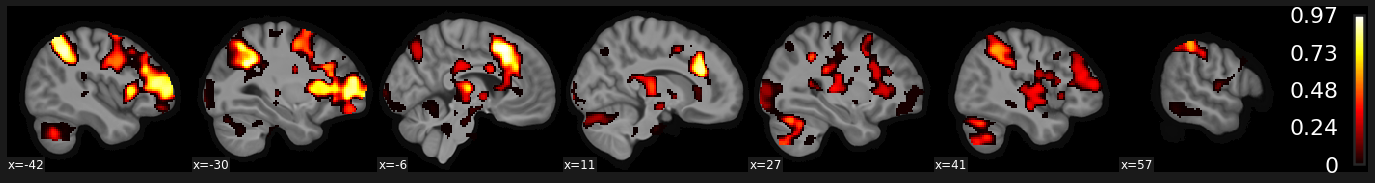

In [53]:
# p maps
con_ids = ['0012']
# con_id = '0013'

for con_id in con_ids:

    plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/con%s_tfce_corrp_tstat1.nii.gz' %con_id,
                          bg_img = anat_mean,
                           display_mode = 'x',
                           colorbar=True)
    
#     plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/sv_map_correction/con%s_tfce_corrp_tstat1.nii.gz' %con_id,
#                           bg_img = anat_mean,
#                            display_mode = 'x',
#                            threshold = 0.8, 
#                            colorbar=True)

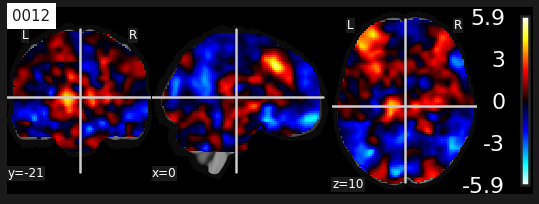

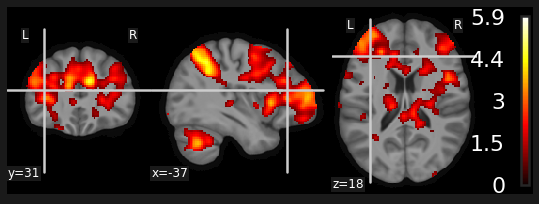

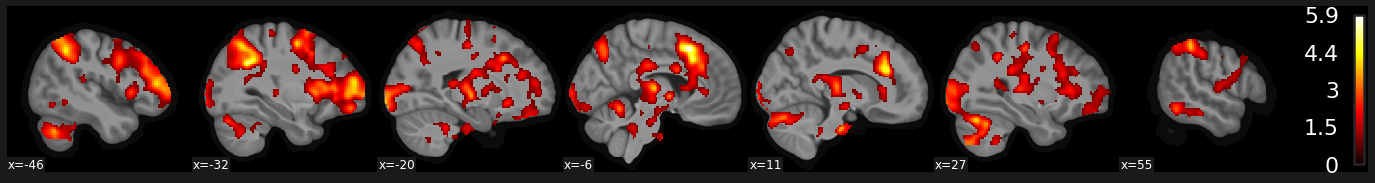

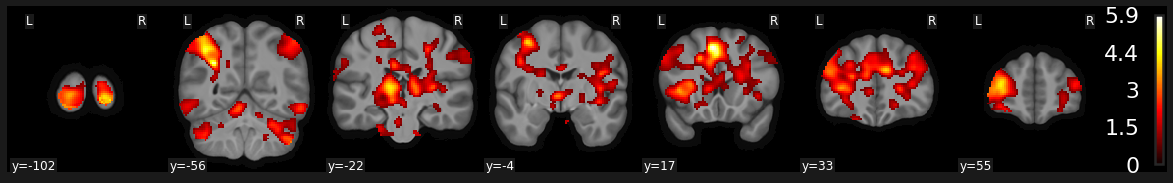

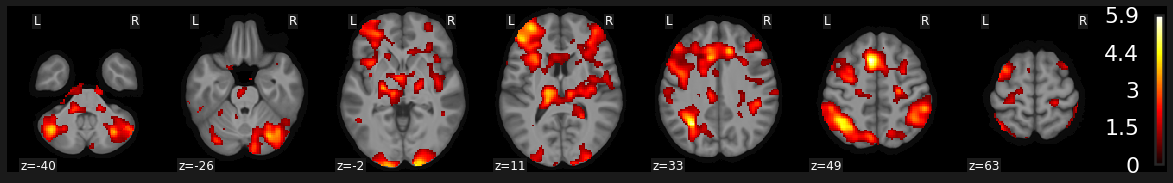

In [55]:
# visualize thresholded t values
con_ids = ['0012']


for con_id in con_ids:
    
    t_plot = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/con%s_tstat1.nii.gz' %con_id)
    p = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/con%s_tfce_corrp_tstat1.nii.gz' %con_id)

    # thr = 0.95
    t_plot_data = t_plot.get_data()
    p_data = p.get_data()

    # threshold raw t map by p values
    p_mask = p_data == 0
    t_plot_data[p_mask] = 0    
    
    plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/con%s_tstat1.nii.gz' %con_id,
                          bg_img = anat_mean,
                          title = con_id)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="x", 
                           colorbar=True)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="y",
                           colorbar=True)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="z",
                           colorbar=True)

Flipped, Negative SV maps <a class = "anchor" id = "tfce_neg-bullet"></a>

In [ ]:
# flipped
con_ids = ['0012', '0013']

for con_id in con_ids:
#     con_id = '0010'

    con_all = {}

    for i in sub_num:
        con_image = glob.glob('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/1stLevel/_subject_id_' + str(i) + '/con_' + con_id + '.nii')
        con_all[str(i)] = list(con_image)
    # con_all
    # len(con_all)

    # smooth, fwhm = none
    smooth_con_all = []

    for k, v in con_all.items():
        smooth_con = image.smooth_img(v[0],None) #  If fwhm is None, no filtering is performed (useful when just removal of non-finite values is needed).
        smooth_con_all.append(smooth_con)

    #     plotting.plot_glass_brain(smooth_con, colorbar = True)

    # flip sign for negative SV maps
    smooth_con_flip_all = []

    for smooth_img in smooth_con_all:
        smooth_img_flip = image.math_img("-img", img=smooth_img)
        smooth_con_flip_all.append(smooth_img_flip)

    # concatenate    
    con_concat_flip = image.concat_imgs(smooth_con_flip_all, auto_resample = True)
    con_concat_flip.to_filename(os.path.join(out_root, 'imaging', 'Sink_resp_mon_sv', 'mon_sv_glm_con%s_flip_all_sub.nii.gz' %con_id))


    cluster_thr = fsl.Randomise(in_file = os.path.join(out_root, 'imaging', 'Sink_resp_mon_sv', 'mon_sv_glm_con%s_flip_all_sub.nii.gz' %con_id),
                                mask = '/home/rj299/scratch60/mdm_analysis/output/imaging/wb_mask_group.nii.gz',
                                base_name = os.path.join(out_root, 'imaging', 'Sink_resp_mon_sv', 'con%s_flip' %con_id),
                                one_sample_group_mean = True,
                                tfce = True,
                                vox_p_values = True,
                                num_perm = 5000)
    cluster_thr.run()

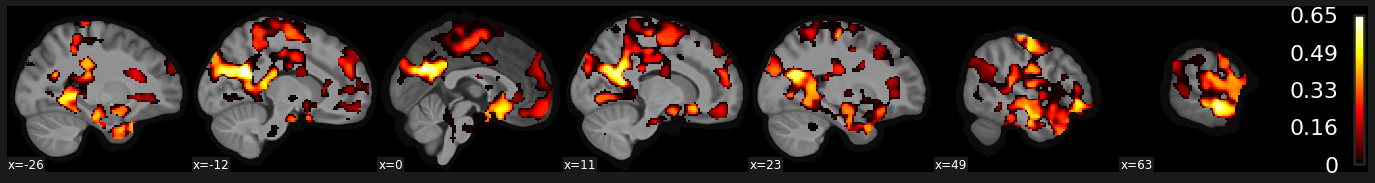

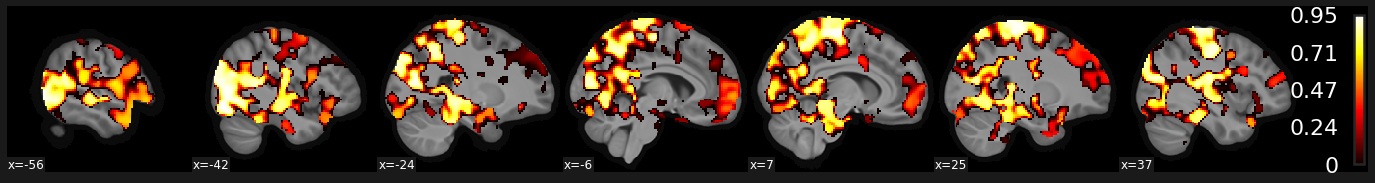

In [4]:
# p maps
con_ids = ['0012', '0013']
# con_id = '0013'

for con_id in con_ids:

    plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_flip_tfce_corrp_tstat1.nii.gz' %con_id,
                          bg_img = anat_mean,
                           display_mode = 'x',
#                            threshold = 8,
                           colorbar=True)
    

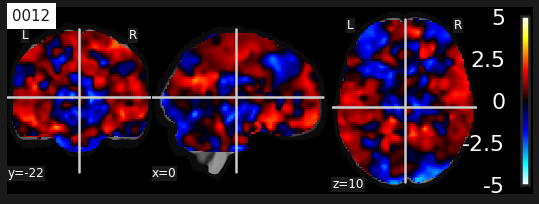

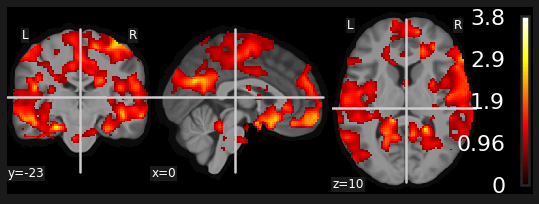

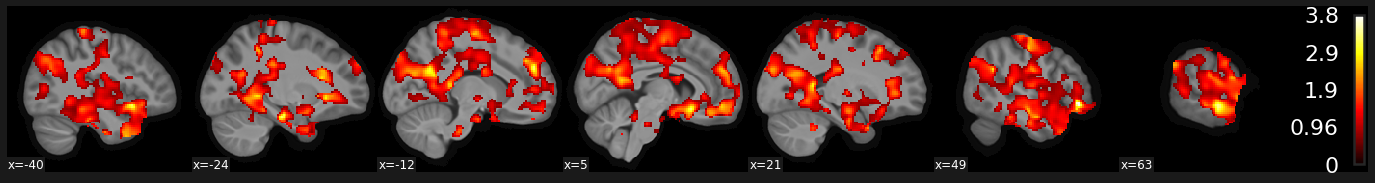

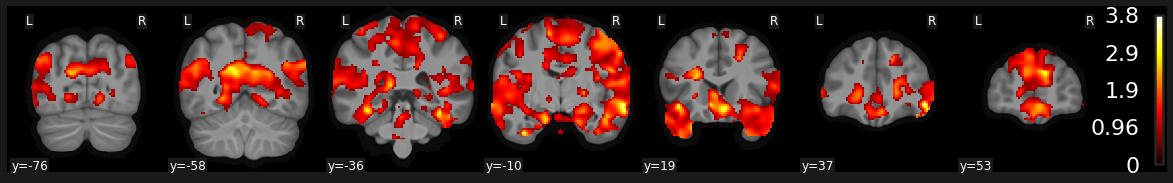

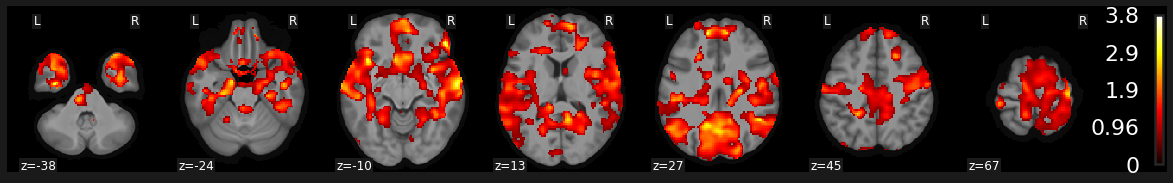

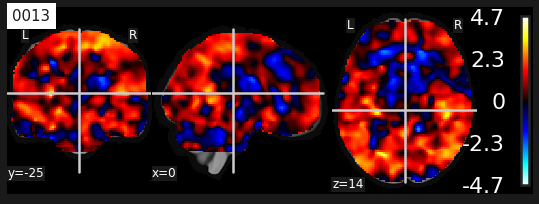

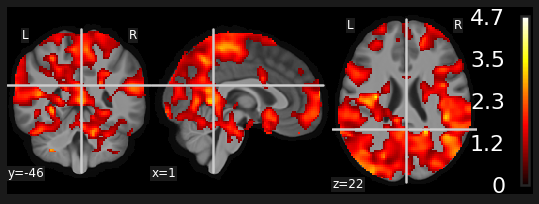

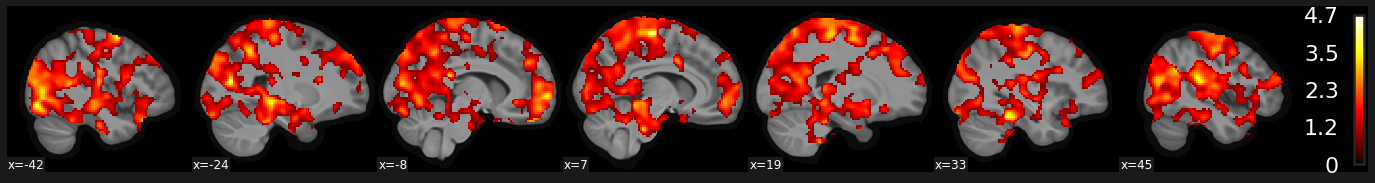

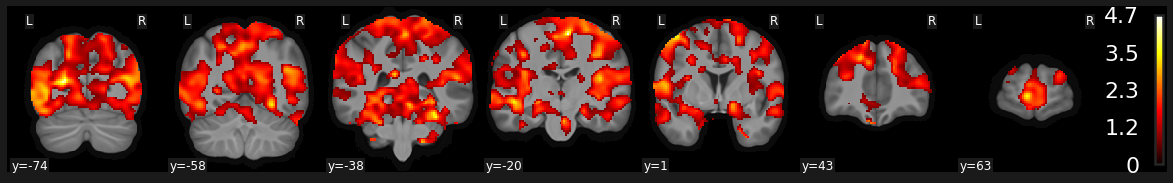

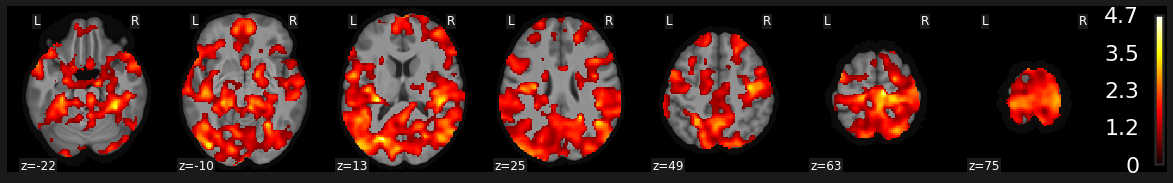

In [9]:
# visualize thresholded t values
con_ids = ['0012', '0013']


for con_id in con_ids:
    
    t_plot = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_flip_tstat1.nii.gz' %con_id)
    p = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_flip_tfce_corrp_tstat1.nii.gz' %con_id)

#     thr = 0.95
    t_plot_data = t_plot.get_data()
    p_data = p.get_data()

    # threshold raw t map by p values
#     p_mask = p_data < thr
    p_mask = p_data == 0
    t_plot_data[p_mask] = 0    
    
    plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_flip_tstat1.nii.gz' %con_id,
                          bg_img = anat_mean,
                          title = con_id)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="x", 
                           colorbar=True)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="y",
                           colorbar=True)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="z",
                           colorbar=True)

## ROI analysis

**Contrast IDs:**  
cont1 = ('Med_amb_24', 'T', cond_names, [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  
cont2 = ('Med_amb_50', 'T', cond_names, [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  
cont3 = ('Med_amb_74', 'T', cond_names, [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  
cont4 = ('Med_risk_25', 'T', cond_names, [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])  
cont5 = ('Med_risk_50', 'T', cond_names, [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])  
cont6 = ('Med_risk_75', 'T', cond_names, [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])  

cont7 = ('Med_amb_50>24', 'T', cond_names, [-1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  
cont8 = ('Med_amb_74>50', 'T', cond_names, [0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  
cont9 = ('Med_amb_74>24', 'T', cond_names, [-1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  

cont10 = ('Med_risk_50>25', 'T', cond_names, [0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0])  
cont11 = ('Med_risk_75>50', 'T', cond_names, [0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0])  
cont12 = ('Med_risk_75>25', 'T', cond_names, [0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0])  

cont13 = ('Mon_amb_24', 'T', cond_names, [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])  
cont14 = ('Mon_amb_50', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])  
cont15 = ('Mon_amb_74', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])  
cont16 = ('Mon_risk_25', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])  
cont17 = ('Mon_risk_50', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])  
cont18 = ('Mon_risk_75', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])  

cont19 = ('Mon_amb_50>24', 'T', cond_names, [0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0])  
cont20 = ('Mon_amb_74>50', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0])  
cont21 = ('Mon_amb_74>24', 'T', cond_names, [0, 0, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0, 0])  

cont22 = ('Mon_risk_50>25', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0])  
cont23 = ('Mon_risk_75>50', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0])  
cont24 = ('Mon_risk_75>25', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0])  

cont25 = ('Response', 'T', cond_names, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])  

In [10]:
data_root

'/home/rj299/project/mdm_analysis/'

In [12]:
# Masker files
maskfile_vmpfc = os.path.join(data_root,'output','imaging', 'binConjunc_PvNxDECxRECxMONxPRI_vmpfc.nii.gz')
maskfile_vstr = os.path.join(data_root,'output','imaging', 'binConjunc_PvNxDECxRECxMONxPRI_striatum.nii.gz')
mask_file_rppc = os.path.join(data_root,'output','imaging', 'Gilaie-DotanEtAl_2014_Study1_rPPC-NScorr-Thres250Voxels_roi.nii')
maskfile_roi1 = os.path.join(data_root,'output','imaging', 'none_glm_Med_Mon_TFCE_p001_roi1.nii.gz')
maskfile_roi2 = os.path.join(data_root,'output','imaging', 'none_glm_Med_Mon_TFCE_p001_roi2.nii.gz')
maskfile_roi3 = os.path.join(data_root,'output','imaging', 'none_glm_Med_Mon_TFCE_p001_roi3.nii.gz')

maskfiles = {'vmpfc': maskfile_vmpfc, 
             'vstr': maskfile_vstr, 
             'rppc': mask_file_rppc,
             'med_mon_1': maskfile_roi1, 
             'med_mon_2': maskfile_roi2, 
             'med_mon_3': maskfile_roi3}

# roi inputs are loaded images
all_masks = {key_name: nib.load(maskfiles[key_name]) for key_name in maskfiles.keys()}

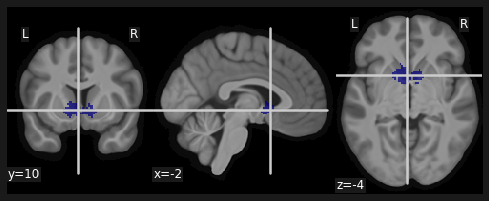

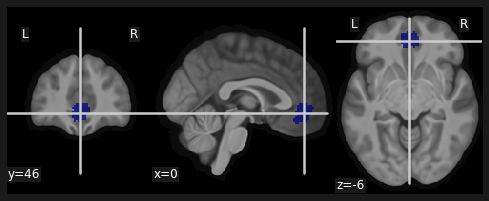

In [34]:
plotting.plot_roi(all_masks['vstr'], bg_img = anat_mean)
plotting.plot_roi(all_masks['vmpfc'], bg_img = anat_mean)

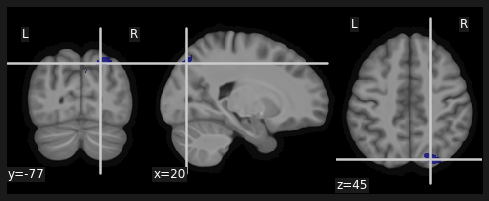

In [13]:
plotting.plot_roi(all_masks['rppc'], bg_img = anat_mean)

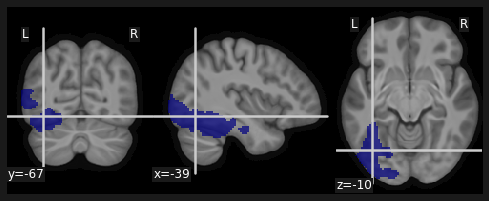

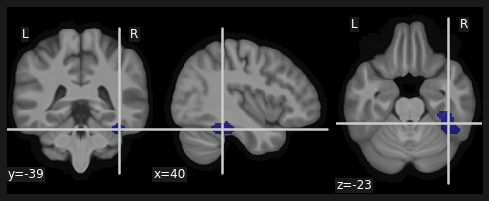

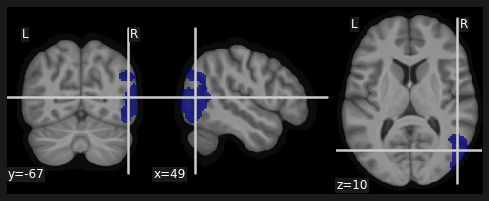

In [28]:
plotting.plot_roi(all_masks['med_mon_1'], bg_img = anat_mean)
plotting.plot_roi(all_masks['med_mon_2'], bg_img = anat_mean)
plotting.plot_roi(all_masks['med_mon_3'], bg_img = anat_mean)

In [14]:
# rppc
# extract betas (t) from ROI

con_ids = ['0001', '0002','0003', '0004', '0005', '0006']
con_names = ["amb_24", "amb_50", "amb_74", "risk_25", "risk_50", "risk_75"]

betas = []

for (idx, con_id) in enumerate(con_ids):
    
    beta = []
    for sub in sub_num:

        masker = NiftiMasker(os.path.join(data_root,"output", "imaging", "Gilaie-DotanEtAl_2014_Study1_rPPC-NScorr-Thres250Voxels_roi.nii"))

#         beta_sub = masker.fit_transform('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/1stLevel/_subject_id_%s/con_%s.nii' %(sub, con_id))
        beta_sub = masker.fit_transform('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_%s/spmT_%s.nii' %(sub, con_id))
        
        # average of beta from this ROI, a list of all participants
        beta.append(np.mean(beta_sub[0]))
    
    # a list of 
    betas.append(np.array(beta))
    
# plot
# calculate mean and se
betas_mean = np.mean(betas, axis = 1)
betas_se = stats.sem(betas, axis = 1)

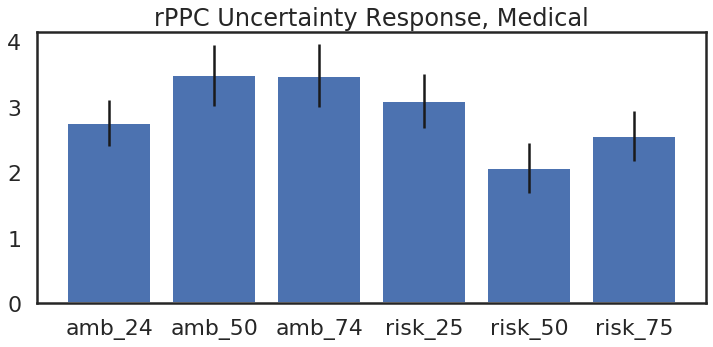

In [15]:
fig, ax = plt.subplots(1,1,figsize = (12,5))
ax.bar(range(len(con_names)), betas_mean, yerr = betas_se, tick_label = con_names)
ax.set_title("rPPC Uncertainty Response, Medical")
plt.show()

In [25]:
# ventral striatum
# extract betas (t) from ROI

con_ids = ['0001', '0002','0003', '0004', '0005', '0006']
con_names = ["amb_24", "amb_50", "amb_74", "risk_25", "risk_50", "risk_75"]

betas = []

for (idx, con_id) in enumerate(con_ids):
    
    beta = []
    for sub in sub_num:

        masker = NiftiMasker(os.path.join(data_root,"output", "imaging", "binConjunc_PvNxDECxRECxMONxPRI_striatum.nii.gz"))

#         beta_sub = masker.fit_transform('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/1stLevel/_subject_id_%s/con_%s.nii' %(sub, con_id))
        beta_sub = masker.fit_transform('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_%s/spmT_%s.nii' %(sub, con_id))
        
        # average of beta from this ROI, a list of all participants
        beta.append(np.mean(beta_sub[0]))
    
    # a list of 
    betas.append(np.array(beta))
    
# plot
# calculate mean and se
betas_mean = np.mean(betas, axis = 1)
betas_se = stats.sem(betas, axis = 1)

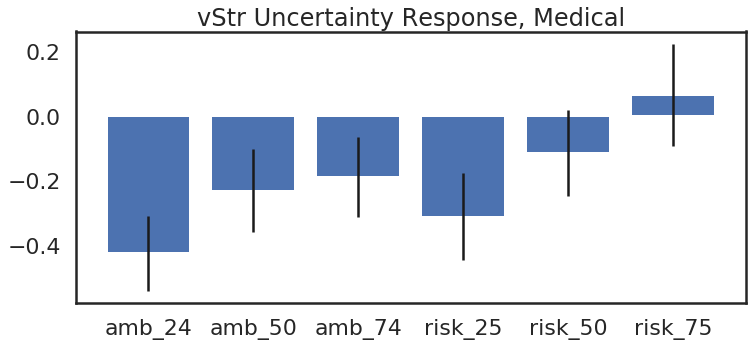

In [26]:
fig, ax = plt.subplots(1,1,figsize = (12,5))
ax.bar(range(len(con_names)), betas_mean, yerr = betas_se, tick_label = con_names)
ax.set_title("vStr Uncertainty Response, Medical")
plt.show()

In [19]:
# rppc
# extract betas (t) from ROI

con_ids = ['0010', '0011','0012']
con_names = ["risk_50>25", "risk_75>50", "risk_75>25"]

betas = []

for (idx, con_id) in enumerate(con_ids):
    
    beta = []
    for sub in sub_num:

        masker = NiftiMasker(os.path.join(data_root,"output", "imaging", "Gilaie-DotanEtAl_2014_Study1_rPPC-NScorr-Thres250Voxels_roi.nii"))

#         beta_sub = masker.fit_transform('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/1stLevel/_subject_id_%s/con_%s.nii' %(sub, con_id))
        beta_sub = masker.fit_transform('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_%s/spmT_%s.nii' %(sub, con_id))
        
        # average of beta from this ROI, a list of all participants
        beta.append(np.mean(beta_sub[0]))
    
    # a list of 
    betas.append(np.array(beta))
    
# plot
# calculate mean and se
betas_mean = np.mean(betas, axis = 1)
betas_se = stats.sem(betas, axis = 1)

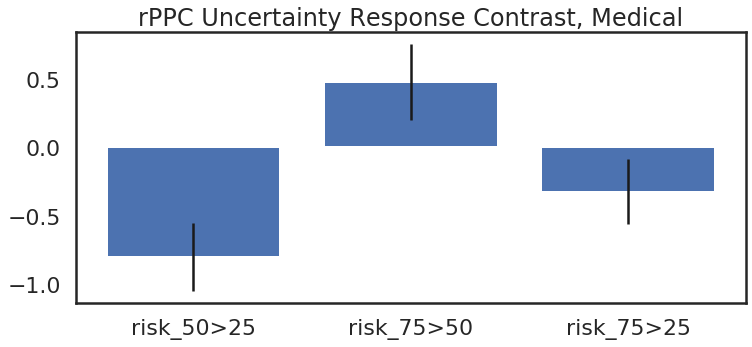

In [20]:
fig, ax = plt.subplots(1,1,figsize = (12,5))
ax.bar(range(len(con_names)), betas_mean, yerr = betas_se, tick_label = con_names)
ax.set_title("rPPC Uncertainty Response Contrast, Medical")
plt.show()

In [17]:
# rppc
# extract betas (t) from ROI

con_ids = ['0013', '0014','0015', '0016', '0017', '0018']
con_names = ["amb_24", "amb_50", "amb_74", "risk_25", "risk_50", "risk_75"]

betas = []

for (idx, con_id) in enumerate(con_ids):
    
    beta = []
    for sub in sub_num:

        masker = NiftiMasker(os.path.join(data_root,"output", "imaging", "Gilaie-DotanEtAl_2014_Study1_rPPC-NScorr-Thres250Voxels_roi.nii"))

#         beta_sub = masker.fit_transform('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/1stLevel/_subject_id_%s/con_%s.nii' %(sub, con_id))
        beta_sub = masker.fit_transform('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_%s/spmT_%s.nii' %(sub, con_id))
        
        # average of beta from this ROI, a list of all participants
        beta.append(np.mean(beta_sub[0]))
    
    # a list of 
    betas.append(np.array(beta))
    
# plot
# calculate mean and se
betas_mean = np.mean(betas, axis = 1)
betas_se = stats.sem(betas, axis = 1)

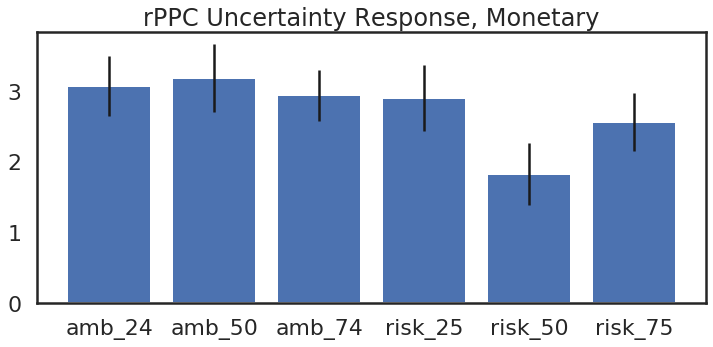

In [18]:
fig, ax = plt.subplots(1,1,figsize = (12,5))
ax.bar(range(len(con_names)), betas_mean, yerr = betas_se, tick_label = con_names)
ax.set_title("rPPC Uncertainty Response, Monetary")
plt.show()

In [22]:
# rppc
# extract betas (t) from ROI

con_ids = ['0022','0023','0024']
con_names = ["risk_50>25", "risk_75>50", "risk_75>25"]

betas = []

for (idx, con_id) in enumerate(con_ids):
    
    beta = []
    for sub in sub_num:

        masker = NiftiMasker(os.path.join(data_root,"output", "imaging", "Gilaie-DotanEtAl_2014_Study1_rPPC-NScorr-Thres250Voxels_roi.nii"))

#         beta_sub = masker.fit_transform('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/1stLevel/_subject_id_%s/con_%s.nii' %(sub, con_id))
        beta_sub = masker.fit_transform('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_uncert/1stLevel/_subject_id_%s/spmT_%s.nii' %(sub, con_id))
        
        # average of beta from this ROI, a list of all participants
        beta.append(np.mean(beta_sub[0]))
    
    # a list of 
    betas.append(np.array(beta))
    
# plot
# calculate mean and se
betas_mean = np.mean(betas, axis = 1)
betas_se = stats.sem(betas, axis = 1)

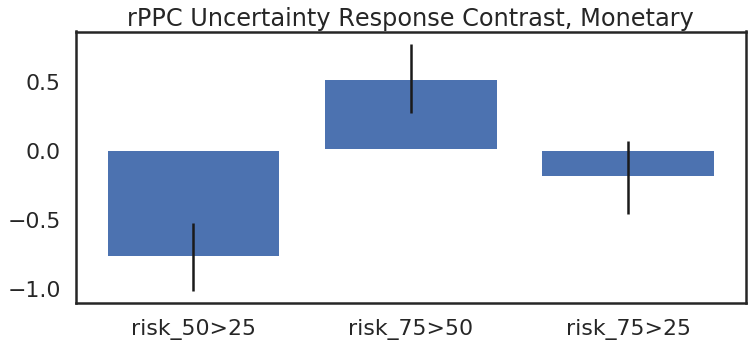

In [23]:
fig, ax = plt.subplots(1,1,figsize = (12,5))
ax.bar(range(len(con_names)), betas_mean, yerr = betas_se, tick_label = con_names)
ax.set_title("rPPC Uncertainty Response Contrast, Monetary")
plt.show()

In [24]:
#stats
for (con_idx, con_id) in enumerate(con_ids):
    print(stats.ttest_1samp(betas[con_idx], popmean = 0))

Ttest_1sampResult(statistic=-3.1796311169935567, pvalue=0.0032660048308389184)
Ttest_1sampResult(statistic=2.054326397171043, pvalue=0.04818753025189844)
Ttest_1sampResult(statistic=-0.7445117167586389, pvalue=0.4619998204959501)
